In [1]:
%load_ext autoreload
%autoreload 2

#### dependencies

In [2]:
import torch

from circuit_pruner.utils import *
from circuit_pruner.visualizer.layouts import *
#from circuit_pruner.visualizer.cnn_gui import *
from circuit_pruner.visualizer.circuit_gui import *
from circuit_pruner.visualizer.utils import *
from circuit_pruner.visualizer.featureviz import *



from circuit_pruner.utils import *
from circuit_pruner.force import *
from circuit_pruner.extraction import *
from circuit_pruner.ranks import *

import os
import plotly.offline as py
import plotly.graph_objs as go
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_daq as daq
from dash.exceptions import PreventUpdate
#import utils.dash_reusable_components as drc
import flask
import json
from dash.dependencies import Input, Output, State
from plotly.subplots import make_subplots
from flask_caching import Cache
import base64

#### load model 

In [3]:
#hardware
device = 'cuda:0'

from circuit_pruner.utils import load_config

config = load_config('/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/configs/alexnet_sparse_config.py')
model = config.model.to('cpu')



#general
import torch
import os
from copy import deepcopy
from circuit_pruner.force import setup_net_for_circuit_prune, show_model_layer_names


#show_model_layer_names(model)

#### define target filter(s)

In [11]:
#feature target
# layer = 'features_10'
# unit = 241
layer = 'features_6'
unit = 56
#layer = 'features_0'
#unit = 0

feature_targets = {layer:[unit]}

#### dataloader (what images do we want to 'preserve' the filter's response to)

In [12]:
from circuit_pruner.data_loading import rank_image_data
from circuit_pruner.data_loading import single_image_data
from torchvision import transforms
from torch.utils import data


#make 'general' filter dataloader
imnet_kwargs = {'num_workers': 4, 'pin_memory': True, 'sampler':None} if 'cuda' in device else {}


#(this data loader is of 2 random images from each imagenet class)
imnet2_dataloader = data.DataLoader(rank_image_data(config.data_path,
                                            config.preprocess,
                                            label_file_path = config.label_file_path,
                                            class_folders=True),
                                            batch_size=300,
                                            shuffle=False,
                                            **imnet_kwargs)


## Hierarchical Pruning

The best way to get a good interpretable circuit is to prune 'heirarchically', by first knocking out as many filters as possible (minimize the number of nodes in the graph), then prune the resultant structure with respect to kernels, (edges in graph)

### filter pruning

#### setup model

In [13]:
from copy import deepcopy
from circuit_pruner.dissected_Conv2d import dissect_model


#we use dissect = False as an argument, meaning we dont need the activation maps output by individual kernels.
#This is because we are first pruning with respect to 'Filters' and not yet 'kernels'.
#setting dissect to false will make everything run faster, as dissected models are slow
filter_rankable_model = dissect_model(deepcopy(model), dissect=False,store_ranks = True, device=device)
filter_rankable_model.to(device)
from circuit_pruner.dissected_Conv2d import set_across_model, set_model_target_node

#setup dissected model hyper params


set_model_target_node(filter_rankable_model,layer,unit)
set_across_model(filter_rankable_model,'rank_field','image')
set_across_model(filter_rankable_model,'absolute_rank',True)


AlexNet(
  (features): Sequential(
    (0): hooked_Conv2d(
      (from_conv): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    )
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): hooked_Conv2d(
      (from_conv): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): hooked_Conv2d(
      (from_conv): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (7): ReLU()
    (8): hooked_Conv2d(
      (from_conv): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (9): ReLU()
    (10): hooked_Conv2d(
      (from_conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=

#### get filter ranks from model

In [14]:
#actually extract ranks by running images through model

from circuit_pruner.dissected_Conv2d import get_ranklist_from_dissected_Conv2d_modules, clear_ranks_across_model

clear_ranks_across_model(filter_rankable_model)

iter_dataloader = iter(imnet2_dataloader)
iters = len(iter_dataloader)

for it in range(iters):

    inputs, label = next(iter_dataloader)
    inputs = inputs.to(device)
    
    #clear_ranks_across_model(filter_rankable_model)  #we dont want to clear ranks, we accumulate them over all images
    
    filter_rankable_model.zero_grad()

    try:
        outputs = filter_rankable_model(inputs)
    except:
        pass

ranks = get_ranklist_from_dissected_Conv2d_modules(filter_rankable_model, structure='filters')

In [15]:
from circuit_pruner.ranks import minmax_norm_ranks

normed_ranks = minmax_norm_ranks(ranks)

In [16]:
del filter_rankable_model
torch.cuda.empty_cache()

Now that we have the filters ranks, we can check the filter sparsity at which the model starts to degrade

In [12]:
from circuit_pruner.extraction import get_preservation_at_sparsities

structure='filters'

sparsities = np.linspace(.25, .05, num=6)

scores = get_preservation_at_sparsities(model,normed_ranks,
                               feature_targets,imnet2_dataloader,
                               sparsities,device,metric='pearson',
                               rank_field = 'orig_max',structure=structure)

original
features_6 effective last layer
average orig acts:
feature features_6:301: 0.5155206322669983
Target Sparsity: 0.25
features_6 effective last layer
target sparsity: 0.25
total params to feature: 257

kept params in original mask: 65      (total params * sparsity)
original mask: 57996 params
effective mask: 37611 params
effective_sparsity: 0.2490272373540856
features_6 effective last layer
average circuit acts:
feature features_6:0: -0.3300381004810333
SCORE: 0.953751716915191


Target Sparsity: 0.21
features_6 effective last layer
target sparsity: 0.21
total params to feature: 257

kept params in original mask: 54      (total params * sparsity)
original mask: 49055 params
effective mask: 27409 params
effective_sparsity: 0.20622568093385213
features_6 effective last layer
average circuit acts:
feature features_6:0: -0.7313753366470337
SCORE: 0.9457587467086019


Target Sparsity: 0.16999999999999998
features_6 effective last layer
target sparsity: 0.16999999999999998
total param

In [13]:
import plotly.express as px

metric = 'pearson'
fig = px.line(x=sparsities[:len(scores['%s:%s'%(layer,unit)][metric])], y=scores['%s:%s'%(layer,unit)][metric])
fig.update_xaxes(autorange="reversed")
fig.show()

In [17]:
from circuit_pruner.extraction import model_ranks_2_circuit_model


sparsity = .3
filter_pruned_circuit,filter_mask = model_ranks_2_circuit_model(normed_ranks,sparsity,
                                                           model,feature_targets,device,
                                                           structure='filters',use_effective_mask=True,
                                                           rank_field='image')



features_6 effective last layer
target sparsity: 0.3
total params to feature: 257

kept params in original mask: 78      (total params * sparsity)
original mask: 86218 params
effective mask: 45804 params
effective_sparsity: 0.29961089494163423


------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:09<00:00, 53.15it/s]



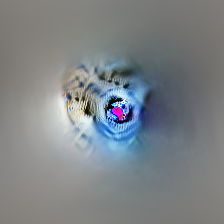

(13, 13)
(6, 6)
[(62.0, 161.0), (62.0, 161.0)]


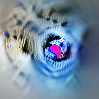

In [18]:
from circuit_pruner.visualizer.featureviz  import featviz_in_recep_field


featviz_in_recep_field(filter_pruned_circuit,layer,0,margin=0)

In [19]:
filter_pruned_circuit

Sequential(
  (features_0): Conv2d(3, 30, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (features_1): ReLU(inplace=True)
  (features_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_3): Conv2d(30, 46, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (features_4): ReLU(inplace=True)
  (features_5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_6): Conv2d(46, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

when we prune hierachically, and plan to use the circuit_gui tool, its useful to not keep pruning a previously generated circuit, but rather mask the original model and rerank and prune again. This will allow us to generate a mask with respect to the 'original' model, which will be useful for getting all the correct filter/kernel ids when using the circuit_diagram 


In [15]:
from circuit_pruner.extraction import zero_model_weights_with_mask 

del filter_pruned_circuit

filter_masked_model = zero_model_weights_with_mask(deepcopy(model),filter_mask)


/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/circuit_pruner/extraction.py:787: UserWarning:

Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/aten/src/ATen/native/TensorIterator.cpp:918.)



#### Kernel Pruning

In [20]:
#kernel_rankable_model = dissect_model(deepcopy(filter_masked_model), dissect=True,store_ranks = True, device=device)
kernel_rankable_model = dissect_model(deepcopy(filter_pruned_circuit), dissect=True,store_ranks = True, device=device)
kernel_rankable_model.to(device)

#set_model_target_node(kernel_rankable_model,layer,unit)
set_model_target_node(kernel_rankable_model,layer,0)
set_across_model(kernel_rankable_model,'rank_field','image')
set_across_model(kernel_rankable_model,'absolute_rank',True)


Sequential(
  (features_0): dissected_Conv2d(
    (preadd_conv): Conv2d(3, 90, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), groups=3, bias=False)
  )
  (features_1): ReLU()
  (features_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_3): dissected_Conv2d(
    (preadd_conv): Conv2d(30, 1380, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=30, bias=False)
  )
  (features_4): ReLU()
  (features_5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_6): dissected_Conv2d(
    (preadd_conv): Conv2d(46, 46, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=46, bias=False)
  )
)

dissected models have more memory, so we have to change the batchsize

In [21]:
#make 'general' filter dataloader
imnet_kwargs = {'num_workers': 4, 'pin_memory': True, 'sampler':None} if 'cuda' in device else {}


#(this data loader is of 2 random images from each imagenet class)
imnet2_dataloader = data.DataLoader(rank_image_data(config.data_path,
                                            config.preprocess,
                                            label_file_path = config.label_file_path,
                                            class_folders=True),
                                            batch_size=4,
                                            shuffle=False,
                                            **imnet_kwargs)


In [22]:
#actually extract ranks by running images through model

from circuit_pruner.dissected_Conv2d import get_ranklist_from_dissected_Conv2d_modules, clear_ranks_across_model

clear_ranks_across_model(kernel_rankable_model)

iter_dataloader = iter(imnet2_dataloader)
iters = len(iter_dataloader)

for it in range(iters):

    inputs, label = next(iter_dataloader)
    inputs = inputs.to(device)
    
    #clear_ranks_across_model(filter_rankable_model)  #we dont want to clear ranks, we accumulate them over all images
    
    kernel_rankable_model.zero_grad()

    try:
        outputs = kernel_rankable_model(inputs)
    except:
        pass

ranks = get_ranklist_from_dissected_Conv2d_modules(kernel_rankable_model, structure='kernels')

In [23]:
from circuit_pruner.ranks import minmax_norm_ranks

normed_ranks = minmax_norm_ranks(ranks)

In [24]:
del kernel_rankable_model
torch.cuda.empty_cache()

In [23]:
from circuit_pruner.extraction import get_preservation_at_sparsities

structure='kernels'

sparsities = np.linspace(.1, .001, num=10)

scores = get_preservation_at_sparsities(model,ranks,
                               feature_targets,imnet2_dataloader,
                               sparsities,device,metric='pearson',
                               rank_field = 'orig_max',structure=structure)

original
features_6 effective last layer
average orig acts:
feature features_6:301: 0.5155200958251953
Target Sparsity: 0.1
features_6 effective last layer
target sparsity: 0.1
total params to feature: 12672

kept params in original mask: 1268      (total params * sparsity)
gradients from this feature are sparse,the minimum acceptable rank at this sparsity has a score of zero! we will return a mask thats smaller than you asked, by masking all parameters with a score of zero.
original mask: 19445 params
effective mask: 19445 params
effective_sparsity: 0.04142992424242424
features_6 effective last layer
average circuit acts:
feature features_6:0: -1.4045476913452148
SCORE: 0.9052473531852605


Target Sparsity: 0.08900000000000001
features_6 effective last layer
target sparsity: 0.08900000000000001
total params to feature: 12672

kept params in original mask: 1128      (total params * sparsity)
gradients from this feature are sparse,the minimum acceptable rank at this sparsity has a score

In [24]:
import plotly.express as px


fig = px.line(x=sparsities[:len(scores['%s:%s'%(layer,unit)][metric])], y=scores['%s:%s'%(layer,unit)][metric])
fig.update_xaxes(autorange="reversed")
fig.show()

In [28]:
from circuit_pruner.extraction import model_ranks_2_circuit_model


sparsity = .05
# kernel_pruned_circuit,kernel_mask = model_ranks_2_circuit_model(ranks,sparsity,
#                                                            model,feature_targets,device,
#                                                            structure='kernels',use_effective_mask=True,
#                                                            rank_field='image')

circuit_feature_targets = {layer:[0]}
kernel_pruned_circuit,kernel_mask = model_ranks_2_circuit_model(ranks,sparsity,
                                                           filter_pruned_circuit,circuit_feature_targets,device,
                                                           structure='kernels',use_effective_mask=True,
                                                           rank_field='image')


features_6 effective last layer
target sparsity: 0.05
total params to feature: 1516

kept params in original mask: 76      (total params * sparsity)
original mask: 3020 params
effective mask: 2408 params
effective_sparsity: 0.026385224274406333


In [29]:
kernel_pruned_circuit

Sequential(
  (features_0): Conv2d(3, 7, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (features_1): ReLU(inplace=True)
  (features_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_3): Conv2d(7, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (features_4): ReLU(inplace=True)
  (features_5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_6): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [30]:
kernel_pruned_circuit

Sequential(
  (features_0): Conv2d(3, 7, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (features_1): ReLU(inplace=True)
  (features_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_3): Conv2d(7, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (features_4): ReLU(inplace=True)
  (features_5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_6): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

### Circuit Diagram

for circuit diagrams, partial filters (only some kernels removed from the filter) in the first layer are annoying, as it just messes with the color but doesnt really make things simpler. Lets fill those in . . .

In [30]:
from circuit_pruner.extraction import fill_partial_filters_in_mask, extract_circuit_with_eff_mask


kernel_mask[0] = fill_partial_filters_in_mask(kernel_mask[0])
kernel_pruned_circuit = extract_circuit_with_eff_mask(model,kernel_mask)


Now if weve got a model, circuit, ranks and mask, we can generate a circuit diagram easily

No folder specified to store cache of visualizations (in case you want to visualize this circuit again more quickly).                Storing at /mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/visualization_cache/circuit_at_1652376075.1324224. You might want to rename this to something sensible if you hold onto this circuit.
already kernel ranks . . .
generating feature_viz objective string for 67
deepviz image not found for 67, generating . . .
generating featviz with objective: features_3:67
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]     

100%|██████████| 512/512 [00:06<00:00, 81.08it/s]



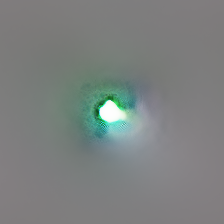

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 70
deepviz image not found for 70, generating . . .
generating featviz with objective: features_3:70
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:06<00:00, 82.27it/s]



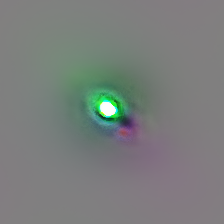

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 72
deepviz image not found for 72, generating . . .
generating featviz with objective: features_3:72
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:06<00:00, 80.78it/s]



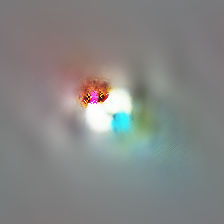

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 85
deepviz image not found for 85, generating . . .
generating featviz with objective: features_3:85
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:06<00:00, 80.75it/s]



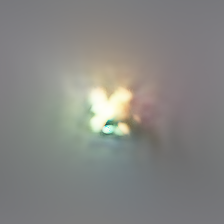

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 88
deepviz image not found for 88, generating . . .
generating featviz with objective: features_3:88
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:06<00:00, 80.46it/s]



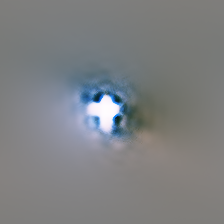

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 103
deepviz image not found for 103, generating . . .
generating featviz with objective: features_3:103
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:06<00:00, 81.76it/s]



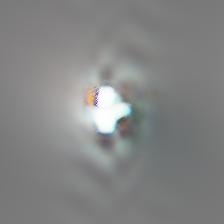

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 105
deepviz image not found for 105, generating . . .
generating featviz with objective: features_3:105
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:05<00:00, 91.26it/s] 



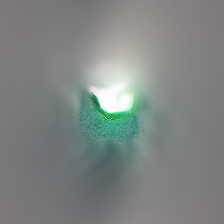

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 106
deepviz image not found for 106, generating . . .
generating featviz with objective: features_3:106
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:04<00:00, 102.77it/s]



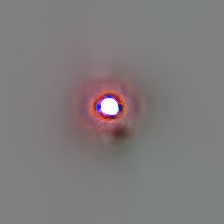

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 256
deepviz image not found for 256, generating . . .
generating featviz with objective: features_6:256
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:05<00:00, 98.52it/s]



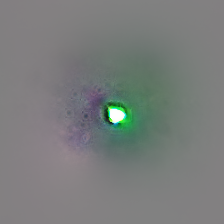

(13, 13)
(6, 6)
[(62.0, 161.0), (62.0, 161.0)]


In [31]:
from circuit_pruner.visualizer.circuit_gui import *

viz_folder = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/visualization_cache/test_1'

circuit_diagram = launch_circuit_gui(kernel_pruned_circuit,kernel_mask,model,ranks,interactive=False,device=device)
#launch_circuit_gui(kernel_pruned_circuit,kernel_mask,model,ranks,port=8051,viz_folder=viz_folder,device=device)


In [32]:
circuit_diagram[1]

edge_num  layer_name  layer  out_channel  in_channel      rank  norm_rank
0          1  features_0      0            0           1  0.000062   0.069051
1          6  features_0      0            2           0  0.000094   0.104441
2          7  features_0      0            2           1  0.000055   0.060868
3         24  features_0      0            8           0  0.000128   0.142632
4         25  features_0      0            8           1  0.000155   0.173681
5         26  features_0      0            8           2  0.000053   0.059128
6         27  features_0      0            9           0  0.000492   0.551008
7         28  features_0      0            9           1  0.000892   1.000000
8         29  features_0      0            9           2  0.000409   0.457963
9         48  features_0      0           16           0  0.000131   0.146006
10        49  features_0      0           16           1  0.000257   0.287360
11        50  features_0      0           16           2  0.000147   0.164659
12        60  features_0      0           20           0  0.000059   0.065254
13        61  features_0      0           20           1  0.000052   0.057505
14        81  features_0      0           27           0  0.000074   0.082808
15        83  features_0      0           27           2  0.000090   0.100552
16       189  features_3      1            3           9  0.000071   0.159060
17       272  features_3      1            6           2  0.000052   0.116910
18       278  features_3      1            6           8  0.000076   0.172045
19       279  features_3      1            6           9  0.000443   1.000000
20       290  features_3      1            6          20  0.000060   0.135670
21       297  features_3      1            6          27  0.000095   0.213136
22       338  features_3      1            8           8  0.000055   0.123894
23       339  features_3      1            8           9  0.000052   0.117786
24       346  features_3      1            8          16  0.000062   0.140894
25       357  features_3      1            8          27  0.000064   0.143408
26       720  features_3      1           21           0  0.000066   0.147819
27       722  features_3      1           21           2  0.000050   0.111723
28       837  features_3      1           24          27  0.000067   0.150089
29      1276  features_3      1           39          16  0.000068   0.153141
30      1329  features_3      1           41           9  0.000059   0.132894
31      1366  features_3      1           42          16  0.000061   0.137144
32      1473  features_6      2            0           3  0.000245   0.067821
33      1476  features_6      2            0           6  0.003353   1.000000
34      1478  features_6      2            0           8  0.001313   0.388028
35      1491  features_6      2            0          21  0.000461   0.132585
36      1494  features_6      2            0          24  0.000600   0.174260
37      1509  features_6      2            0          39  0.000270   0.075129
38      1511  features_6      2            0          41  0.000616   0.179163
39      1512  features_6      2            0          42  0.000244   0.067522


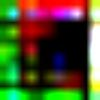
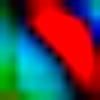
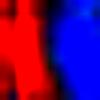
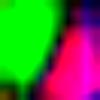
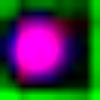
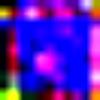
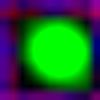
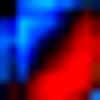
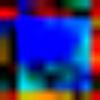
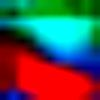
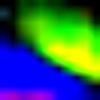
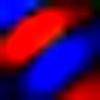
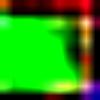
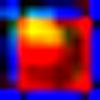
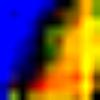
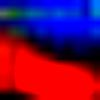
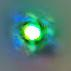
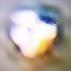
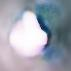
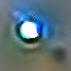
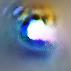
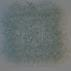
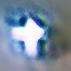
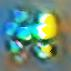
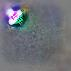
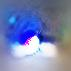
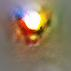
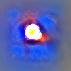
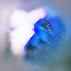
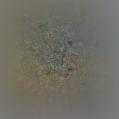
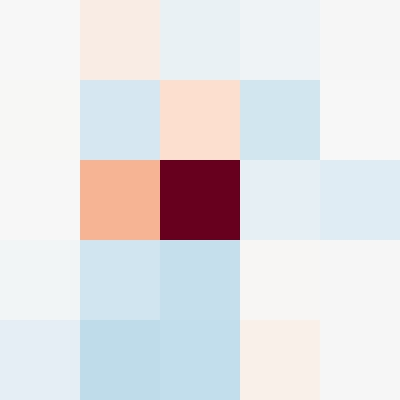
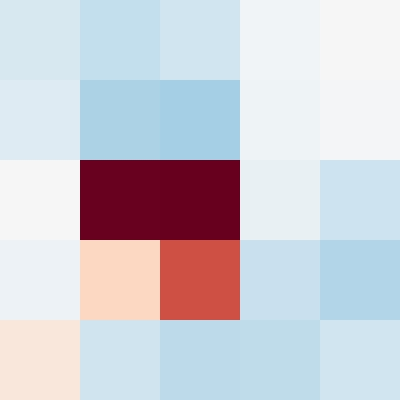
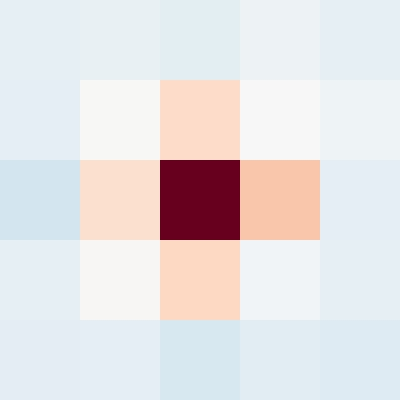
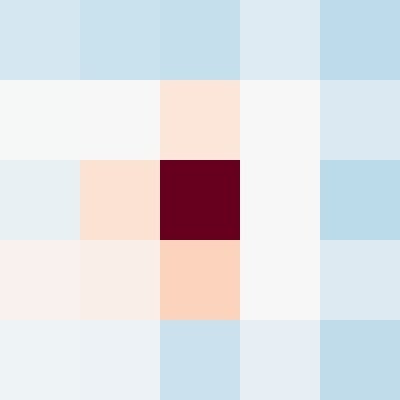
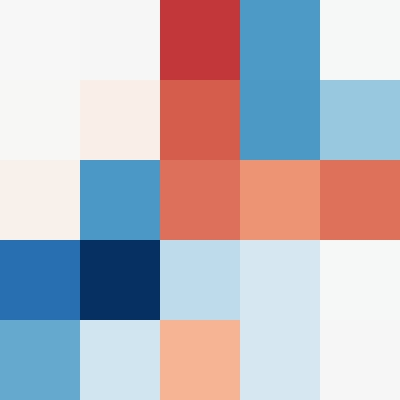
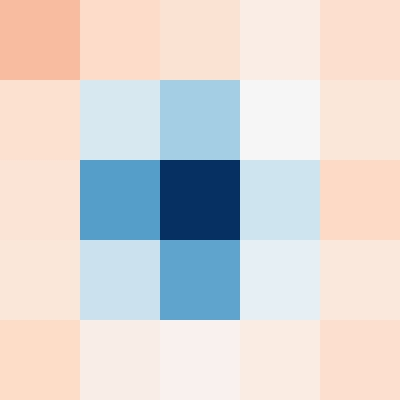
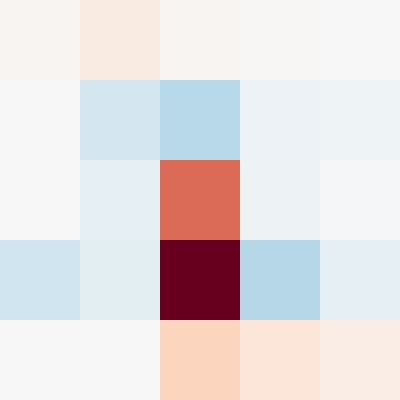
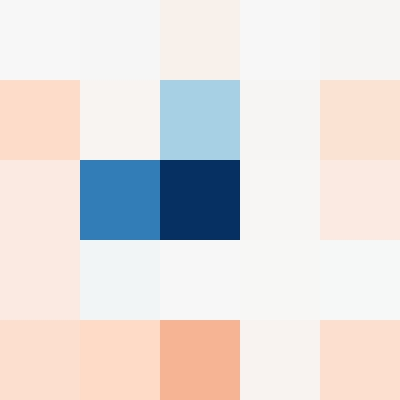
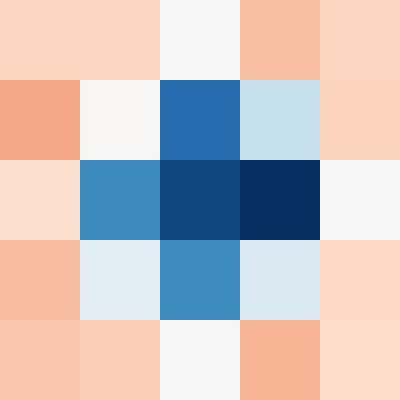
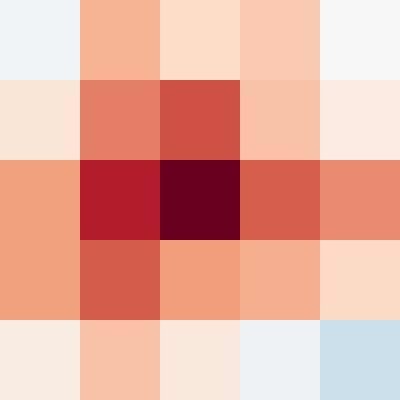
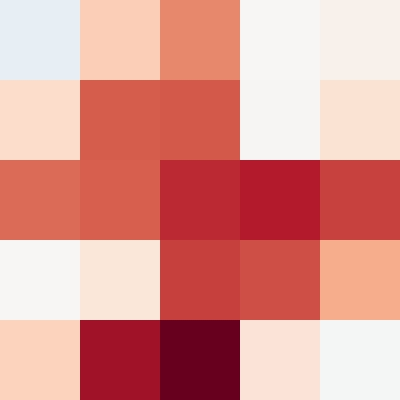
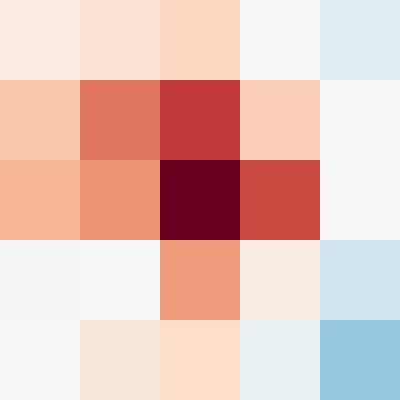
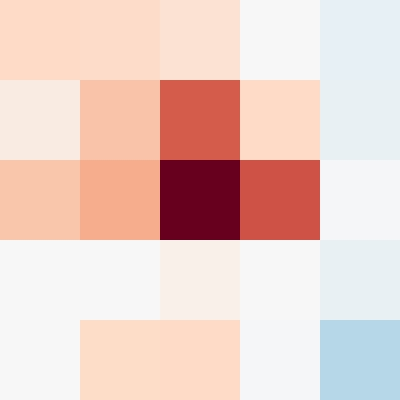
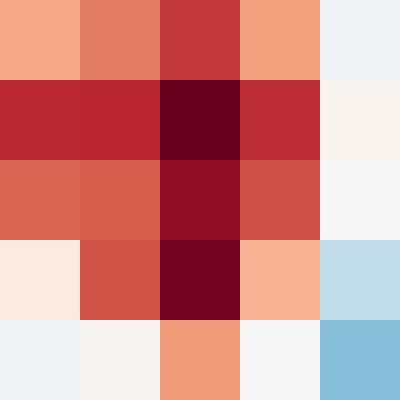
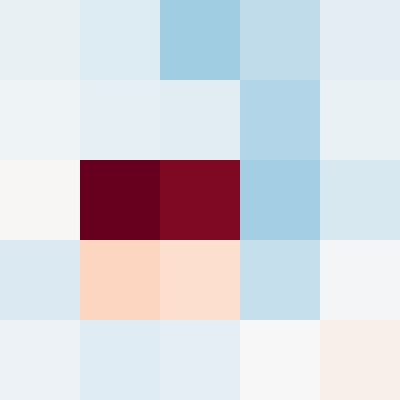
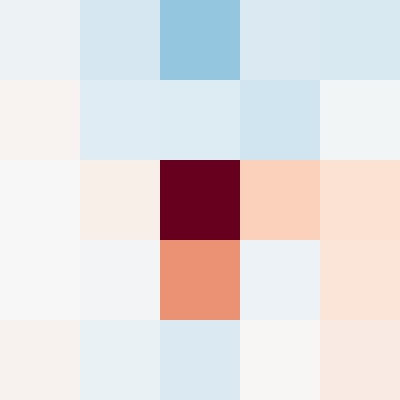
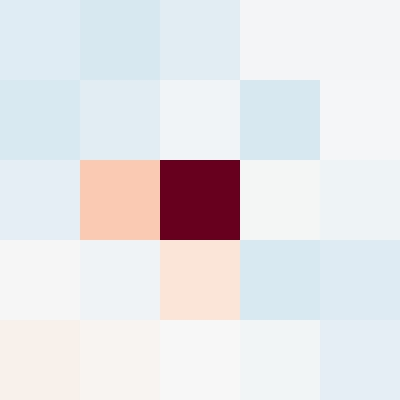
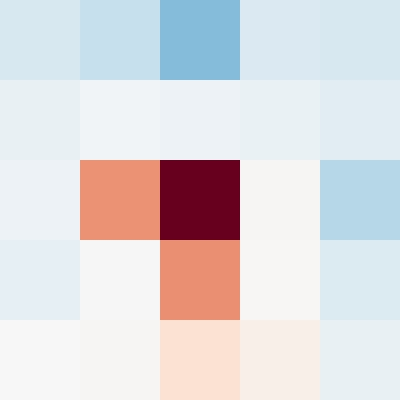
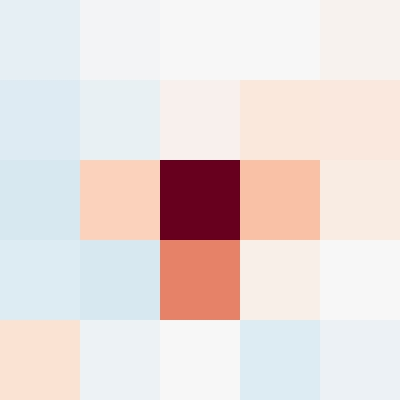
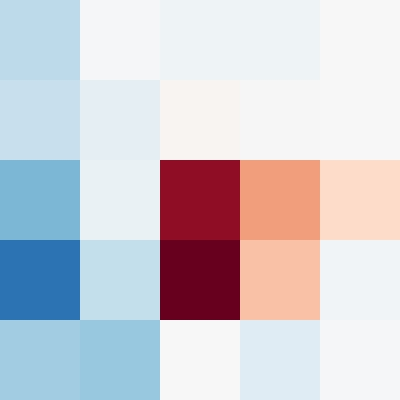
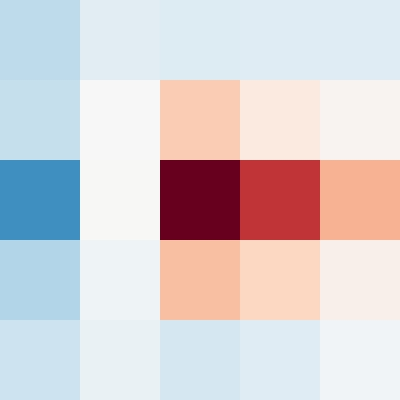
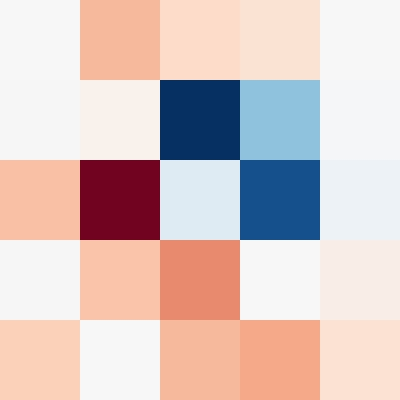
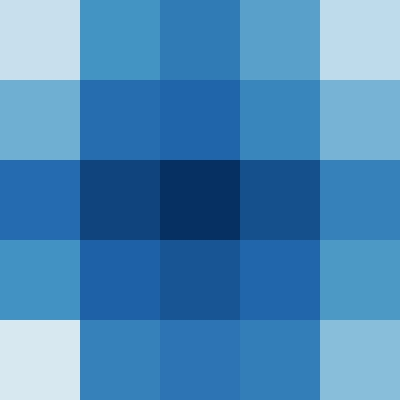
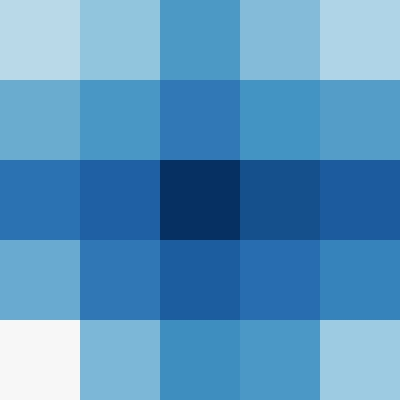
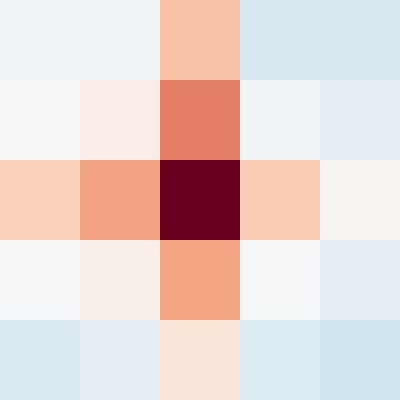
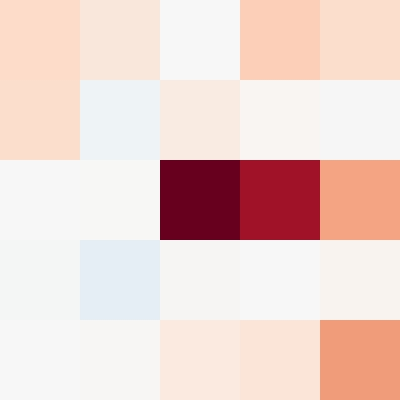
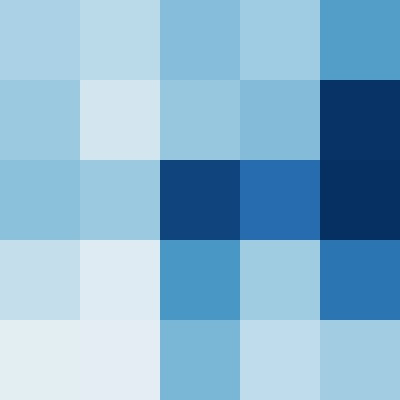
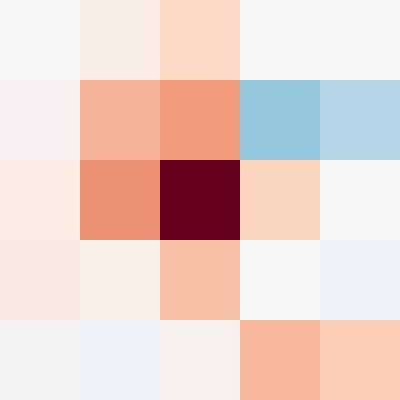
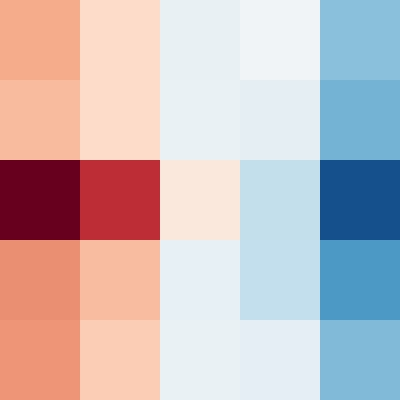
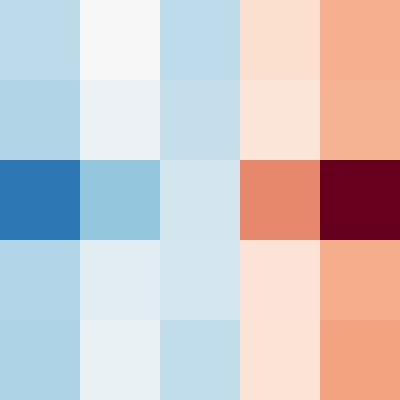
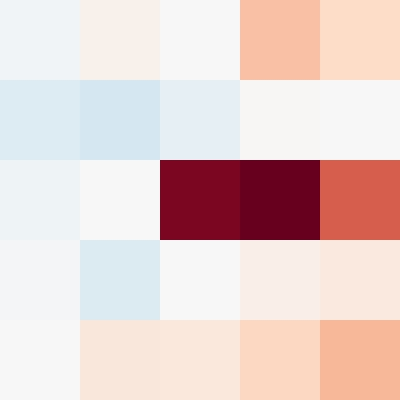
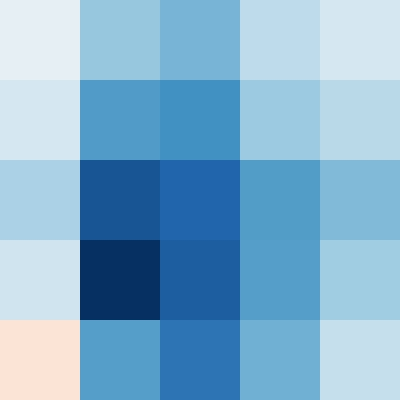
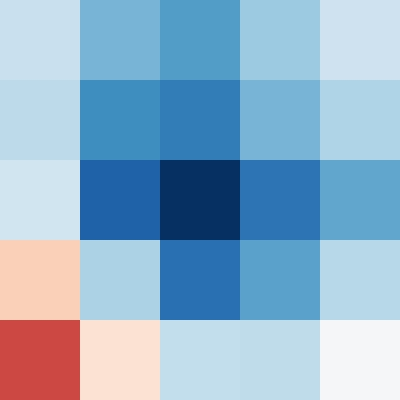
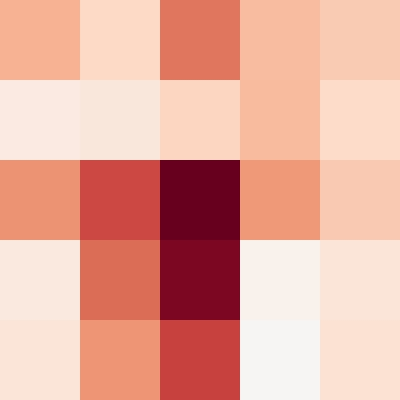
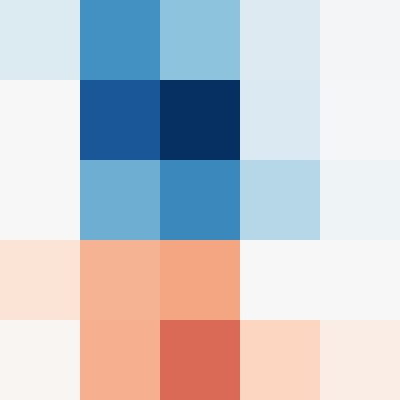
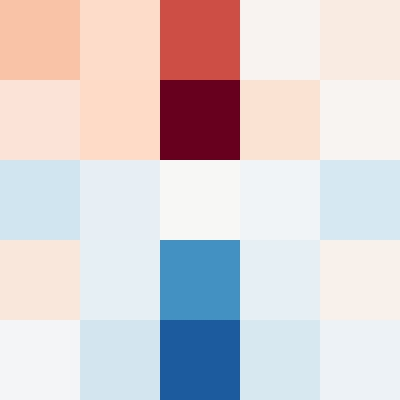
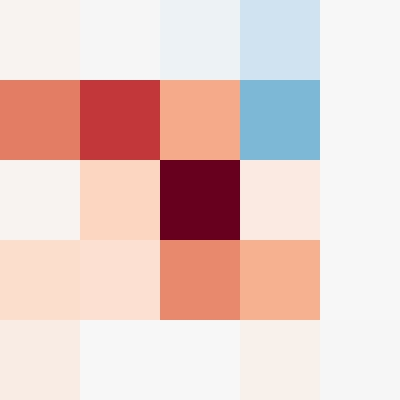
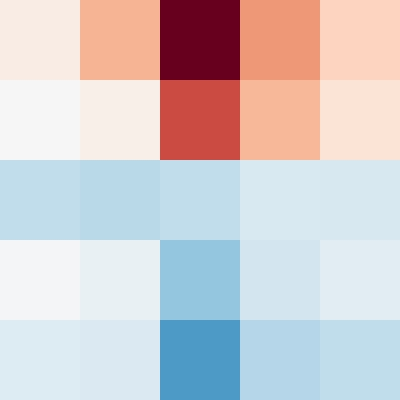
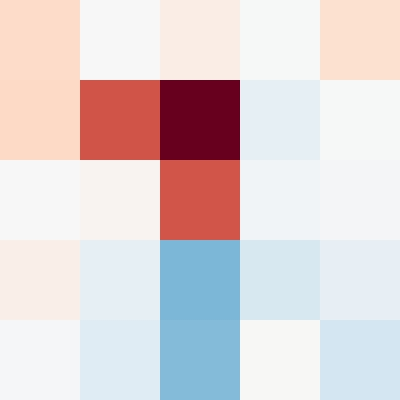
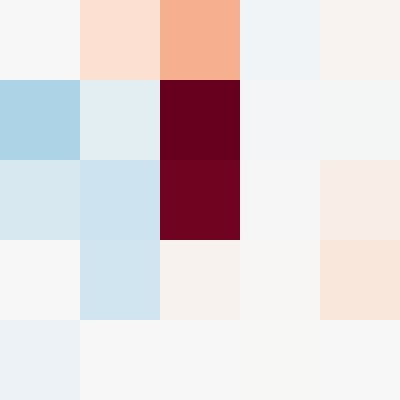
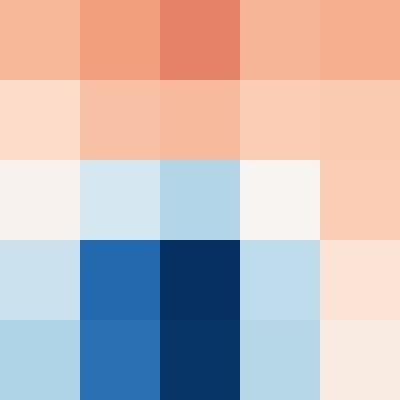
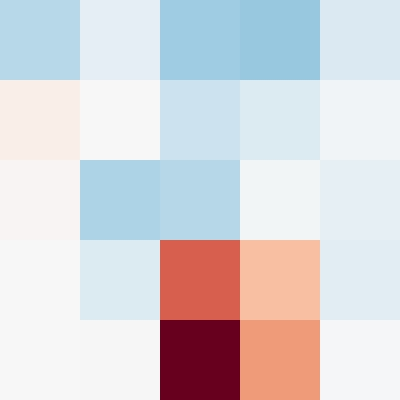
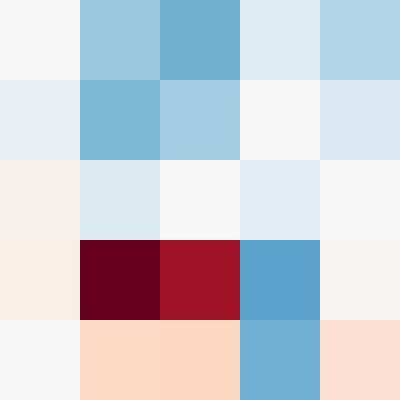
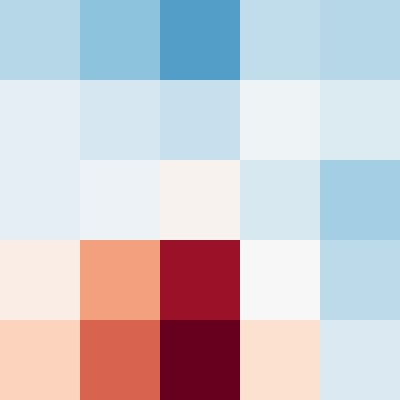
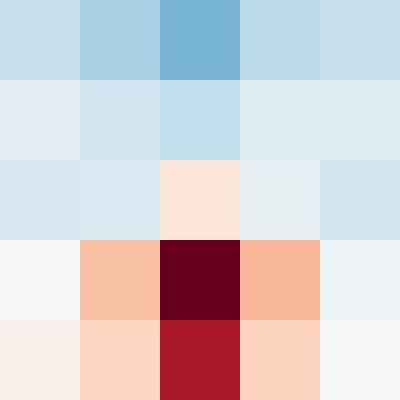
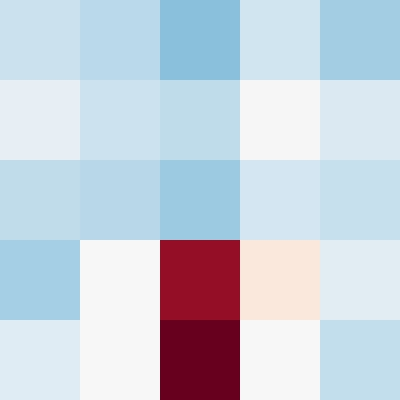
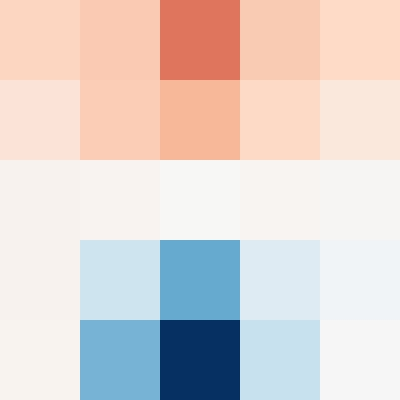
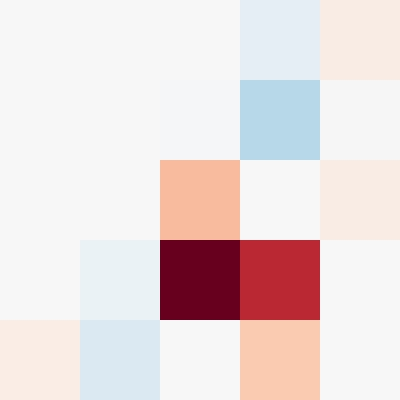
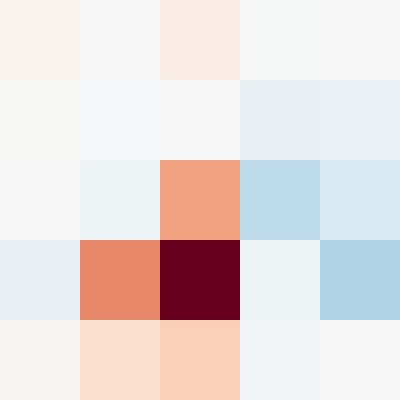
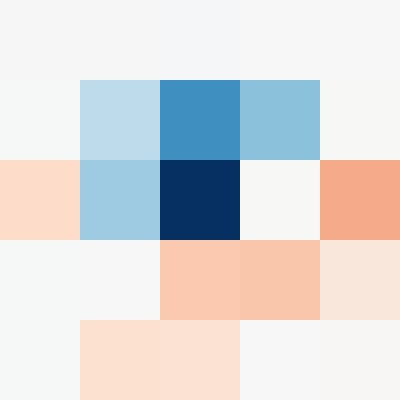
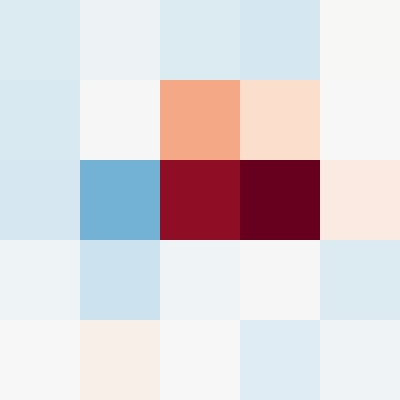
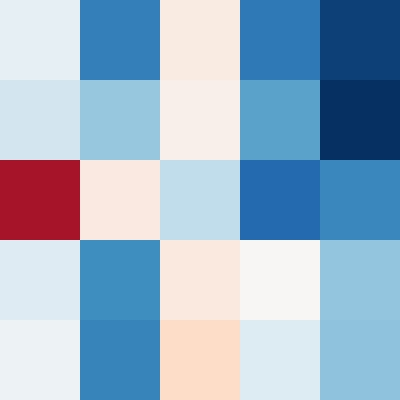
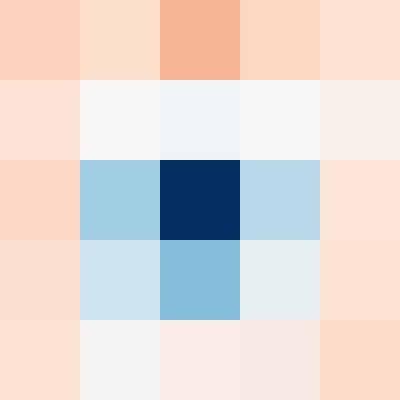
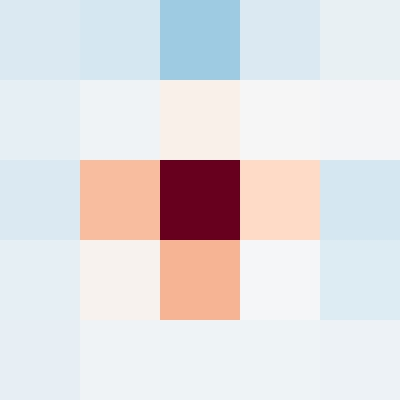
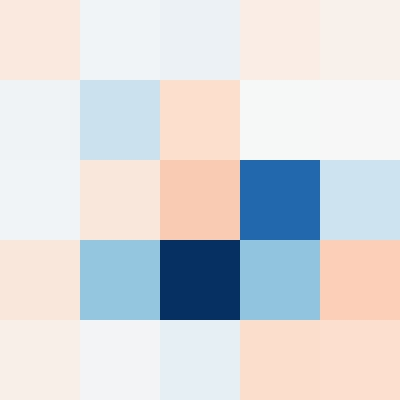
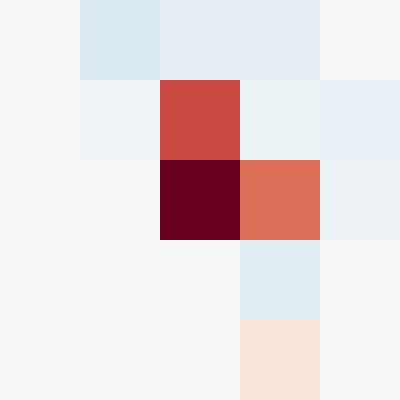
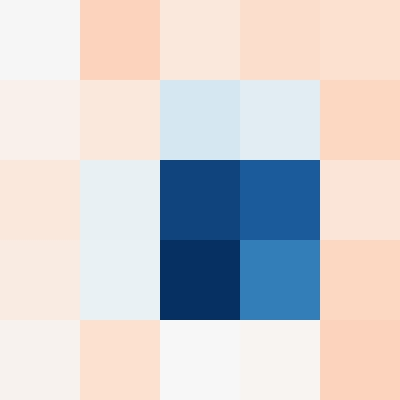
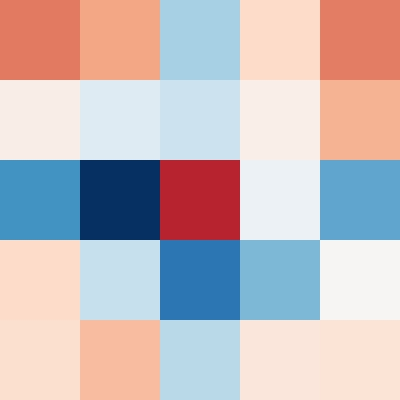
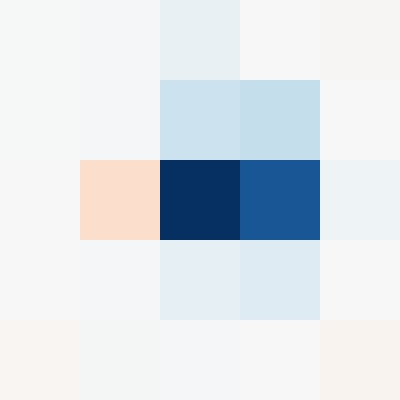
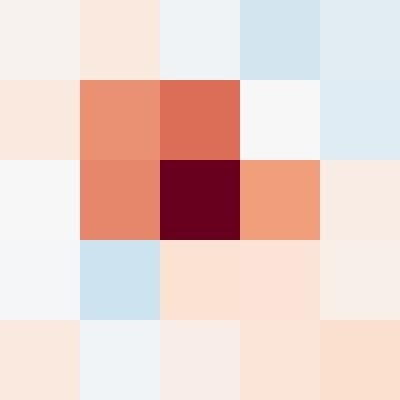
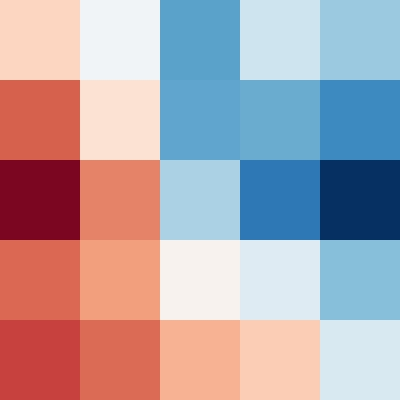
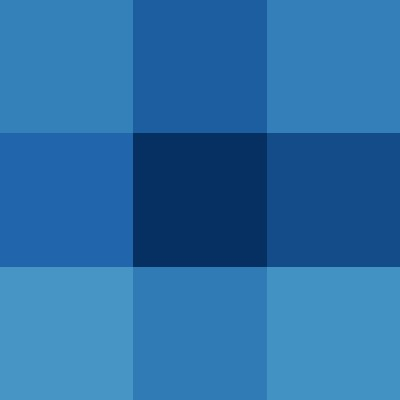
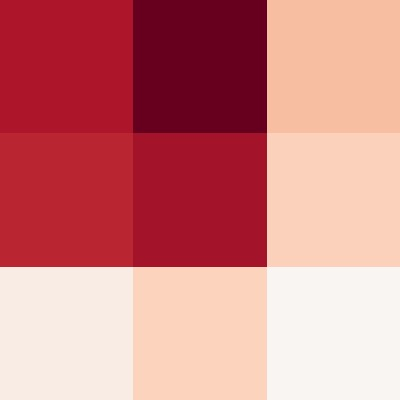
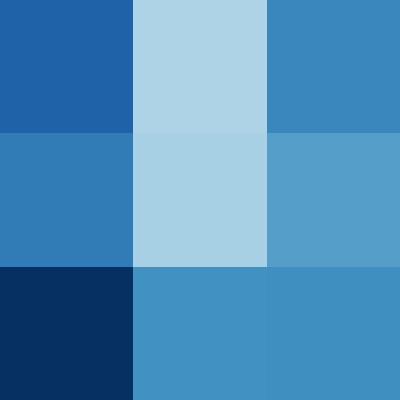
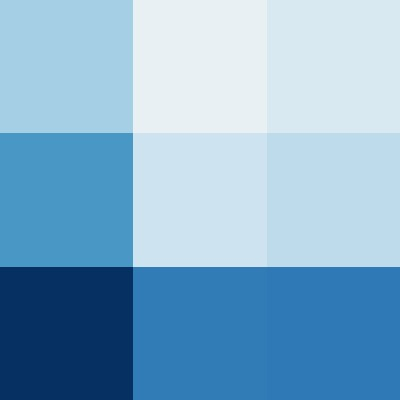
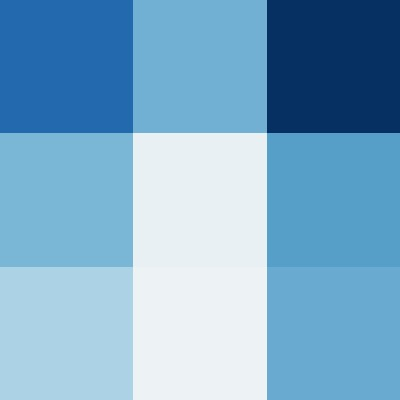
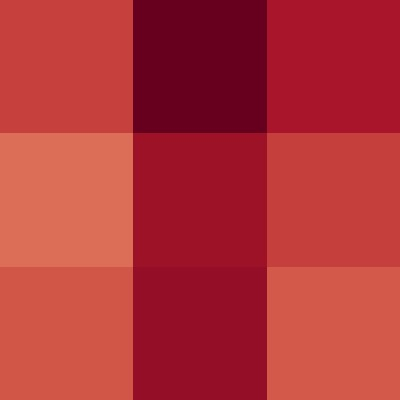
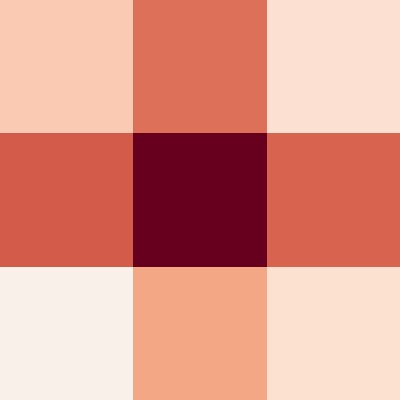
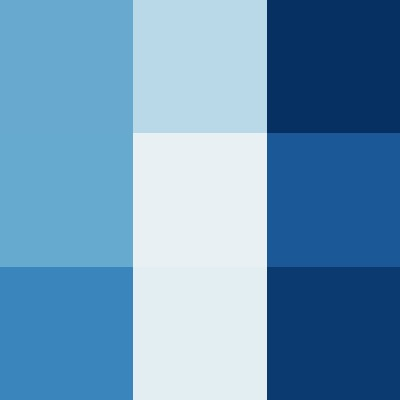
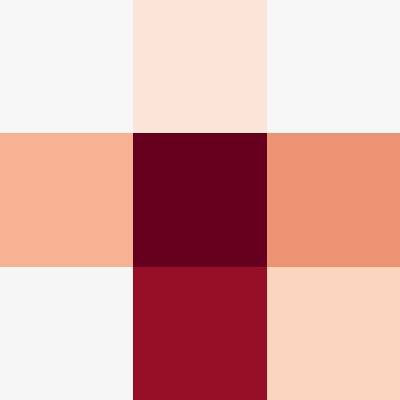
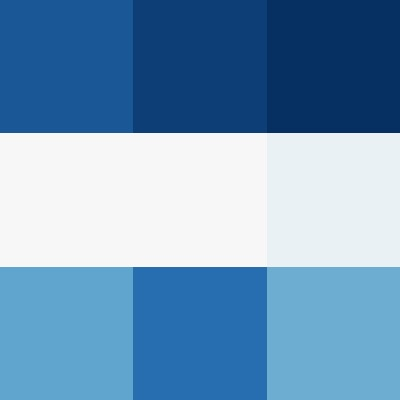
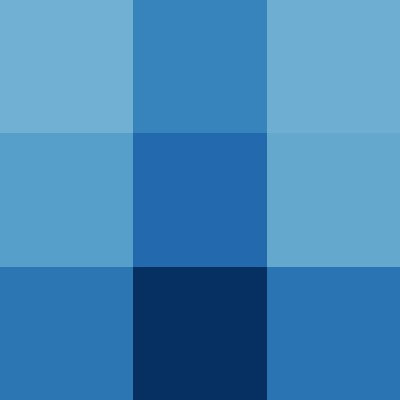
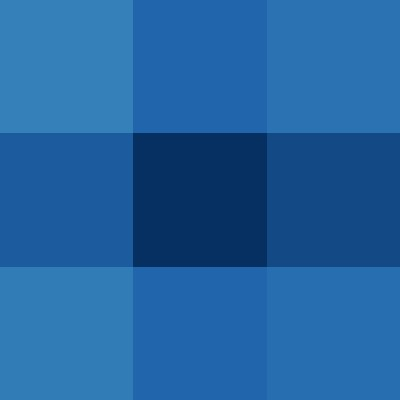
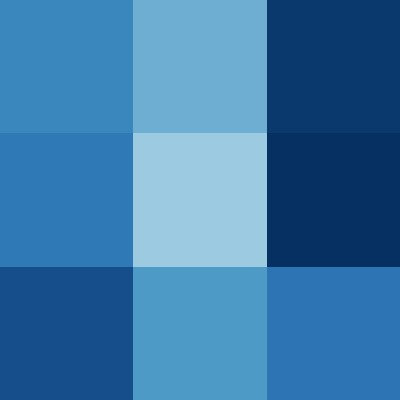

In [34]:
circuit_diagram[0].update_layout(height = 1000, width=2000, showlegend=False)

circuit_diagram[0]


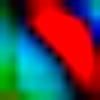
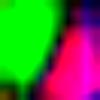
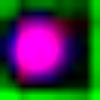
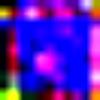
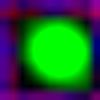
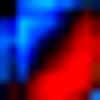
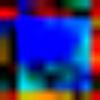
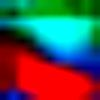
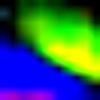
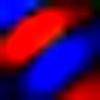
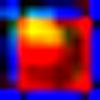
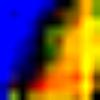
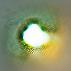
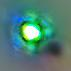
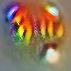
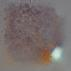
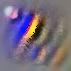
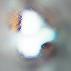
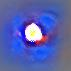
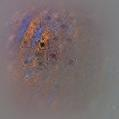
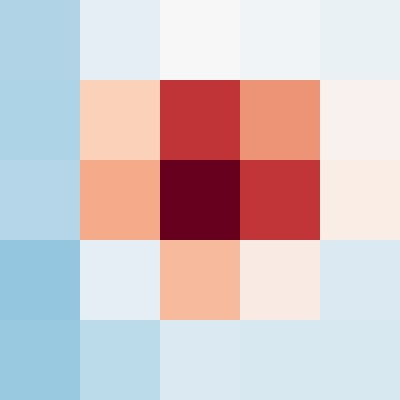
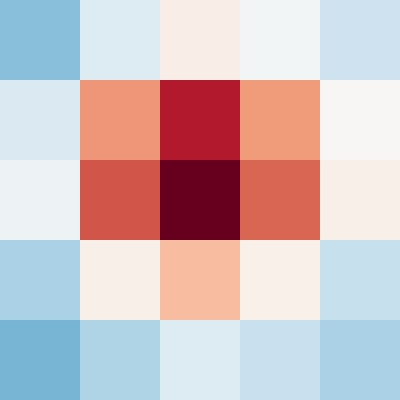
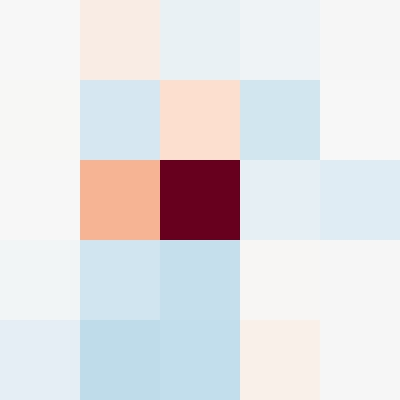
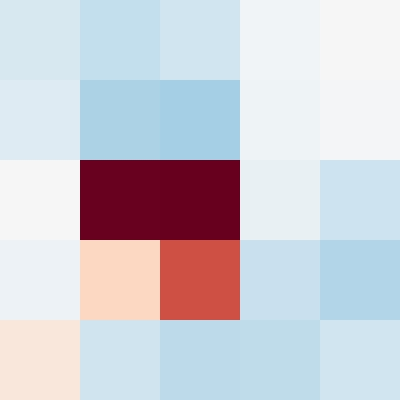
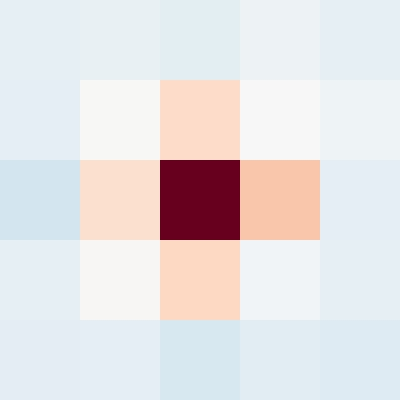
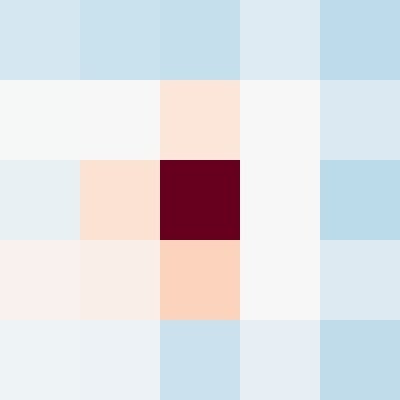
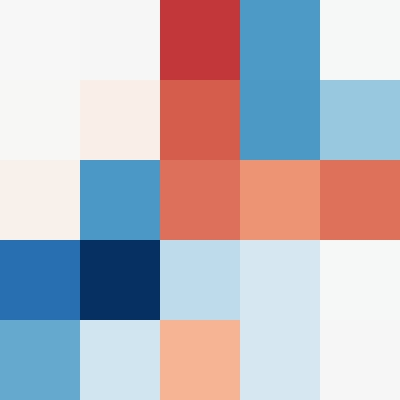
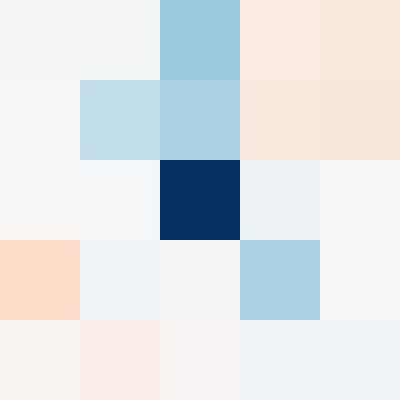
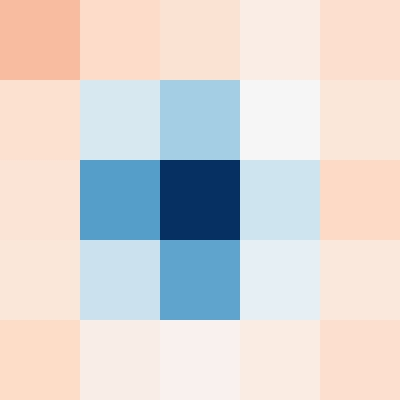
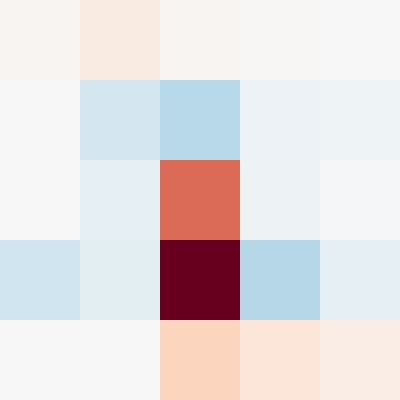
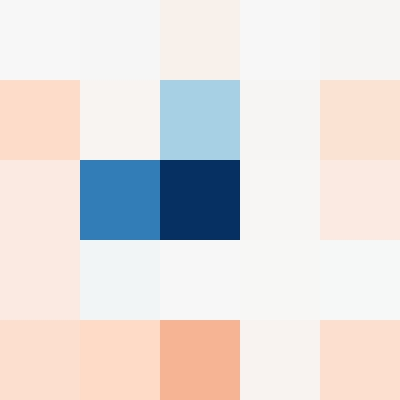
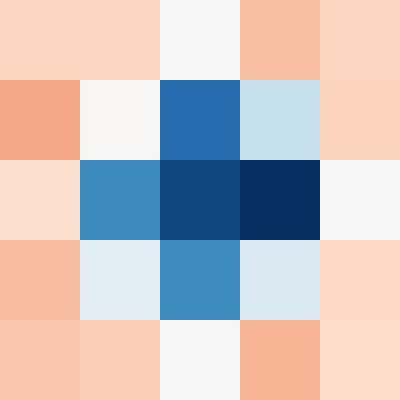
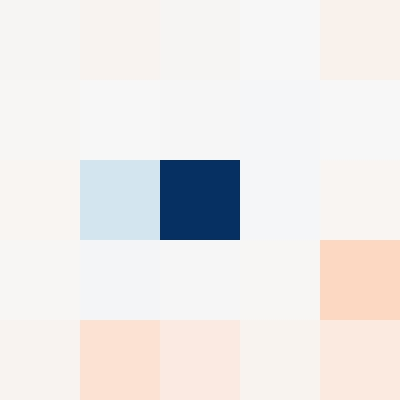
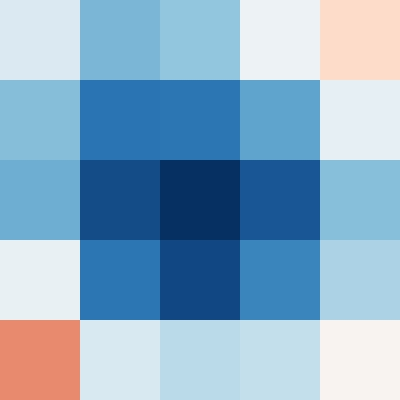
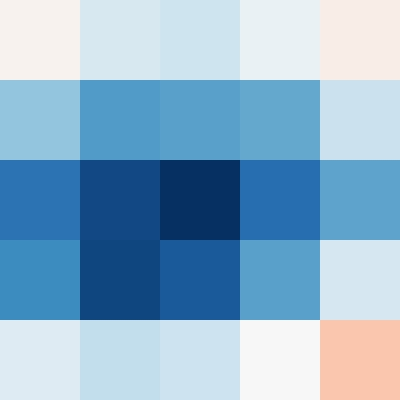
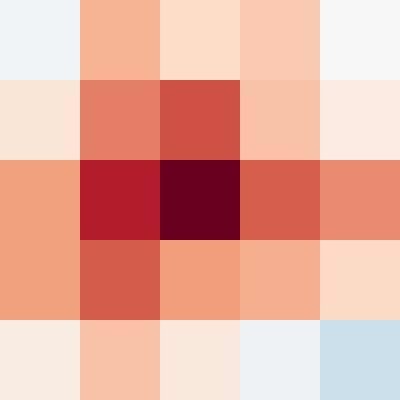
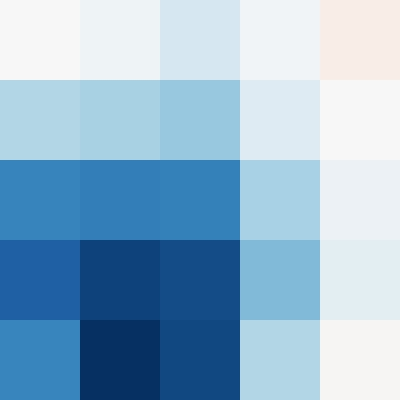
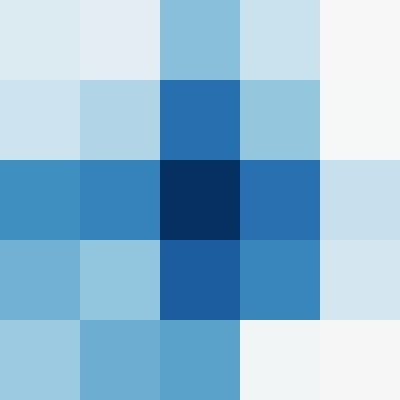
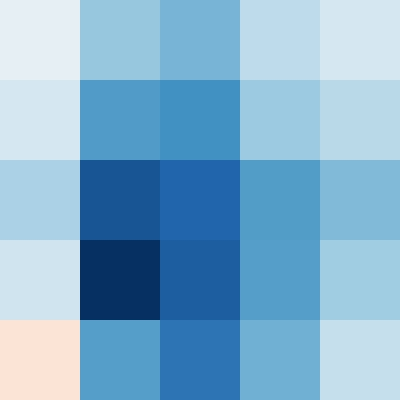
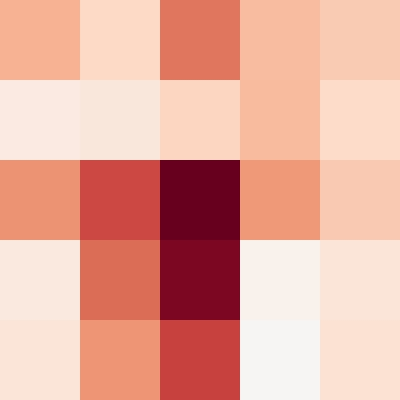
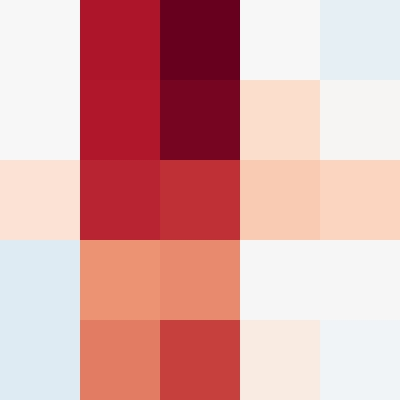
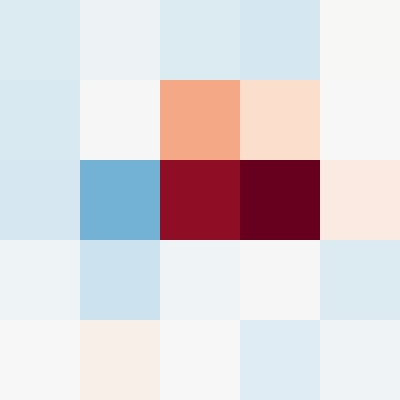
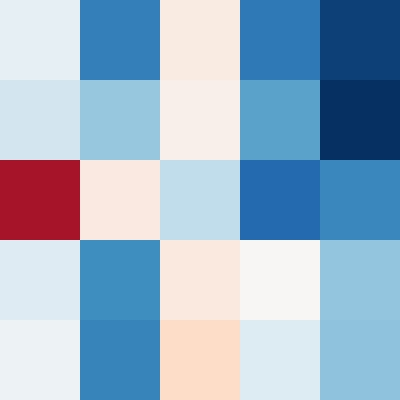
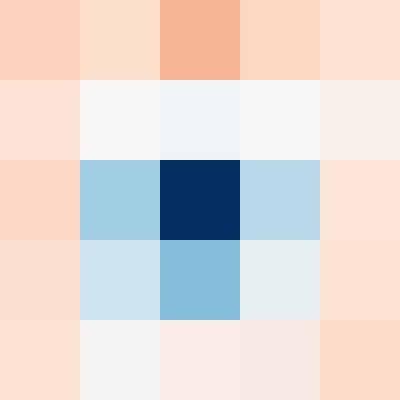
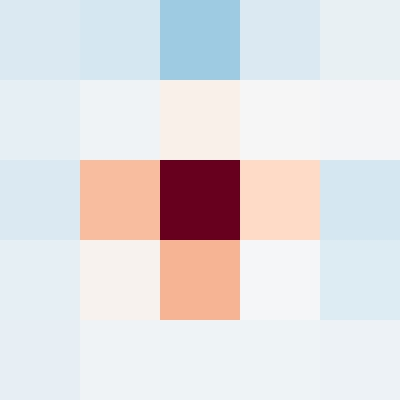
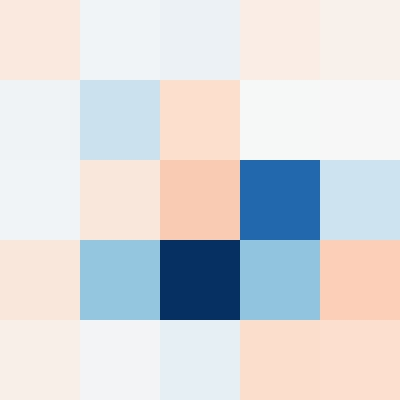
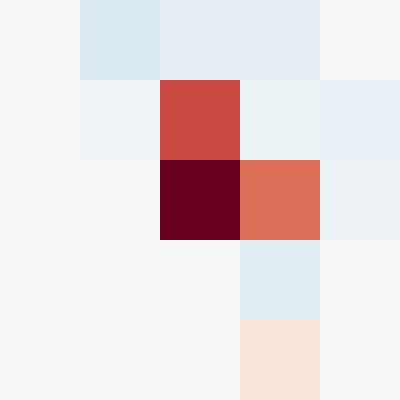
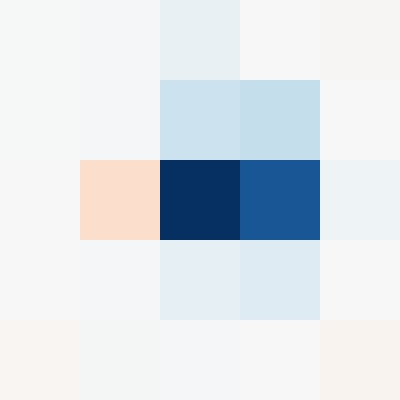
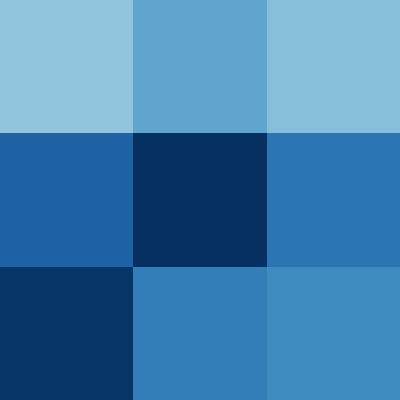
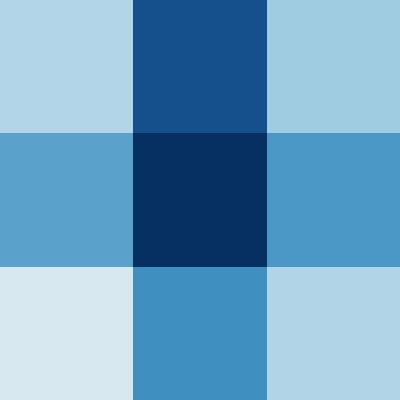
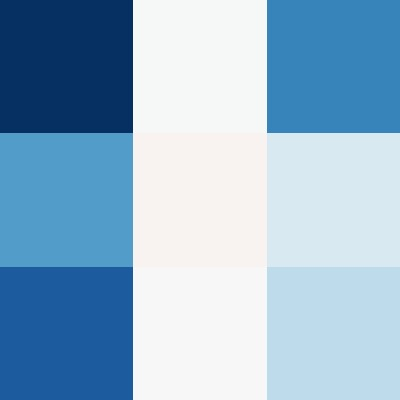
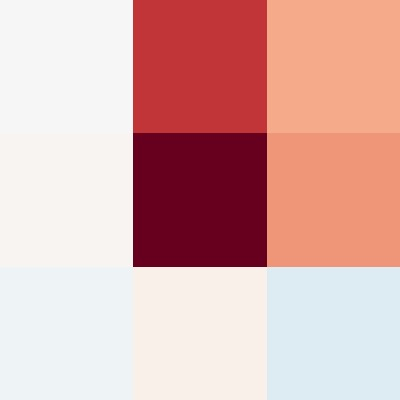
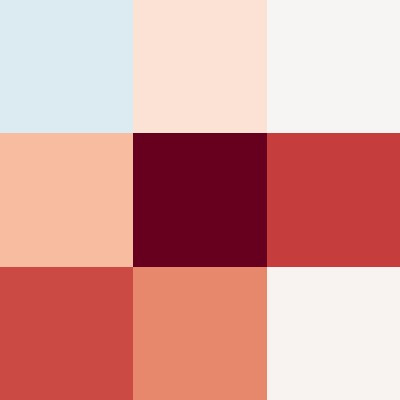
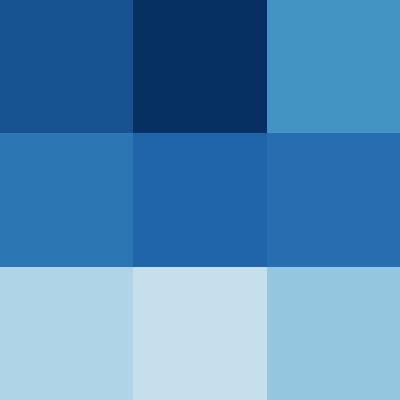
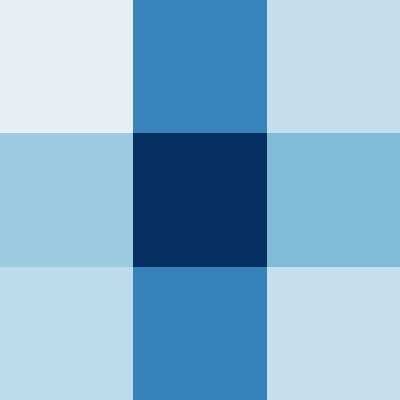

In [40]:
circuit_diagram.update_layout(height = 1000, width=2000, showlegend=False)

circuit_diagram


In [42]:
circuit_diagram.write_html("../../plots/features6:360_circuit_noexhitation_bias.html")

circuit_diagram.write_image("../../plots/features6:360_circuit_noexhitation_bias.png")

#### Exhitation bias

In the above graph, at high sparsities inhibition is clearly a problem, we get a bad final visualization because the target filter has only mostly inhibitive connections. One of the few filters it has positive connections to itself has only inhibitive connections, so it doesnt fire anyway. To alleviate this we introduce an 'exhitation bias' to our saliency scores. this is a hyperparameter that boosts saliency scores that are exhitatory. Importantly, we want to apply this exhitation bias is 'layer-specific', we certainly want exhitation bias for the final filter layer, but it doesnt make as much sense for the first conv layer.

In [75]:
from circuit_pruner.visualizer.utils import get_kernels_Conv2d_modules, gen_kernel_posneg

weights = get_kernels_Conv2d_modules(model,kernels=[])     #weird bug always use kernels=[]
kernel_posneg = gen_kernel_posneg(weights)
print(len(kernel_posneg))
print(kernel_posneg[1].shape)

5
(192, 64)


In [136]:
exhitation_boosts = [1,1.5,10]   # This means the most exhitatory kernel in layer 3 
#will have its saliency score boosted by a factor of 1.5, in layer 2 - 1.2, etc. 


kernel_boosts = []
for i, boost in enumerate(exhitation_boosts):
    #minmax normalizing exhitation/inhibition values between 1 and boost
    kernel_boost = torch.from_numpy((boost-1)*(kernel_posneg[i]-kernel_posneg[i].min())/(kernel_posneg[i].max()-kernel_posneg[i].min())+1)
    kernel_boosts.append(kernel_boost)

In [137]:
#adjust ranks

boosted_ranks = []
for i, rank in enumerate(ranks):
    boosted_ranks.append(torch.mul(kernel_boosts[i],rank))

In [138]:
from circuit_pruner.ranks import minmax_norm_ranks

normed_boosted_ranks = minmax_norm_ranks(boosted_ranks) # so we dont bias the architecture towards the boosted layers


##### redo circuit extraction with boosted ranks

In [139]:
from circuit_pruner.extraction import model_ranks_2_circuit_model


sparsity = .05
kernel_pruned_circuit,kernel_mask = model_ranks_2_circuit_model(normed_boosted_ranks,sparsity,
                                                           model,feature_targets,device,
                                                           structure='kernels',use_effective_mask=True,
                                                           rank_field='image')



features_6 effective last layer
target sparsity: 0.05
total params to feature: 12672

kept params in original mask: 634      (total params * sparsity)
original mask: 20833 params
effective mask: 16066 params
effective_sparsity: 0.034248737373737376


In [140]:
from circuit_pruner.extraction import fill_partial_filters_in_mask, extract_circuit_with_eff_mask


kernel_mask[0] = fill_partial_filters_in_mask(kernel_mask[0])
kernel_pruned_circuit = extract_circuit_with_eff_mask(model,kernel_mask)


No folder specified to store cache of visualizations (in case you want to visualize this circuit again more quickly).                Storing at /mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/visualization_cache/circuit_at_1652371831.240961. You might want to rename this to something sensible if you hold onto this circuit.
already kernel ranks . . .
generating feature_viz objective string for 66
deepviz image not found for 66, generating . . .
generating featviz with objective: features_3:66
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]      

100%|██████████| 512/512 [00:08<00:00, 57.44it/s]



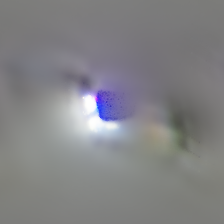

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 67
deepviz image not found for 67, generating . . .
generating featviz with objective: features_3:67
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.03it/s]



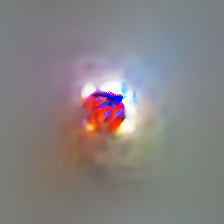

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 69
deepviz image not found for 69, generating . . .
generating featviz with objective: features_3:69
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.77it/s]



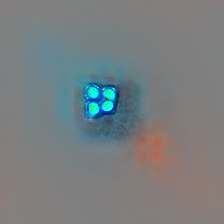

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 70
deepviz image not found for 70, generating . . .
generating featviz with objective: features_3:70
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.03it/s]



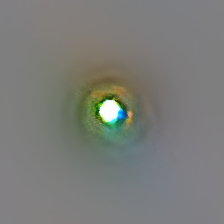

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 75
deepviz image not found for 75, generating . . .
generating featviz with objective: features_3:75
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.60it/s]



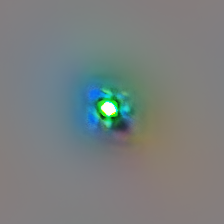

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 77
deepviz image not found for 77, generating . . .
generating featviz with objective: features_3:77
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.61it/s]



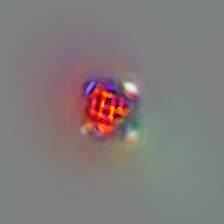

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 78
deepviz image not found for 78, generating . . .
generating featviz with objective: features_3:78
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.71it/s]



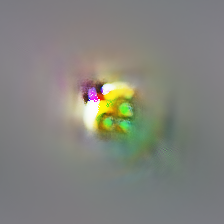

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 80
deepviz image not found for 80, generating . . .
generating featviz with objective: features_3:80
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.25it/s]



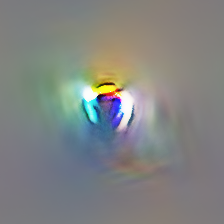

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 86
deepviz image not found for 86, generating . . .
generating featviz with objective: features_3:86
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.24it/s]



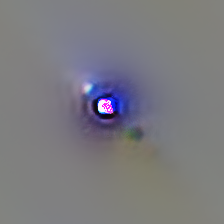

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 87
deepviz image not found for 87, generating . . .
generating featviz with objective: features_3:87
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.98it/s]



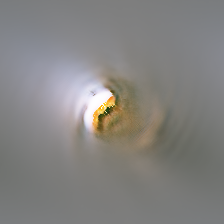

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 90
deepviz image not found for 90, generating . . .
generating featviz with objective: features_3:90
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.07it/s]



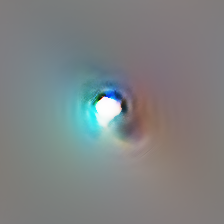

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 96
deepviz image not found for 96, generating . . .
generating featviz with objective: features_3:96
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.41it/s]



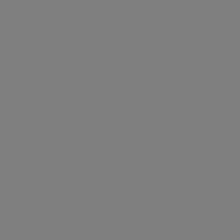

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 102
deepviz image not found for 102, generating . . .
generating featviz with objective: features_3:102
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.88it/s]



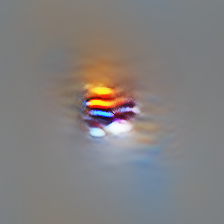

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 107
deepviz image not found for 107, generating . . .
generating featviz with objective: features_3:107
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.80it/s]



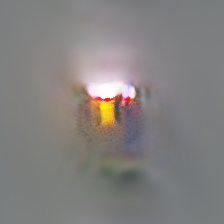

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 119
deepviz image not found for 119, generating . . .
generating featviz with objective: features_3:119
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.17it/s]



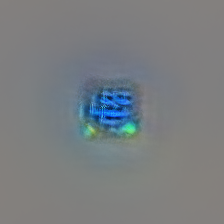

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 120
deepviz image not found for 120, generating . . .
generating featviz with objective: features_3:120
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.02it/s]



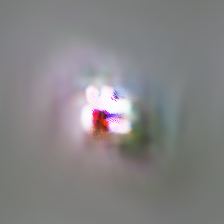

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 124
deepviz image not found for 124, generating . . .
generating featviz with objective: features_3:124
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:06<00:00, 73.29it/s]



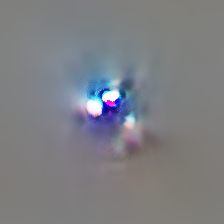

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 130
deepviz image not found for 130, generating . . .
generating featviz with objective: features_3:130
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.26it/s]



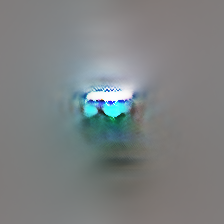

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 141
deepviz image not found for 141, generating . . .
generating featviz with objective: features_3:141
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.77it/s]



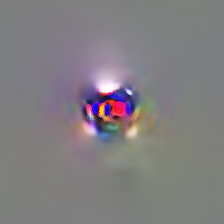

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 149
deepviz image not found for 149, generating . . .
generating featviz with objective: features_3:149
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 59.37it/s]



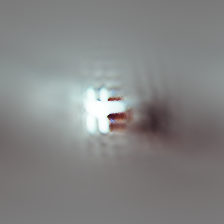

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 153
deepviz image not found for 153, generating . . .
generating featviz with objective: features_3:153
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.28it/s]



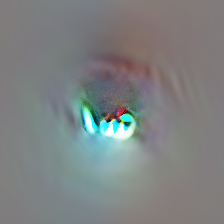

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 157
deepviz image not found for 157, generating . . .
generating featviz with objective: features_3:157
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.58it/s]



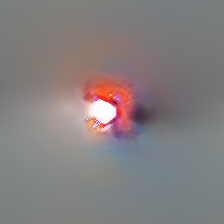

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 159
deepviz image not found for 159, generating . . .
generating featviz with objective: features_3:159
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.40it/s]



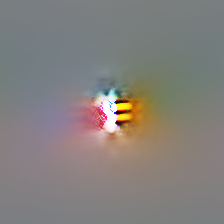

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 165
deepviz image not found for 165, generating . . .
generating featviz with objective: features_3:165
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.22it/s]



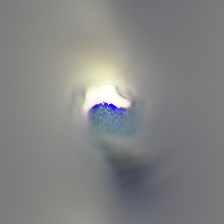

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 171
deepviz image not found for 171, generating . . .
generating featviz with objective: features_3:171
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.24it/s]



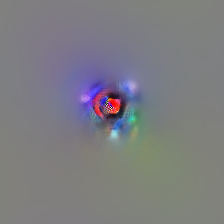

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 172
deepviz image not found for 172, generating . . .
generating featviz with objective: features_3:172
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.81it/s]



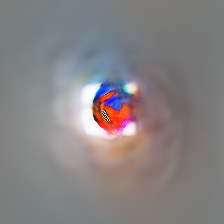

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 176
deepviz image not found for 176, generating . . .
generating featviz with objective: features_3:176
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.92it/s]



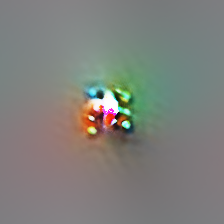

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 178
deepviz image not found for 178, generating . . .
generating featviz with objective: features_3:178
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.88it/s]



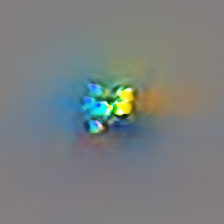

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 182
deepviz image not found for 182, generating . . .
generating featviz with objective: features_3:182
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.60it/s]



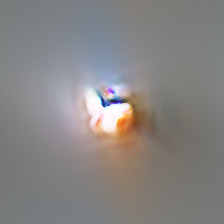

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 186
deepviz image not found for 186, generating . . .
generating featviz with objective: features_3:186
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.29it/s]



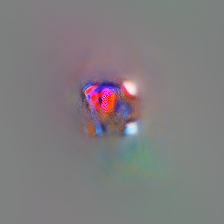

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 188
deepviz image not found for 188, generating . . .
generating featviz with objective: features_3:188
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.20it/s]



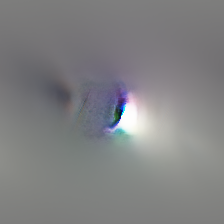

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 189
deepviz image not found for 189, generating . . .
generating featviz with objective: features_3:189
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.61it/s]



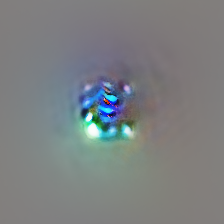

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 191
deepviz image not found for 191, generating . . .
generating featviz with objective: features_3:191
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.35it/s]



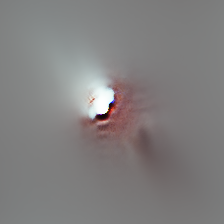

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 192
deepviz image not found for 192, generating . . .
generating featviz with objective: features_3:192
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.02it/s]



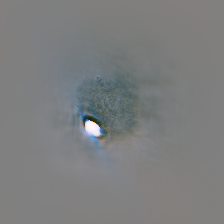

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 196
deepviz image not found for 196, generating . . .
generating featviz with objective: features_3:196
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.76it/s]



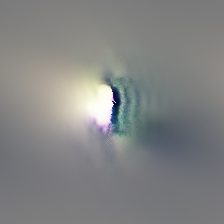

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 198
deepviz image not found for 198, generating . . .
generating featviz with objective: features_3:198
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.77it/s]



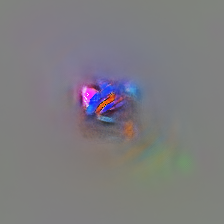

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 208
deepviz image not found for 208, generating . . .
generating featviz with objective: features_3:208
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:09<00:00, 56.82it/s]



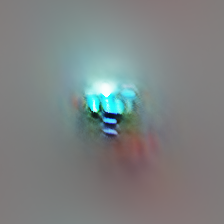

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 214
deepviz image not found for 214, generating . . .
generating featviz with objective: features_3:214
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.55it/s]



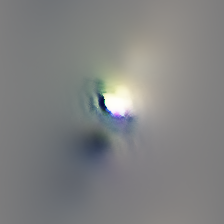

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 216
deepviz image not found for 216, generating . . .
generating featviz with objective: features_3:216
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.61it/s]



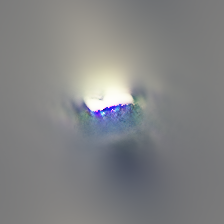

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 218
deepviz image not found for 218, generating . . .
generating featviz with objective: features_3:218
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.23it/s]



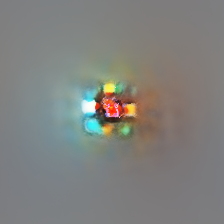

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 222
deepviz image not found for 222, generating . . .
generating featviz with objective: features_3:222
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.29it/s]



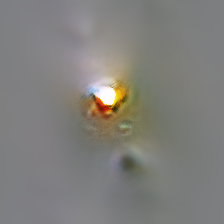

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 235
deepviz image not found for 235, generating . . .
generating featviz with objective: features_3:235
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.20it/s]



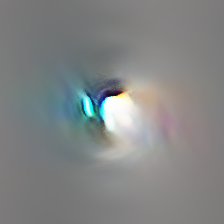

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 238
deepviz image not found for 238, generating . . .
generating featviz with objective: features_3:238
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.16it/s]



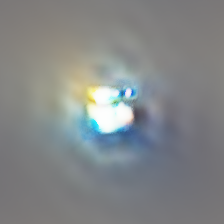

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 239
deepviz image not found for 239, generating . . .
generating featviz with objective: features_3:239
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.31it/s]



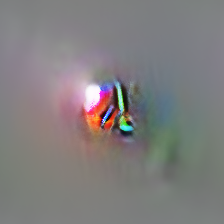

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 241
deepviz image not found for 241, generating . . .
generating featviz with objective: features_3:241
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 56.92it/s]



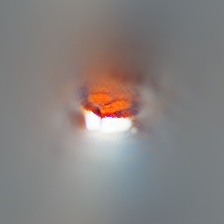

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 244
deepviz image not found for 244, generating . . .
generating featviz with objective: features_3:244
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.25it/s]



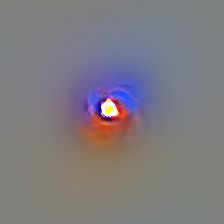

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 616
deepviz image not found for 616, generating . . .
generating featviz with objective: features_6:616
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:09<00:00, 54.39it/s]



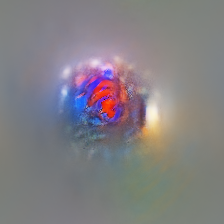

(13, 13)
(6, 6)
[(62.0, 161.0), (62.0, 161.0)]


In [141]:
circuit_diagram = launch_circuit_gui(kernel_pruned_circuit,kernel_mask,model,normed_boosted_ranks,interactive=False,device=device)


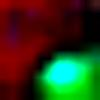
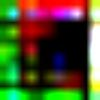
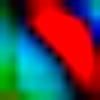
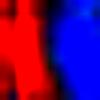
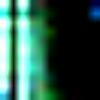
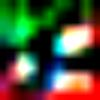
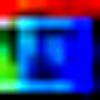
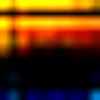
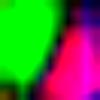
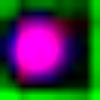
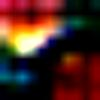
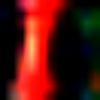
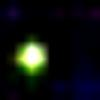
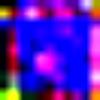
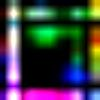
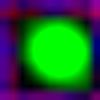
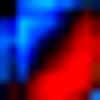
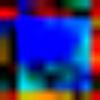
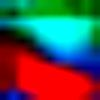
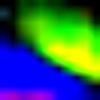
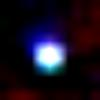
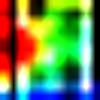
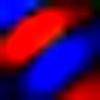
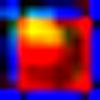
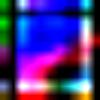
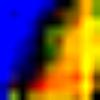
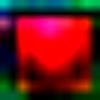
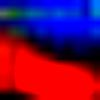
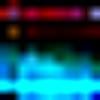
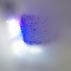
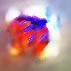
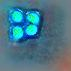
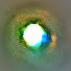
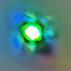
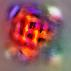
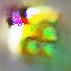
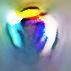
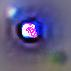
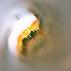
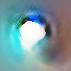
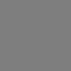
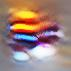
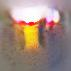
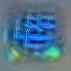
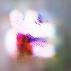
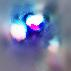
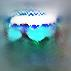
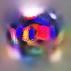
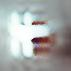
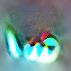
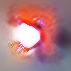
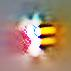
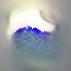
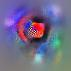
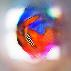
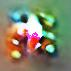
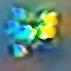
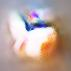
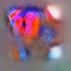
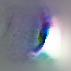
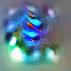
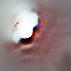
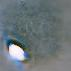
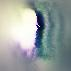
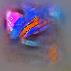
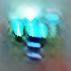
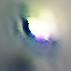
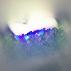
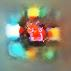
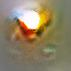
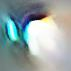
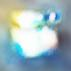
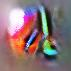
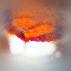
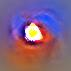
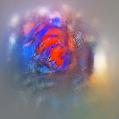
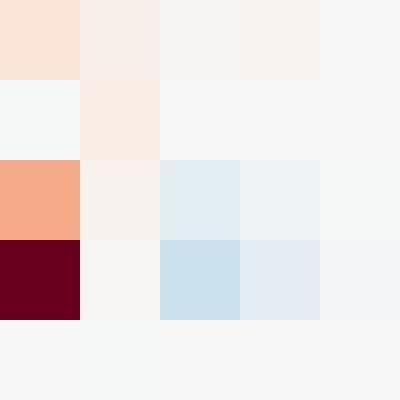
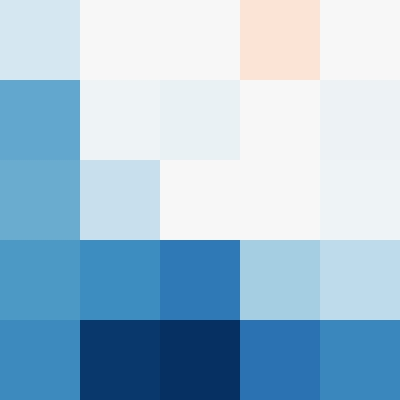
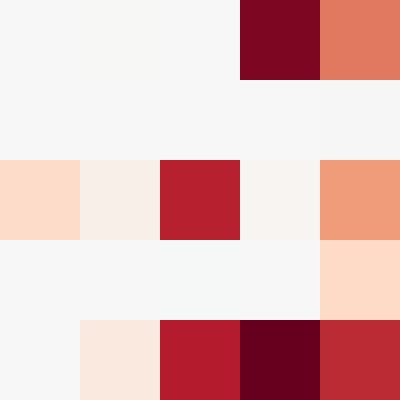
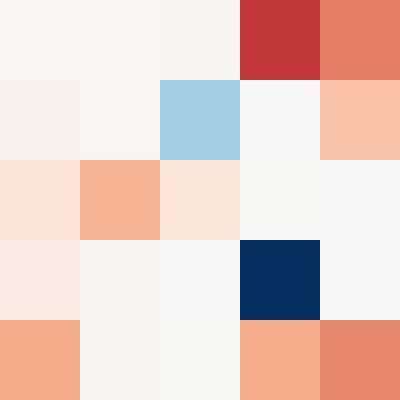
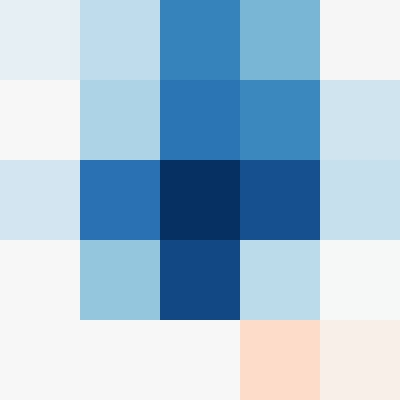
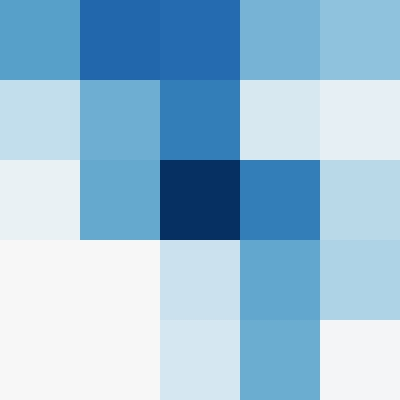
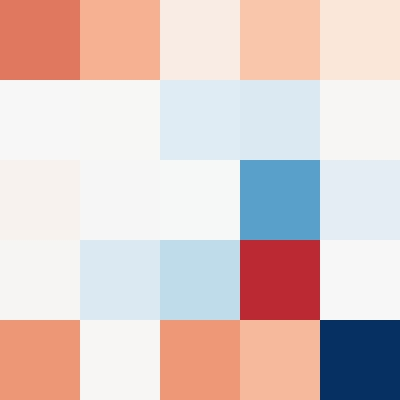
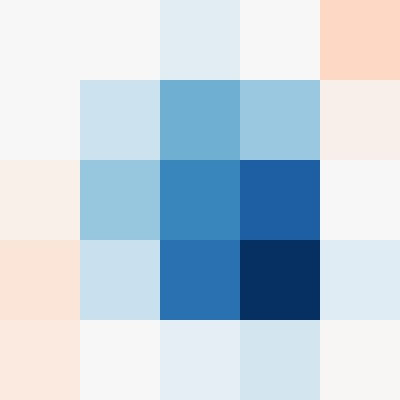
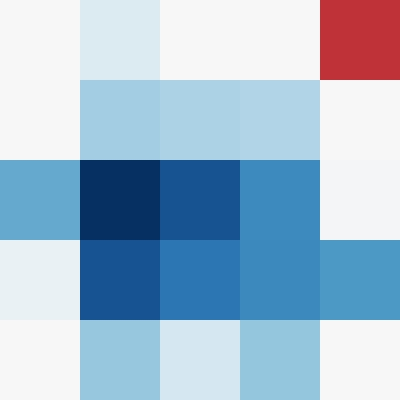
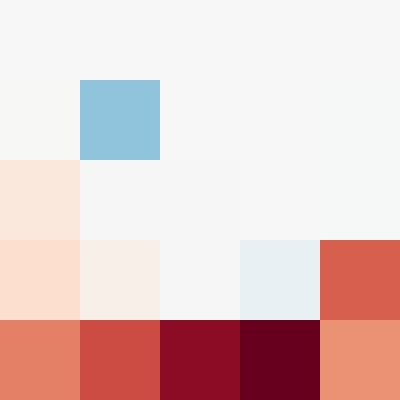
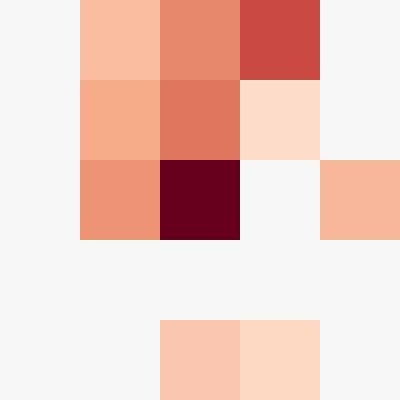
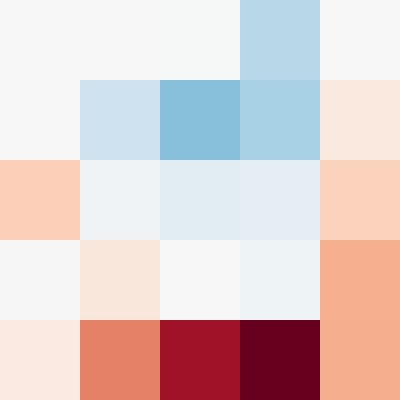
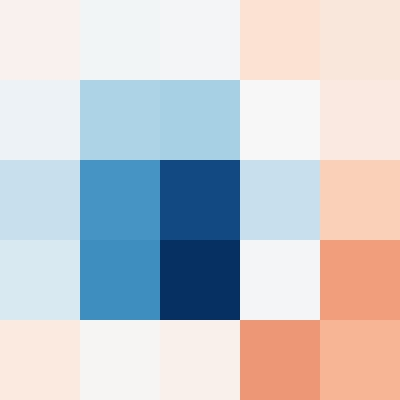
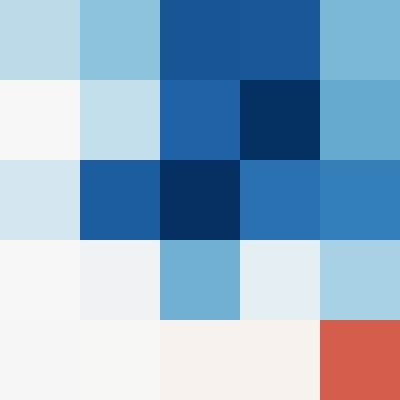
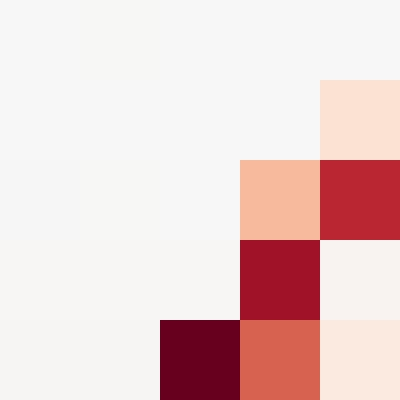
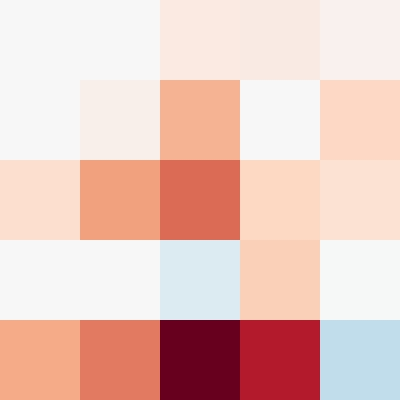
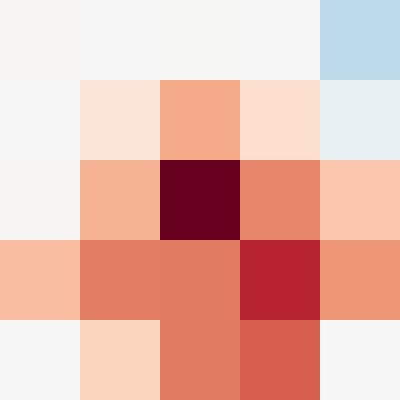
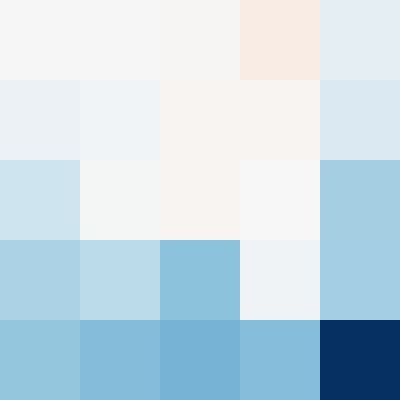
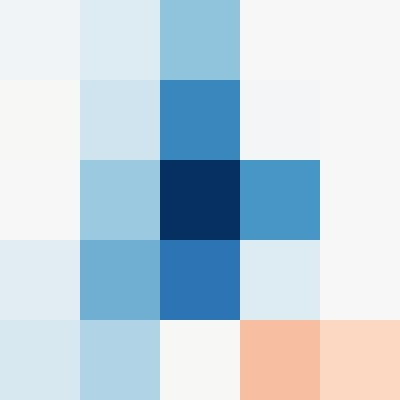
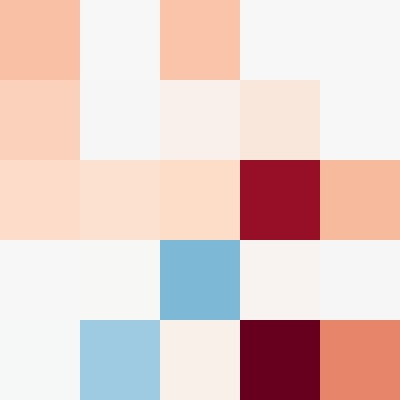
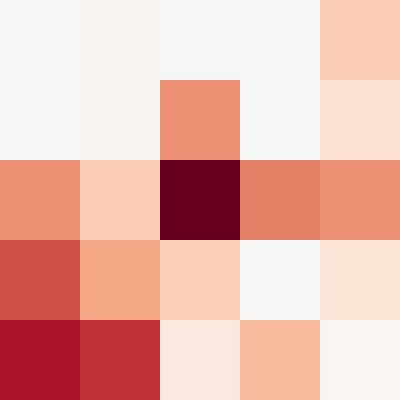
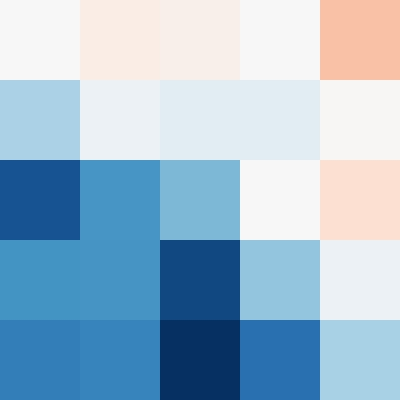
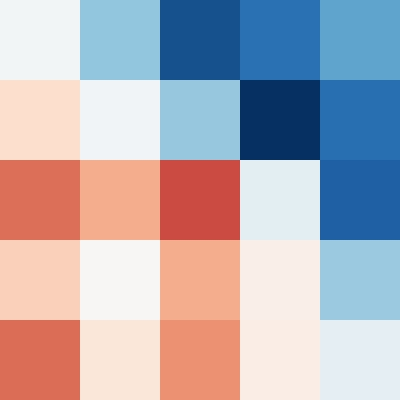
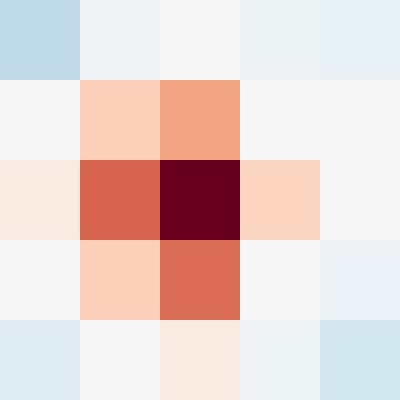
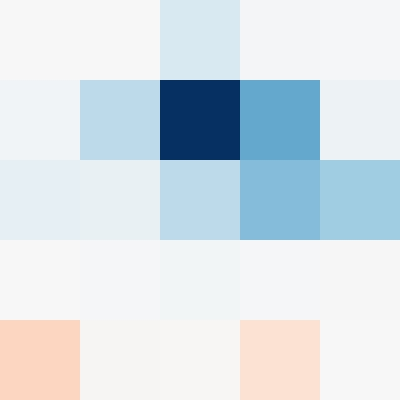
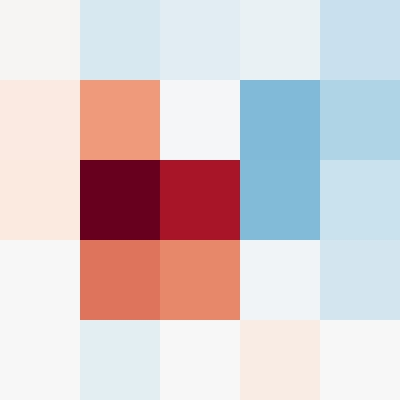
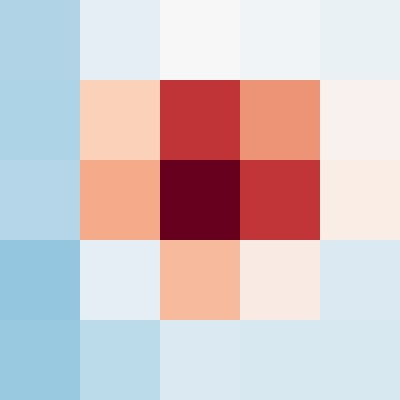
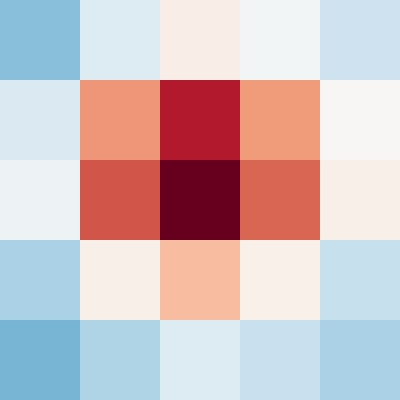
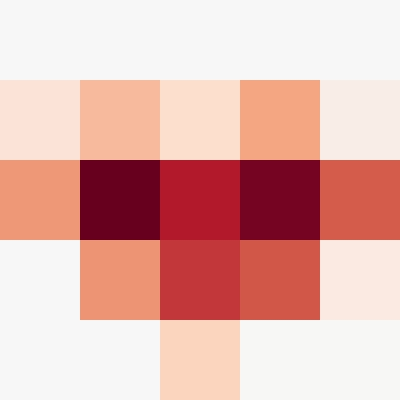
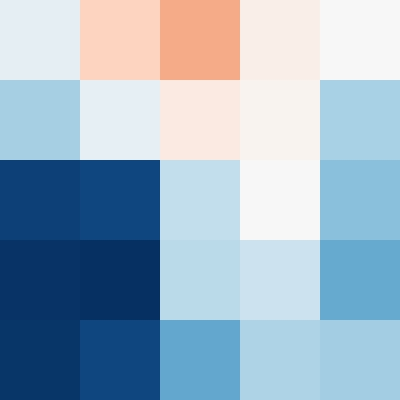
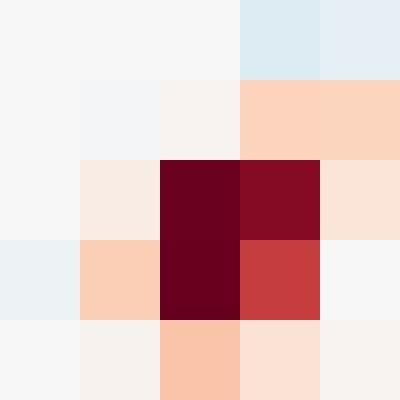
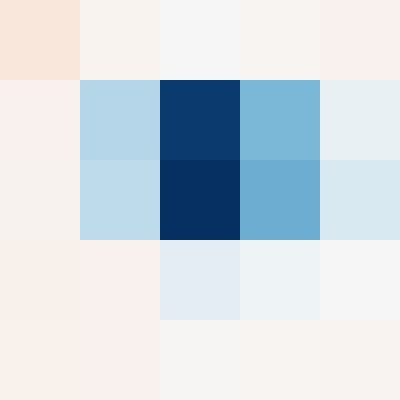
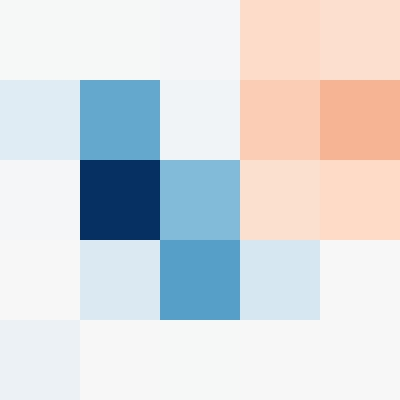
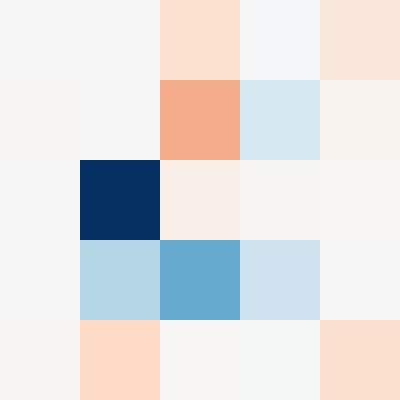
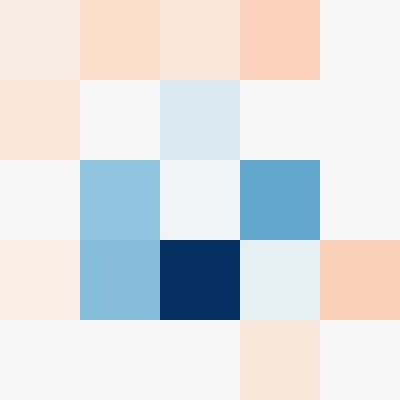
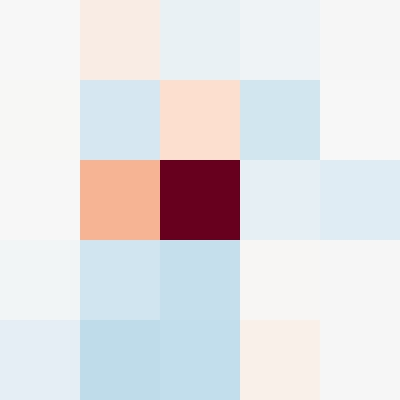
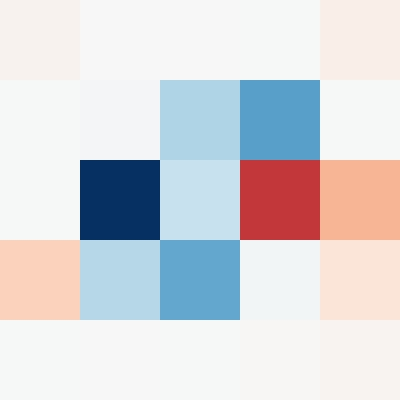
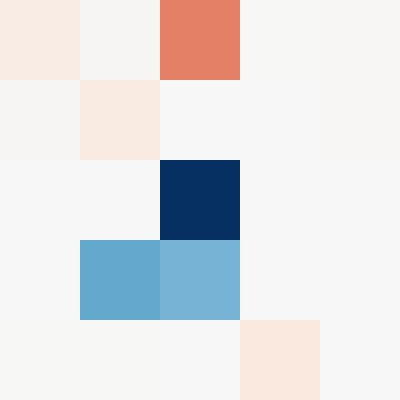
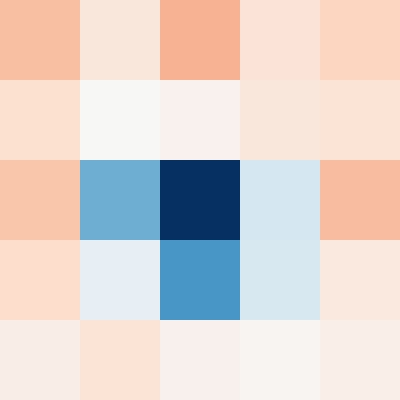
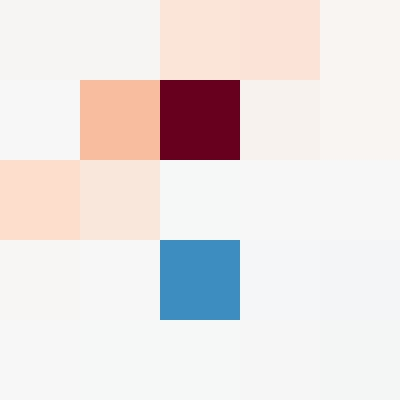
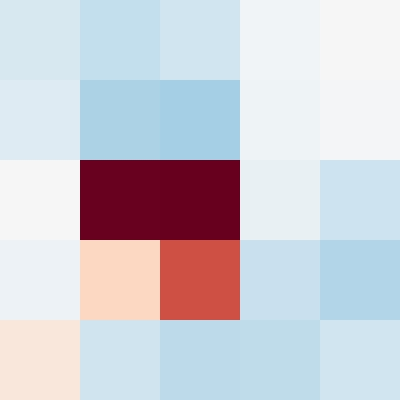
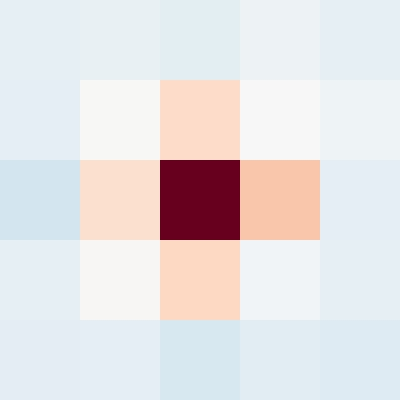
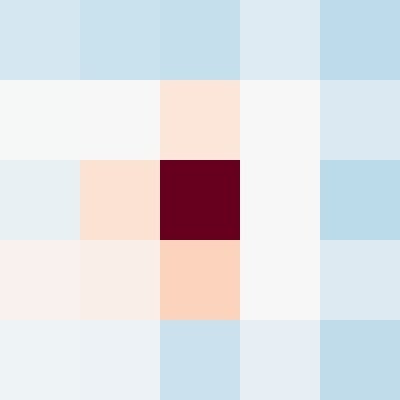
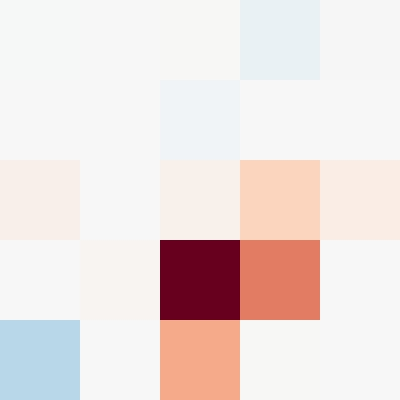
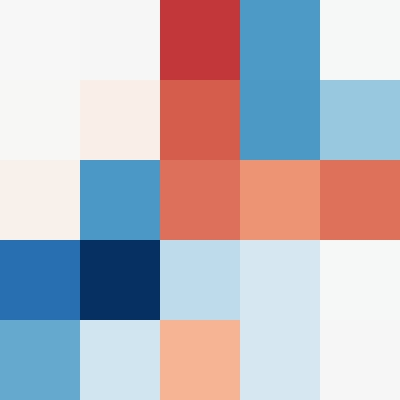
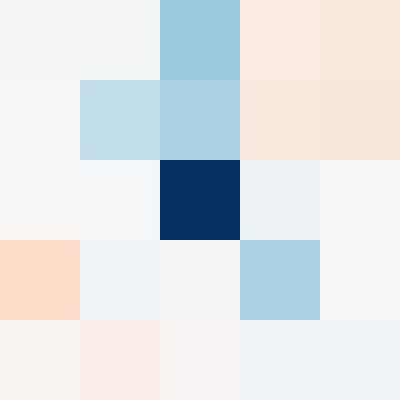
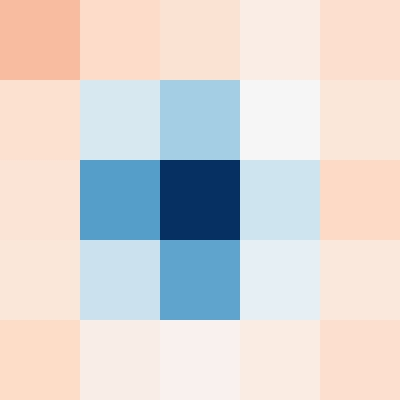
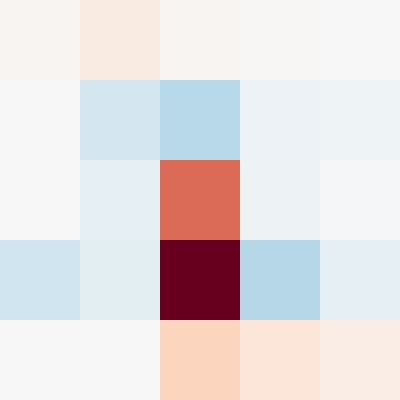
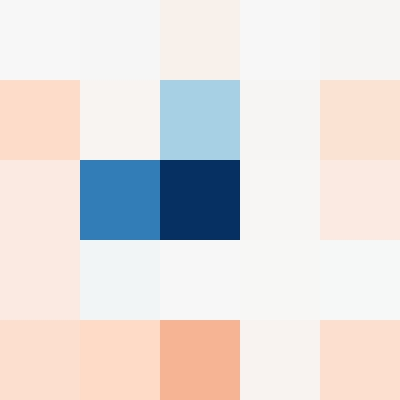
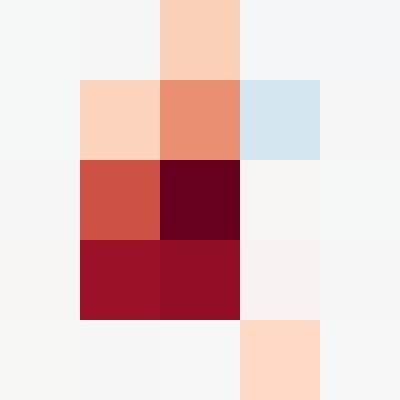
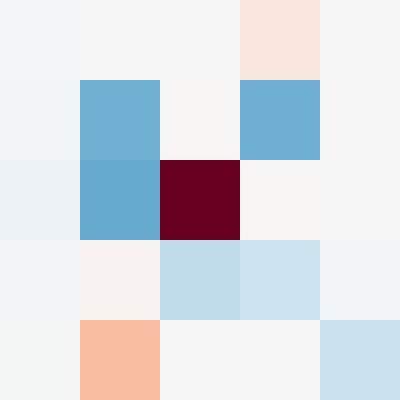
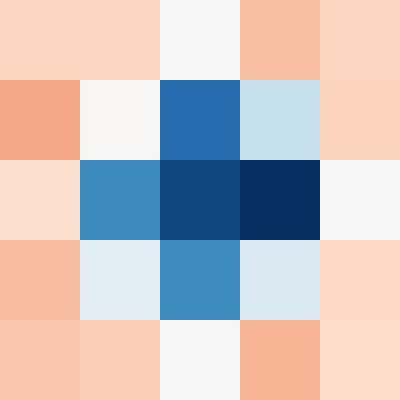
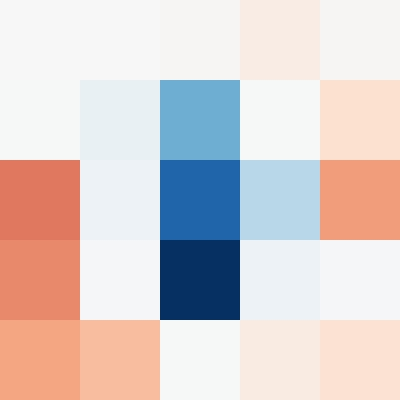
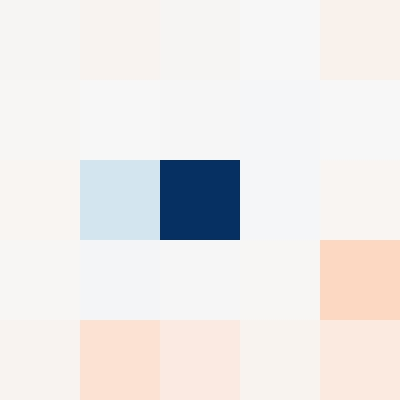
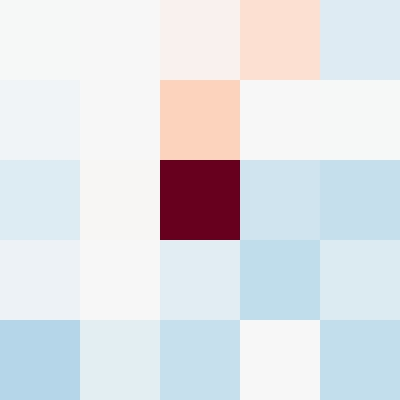
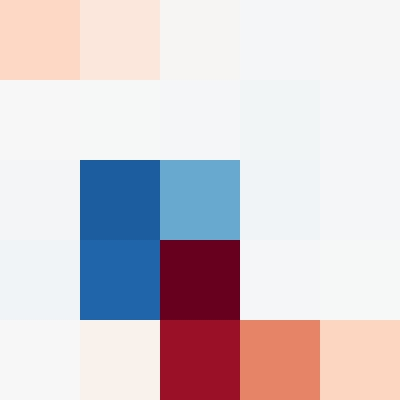
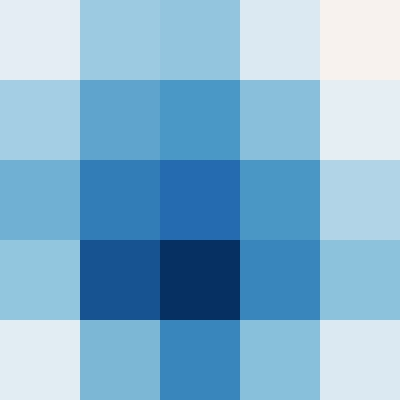
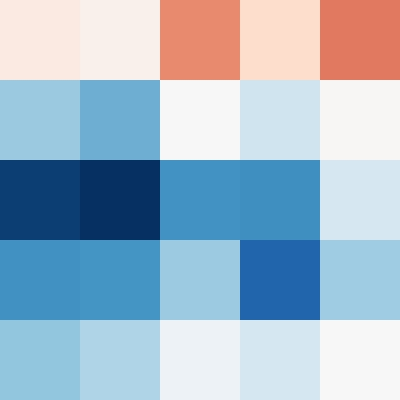
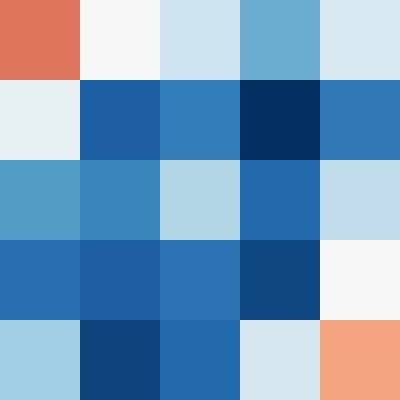
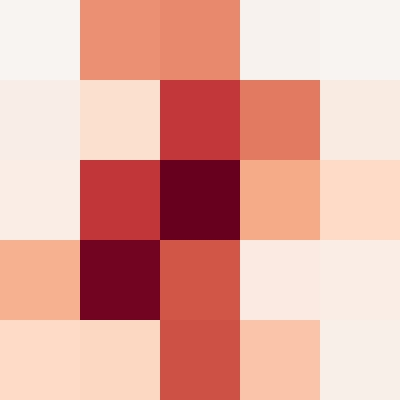
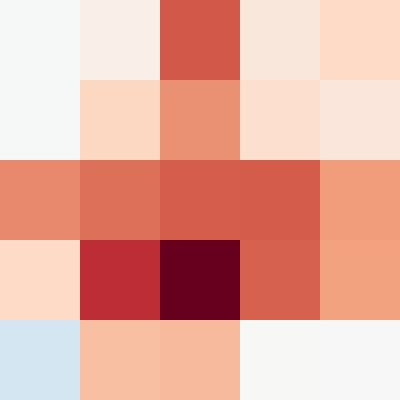
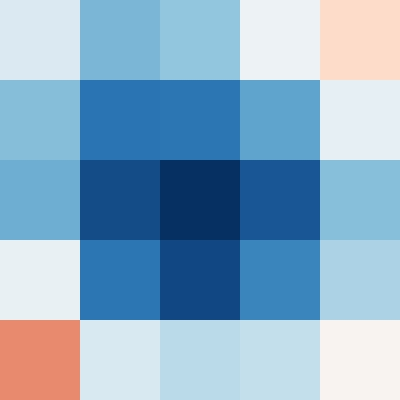
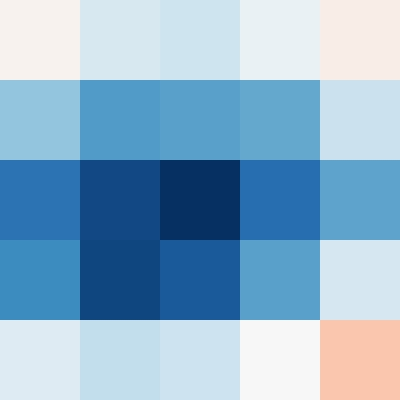
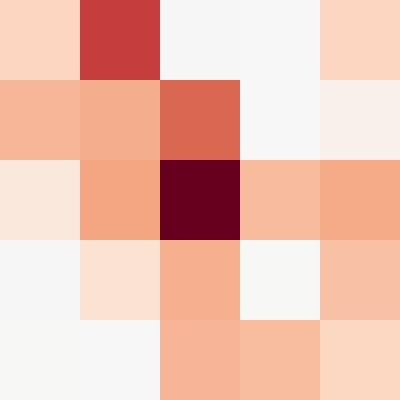
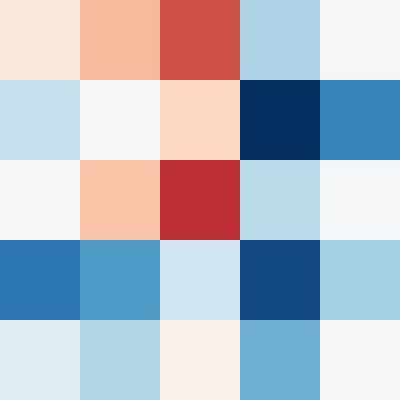
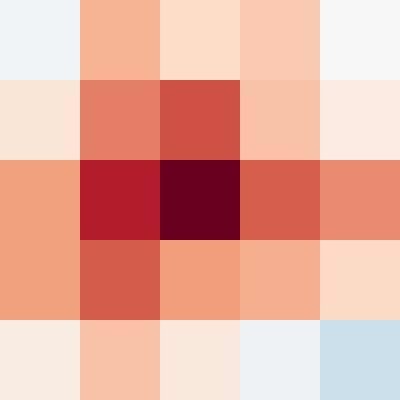
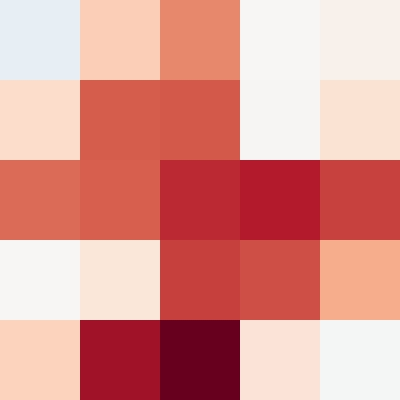
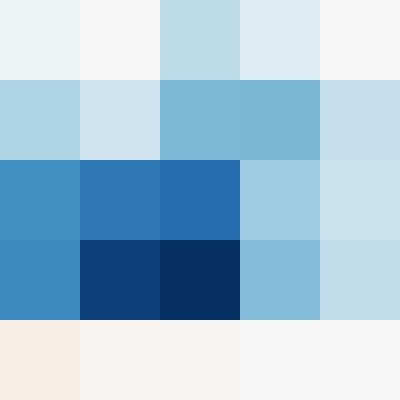
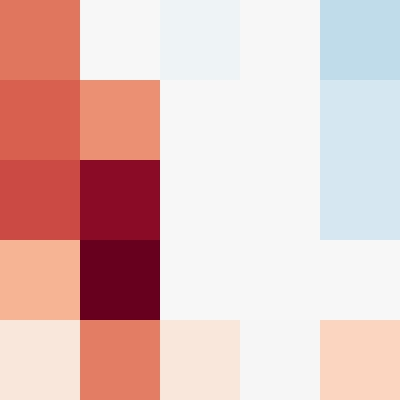
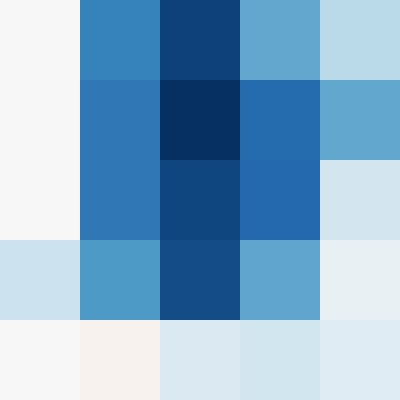
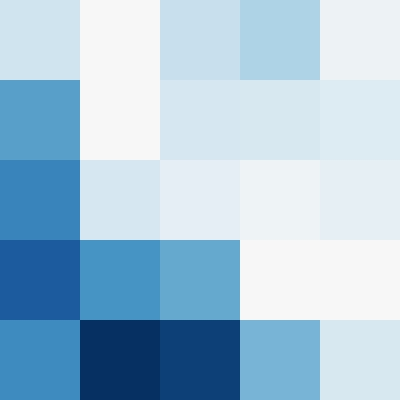
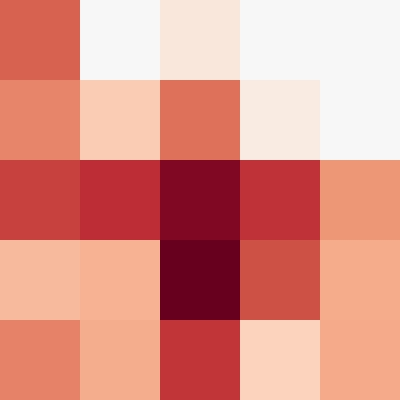
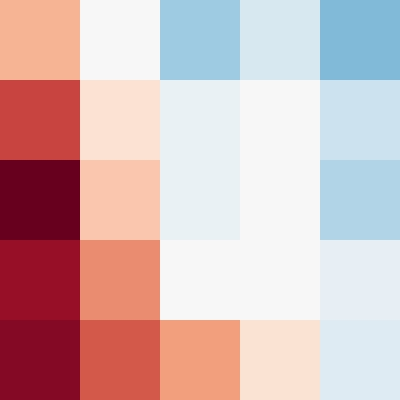
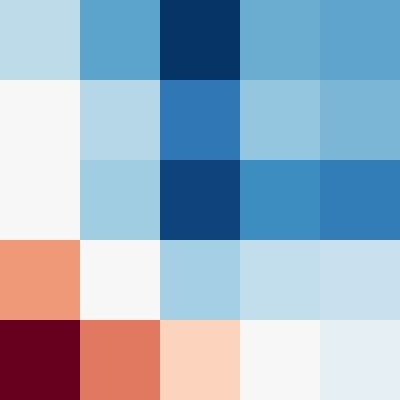
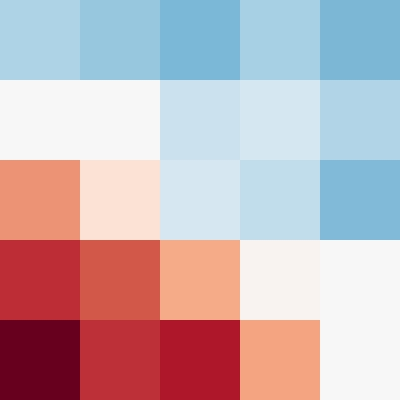
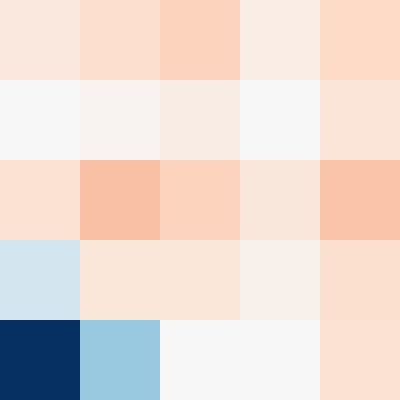
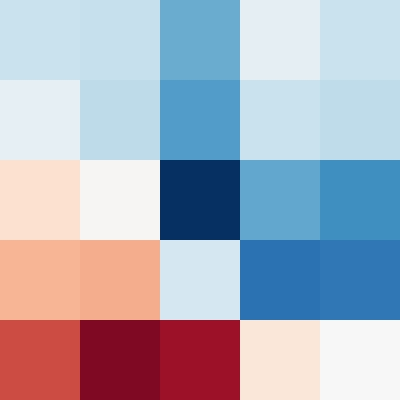
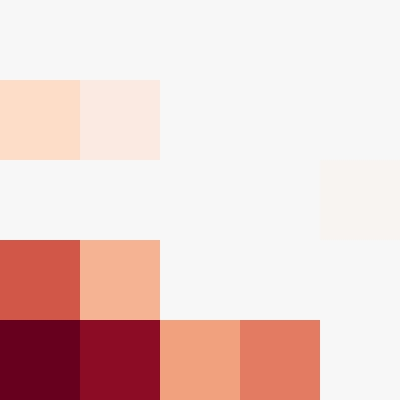
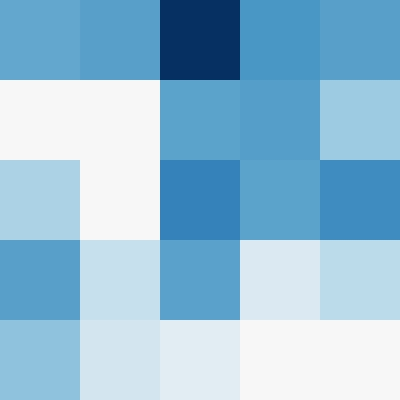
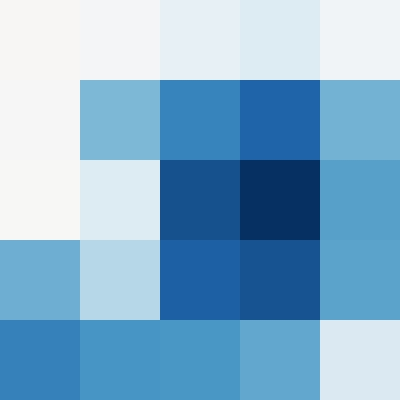
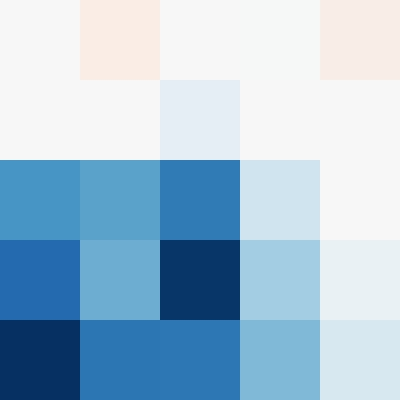
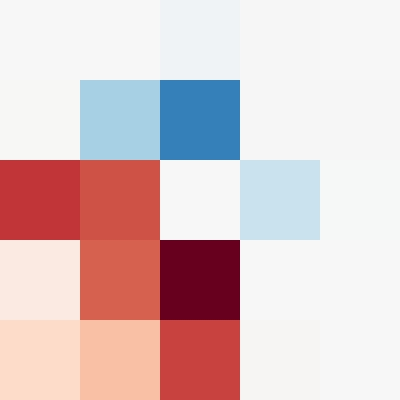
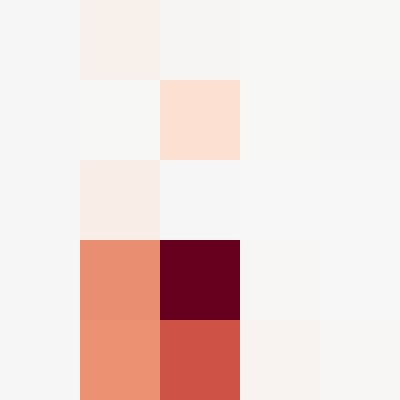
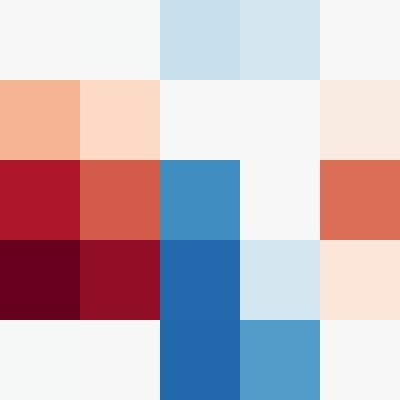
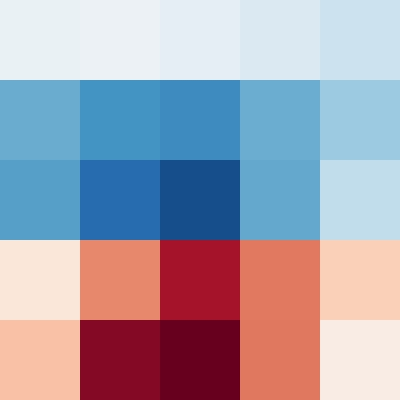
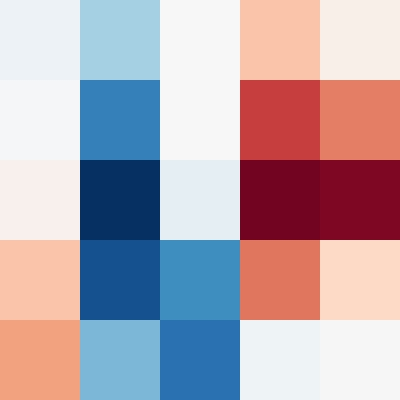
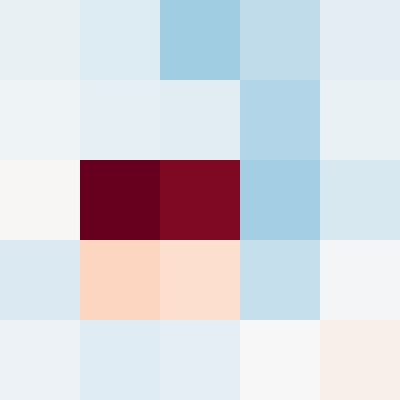
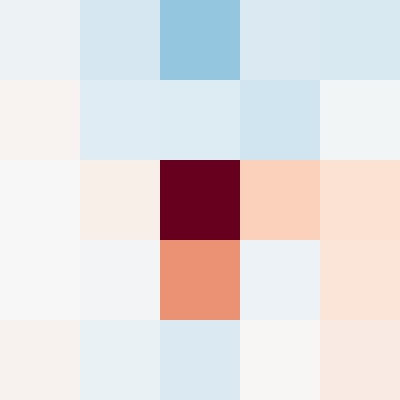
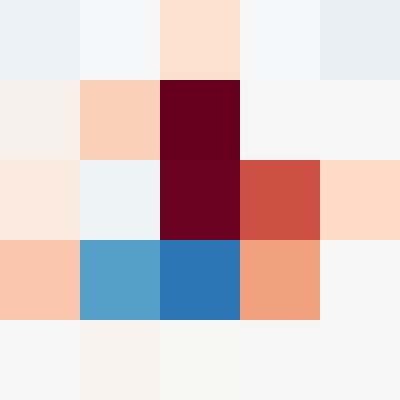
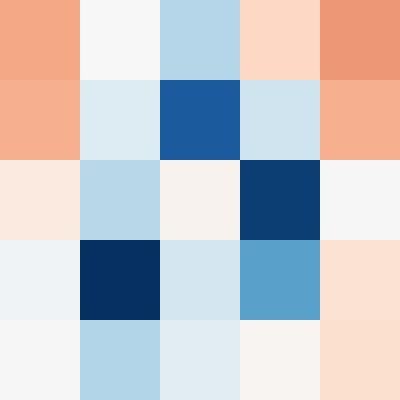
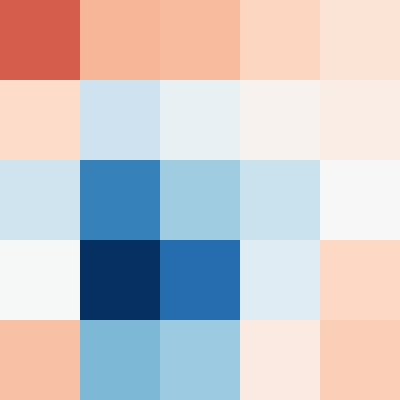
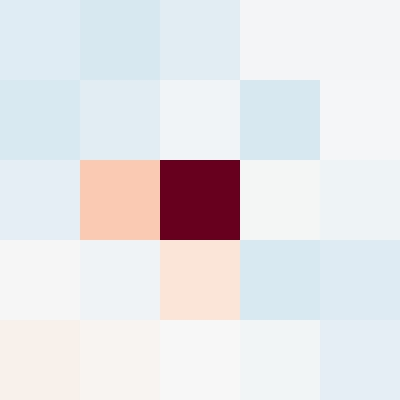
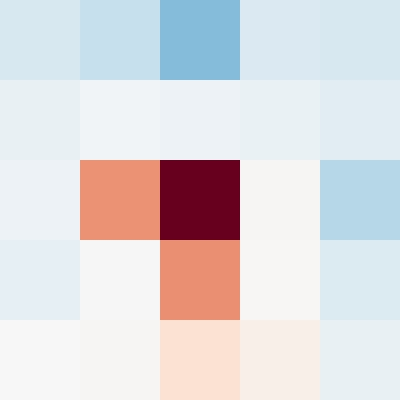
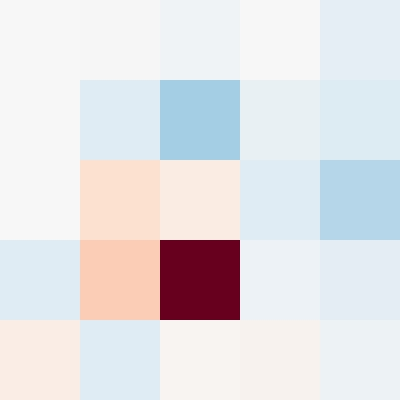
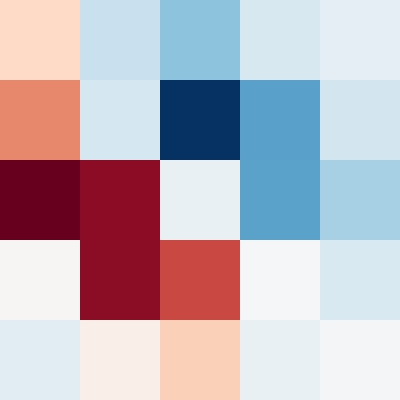
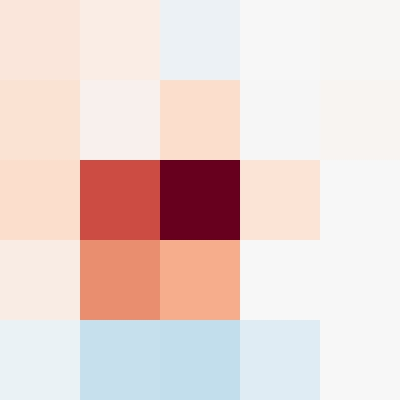
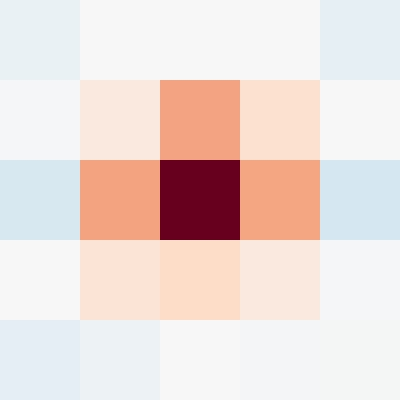
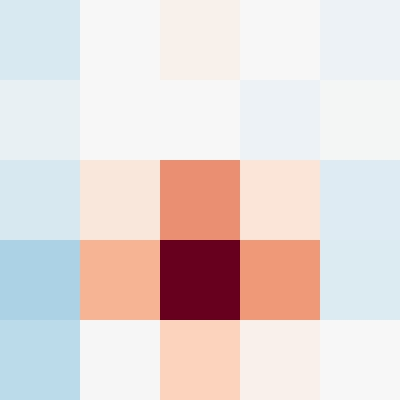
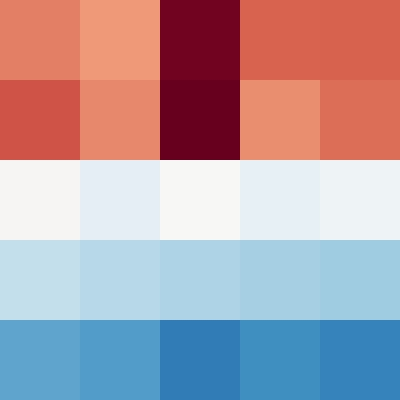
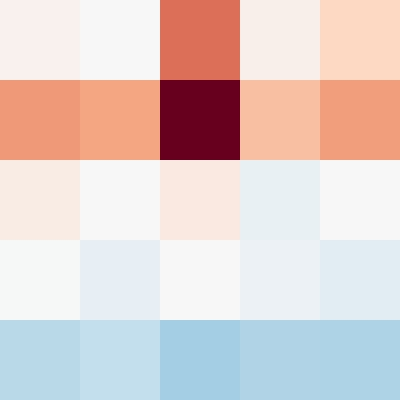
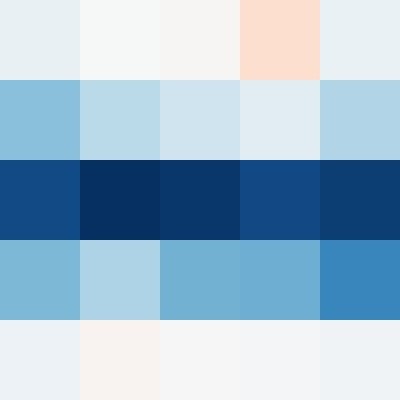
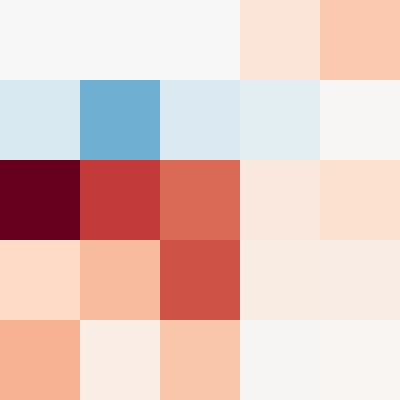
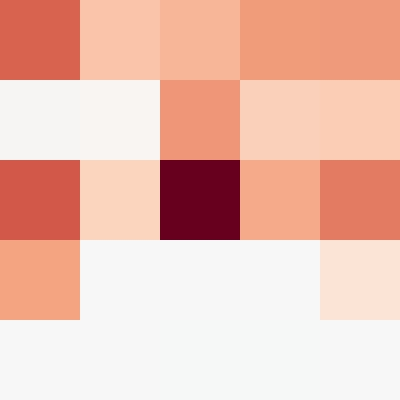
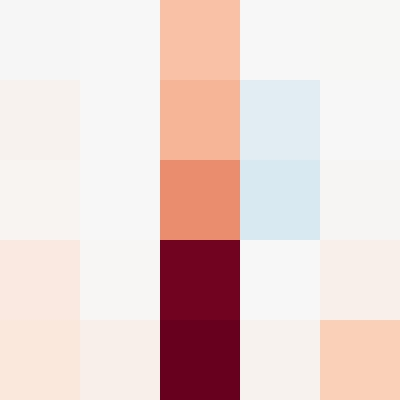
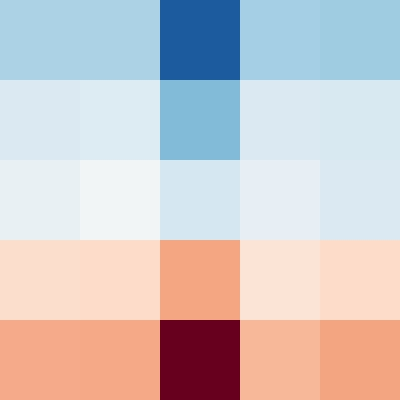
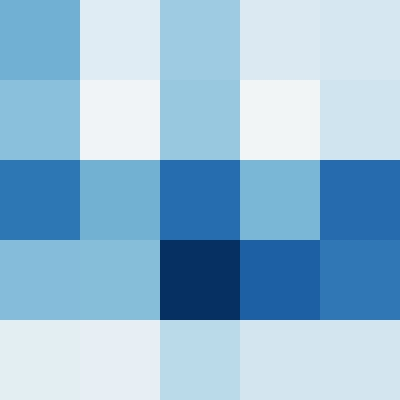
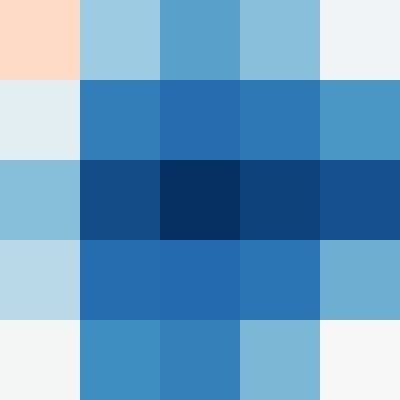
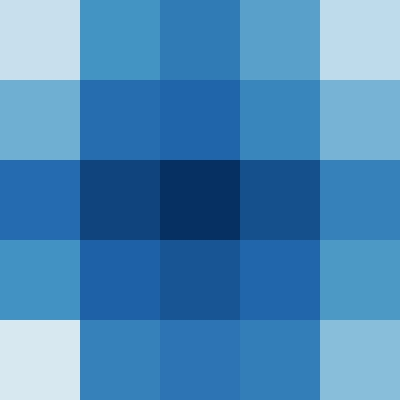
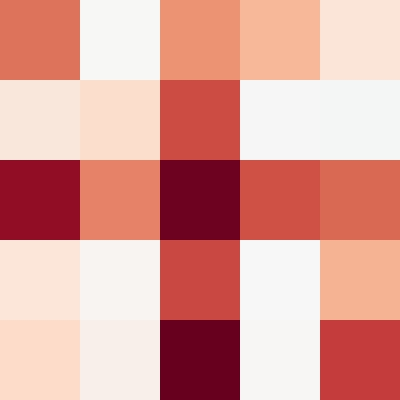
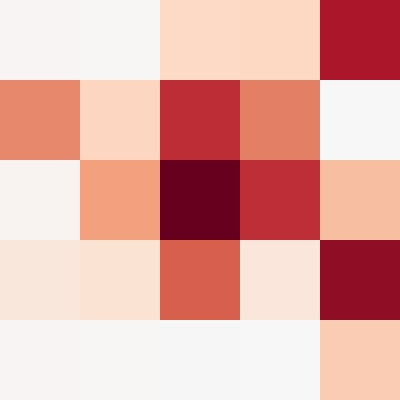
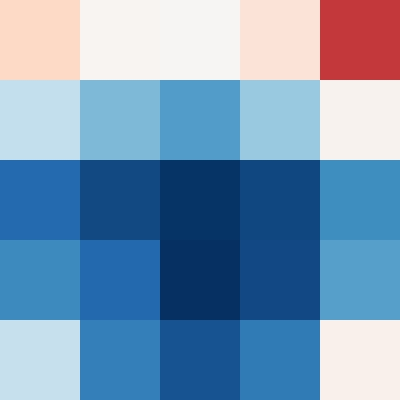
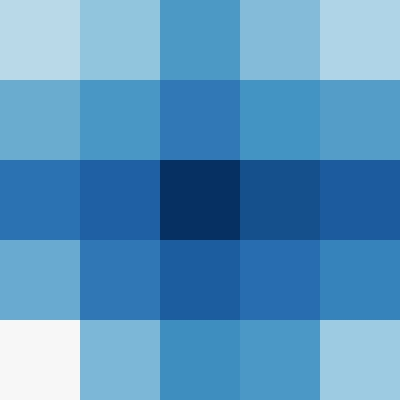
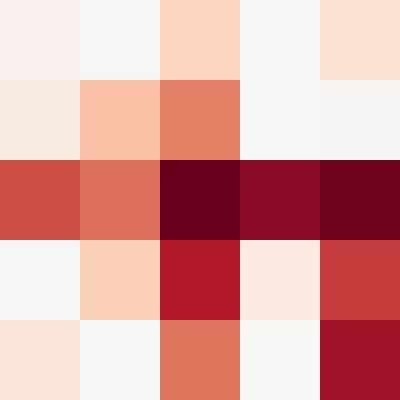
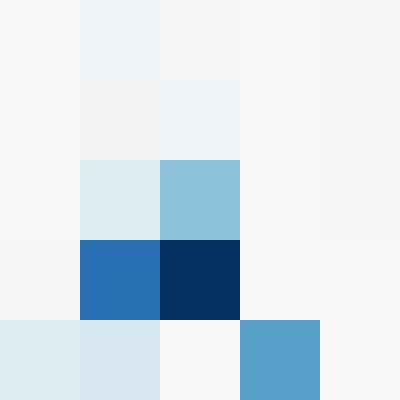
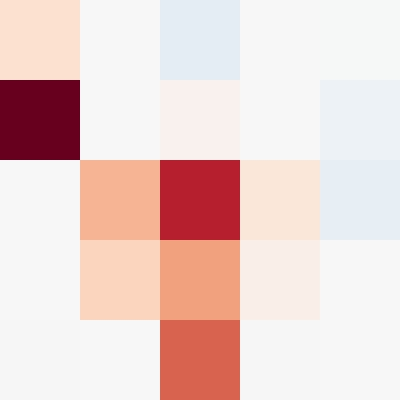
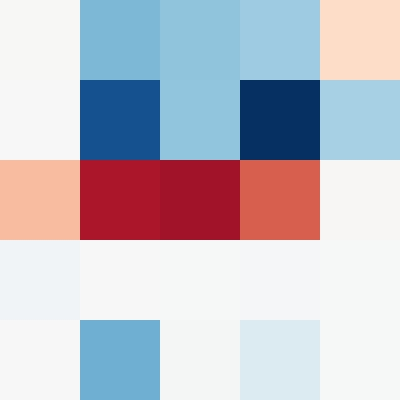
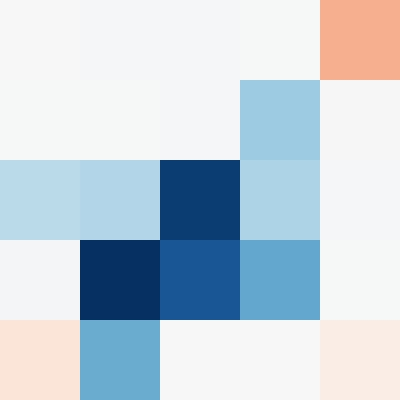
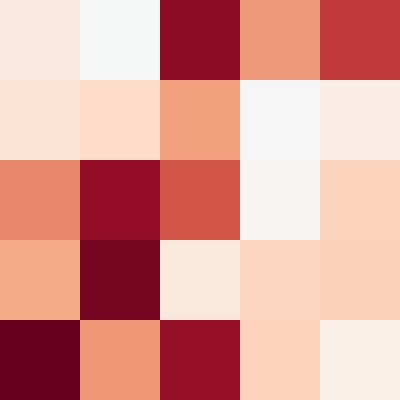
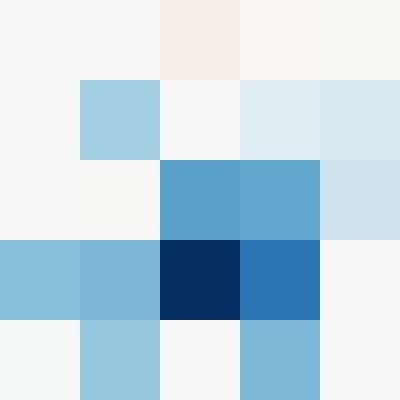
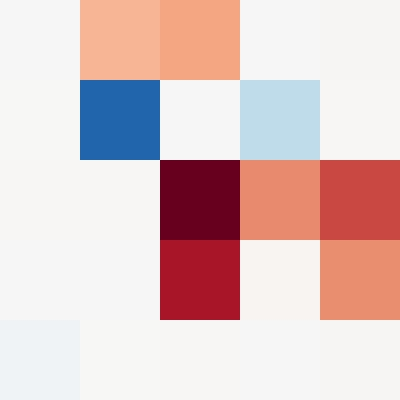
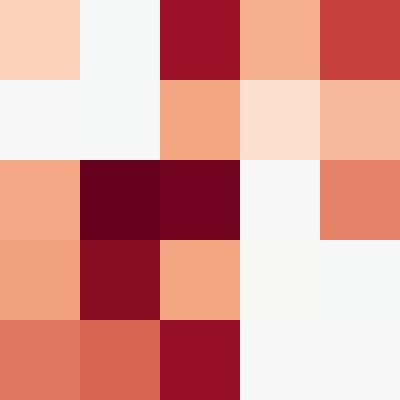
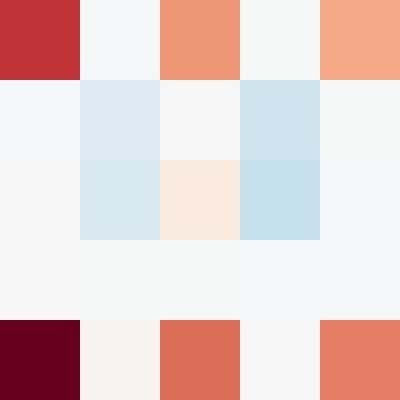
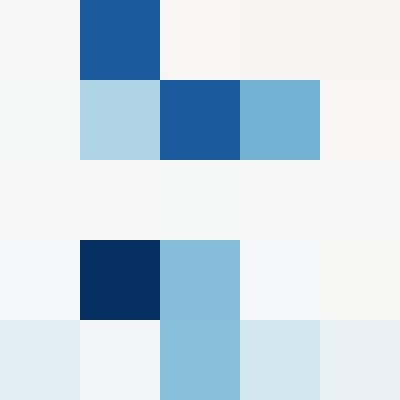
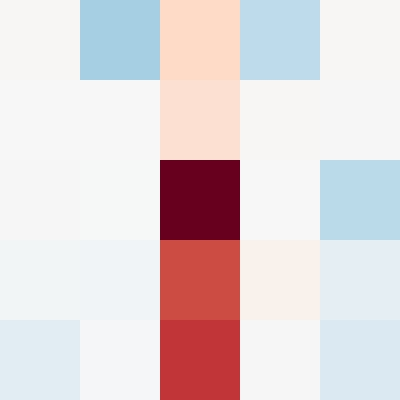
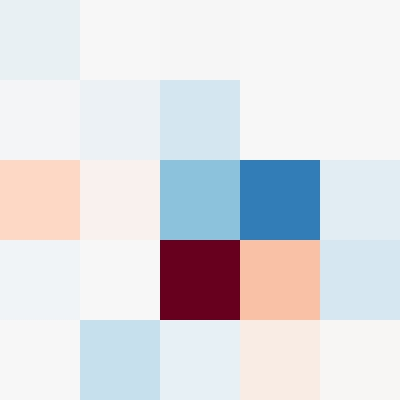
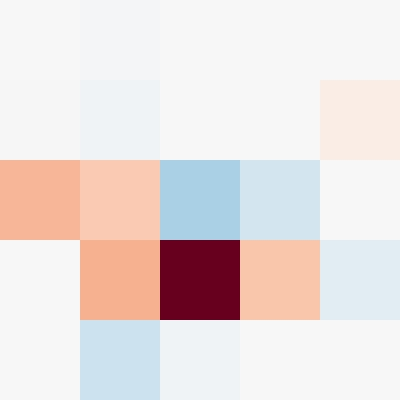
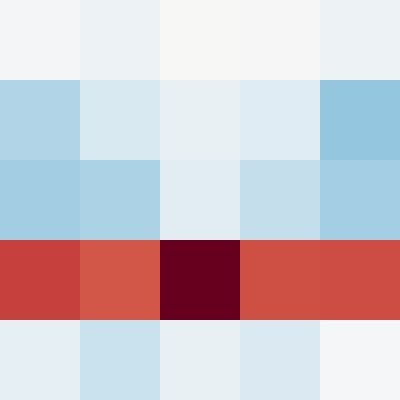
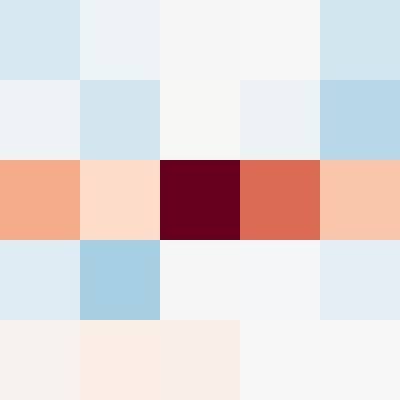
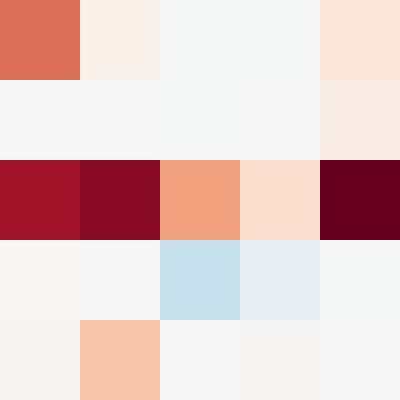
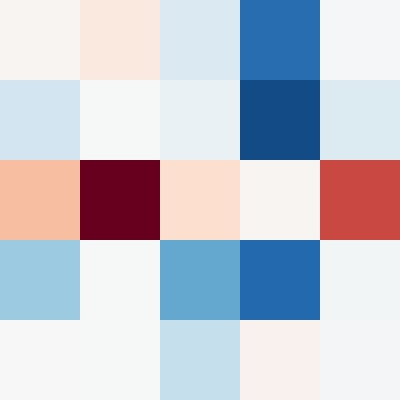
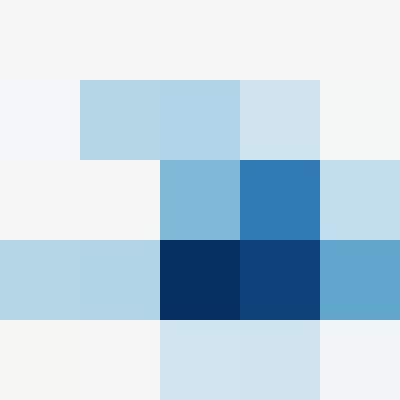
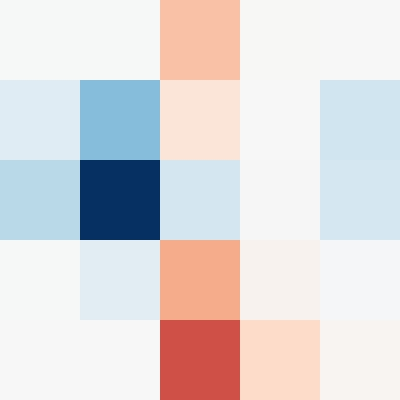
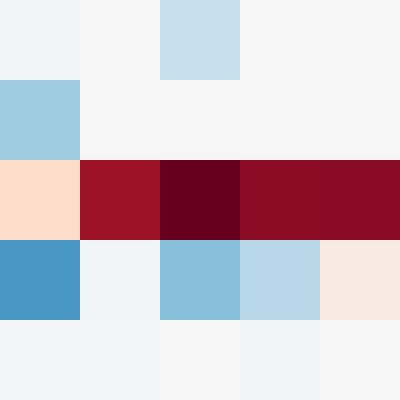
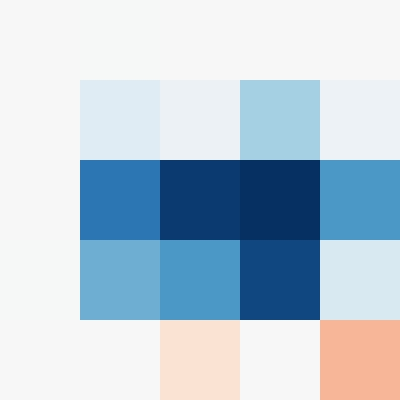
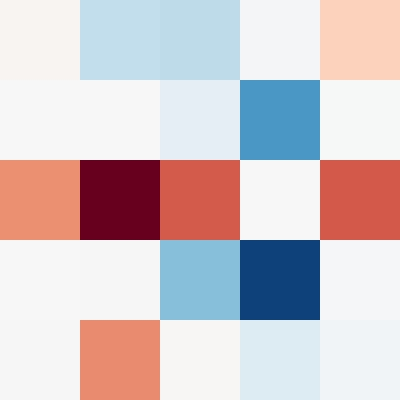
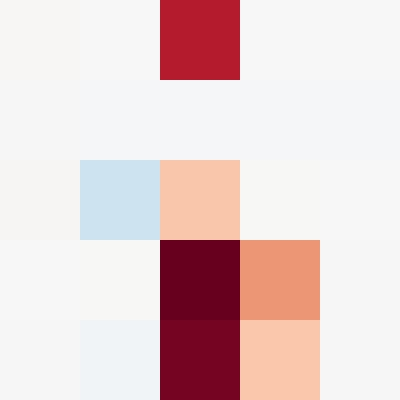
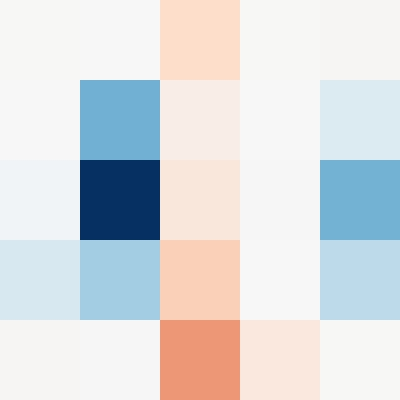
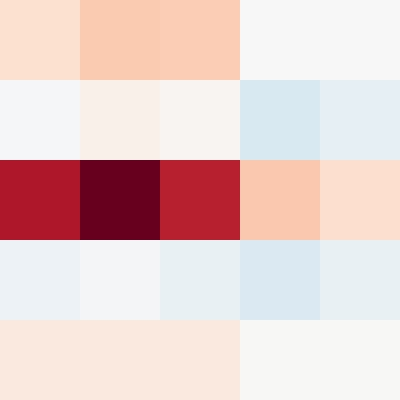
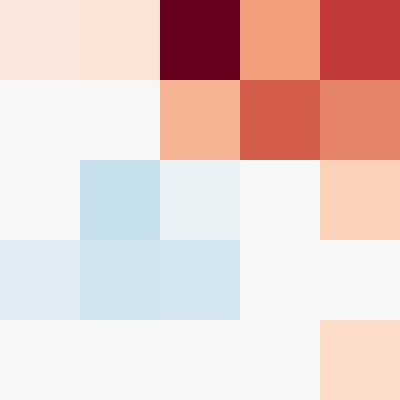
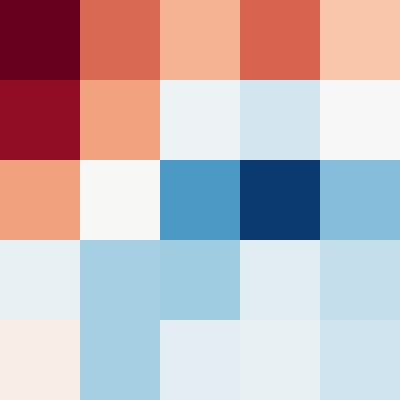
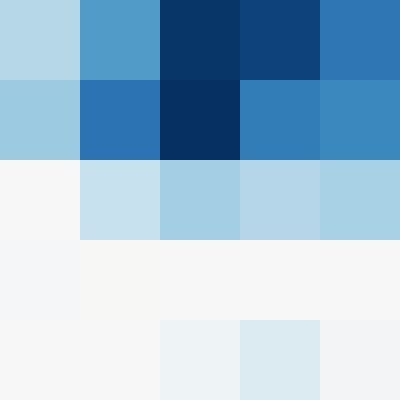
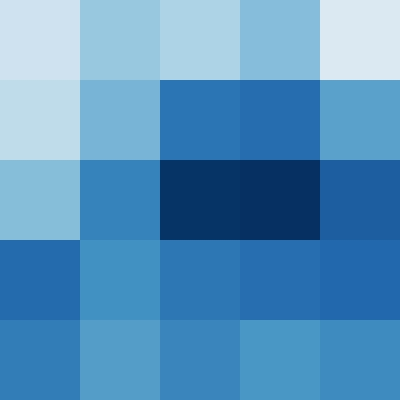
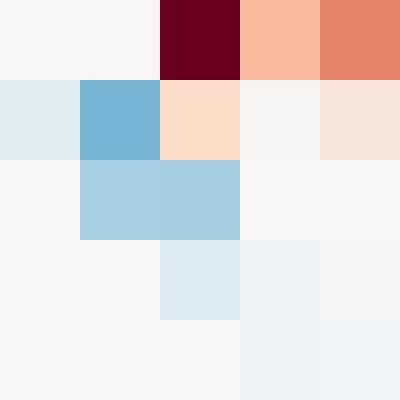
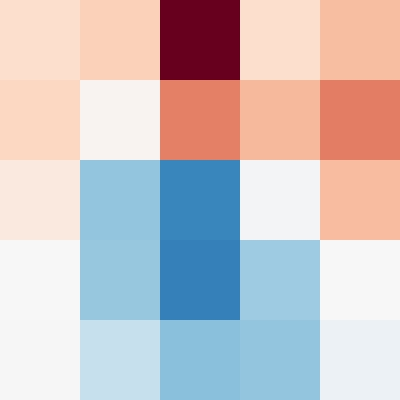
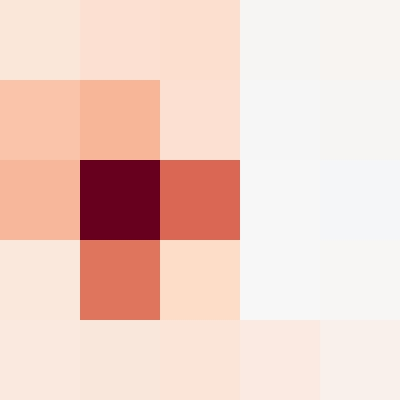
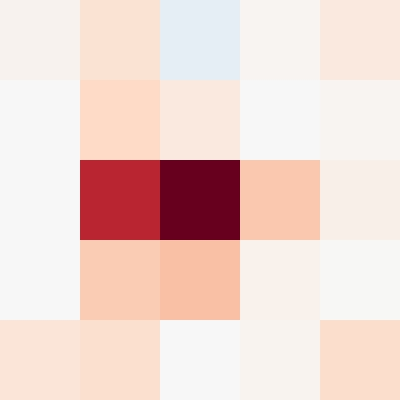
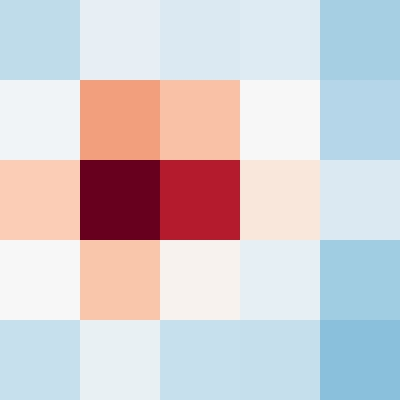
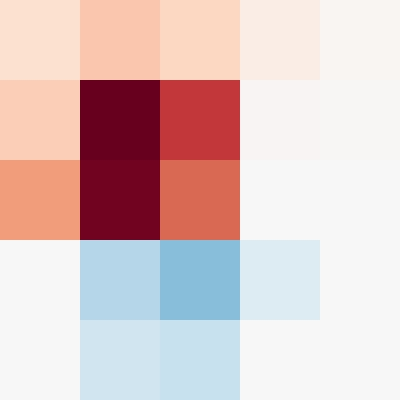
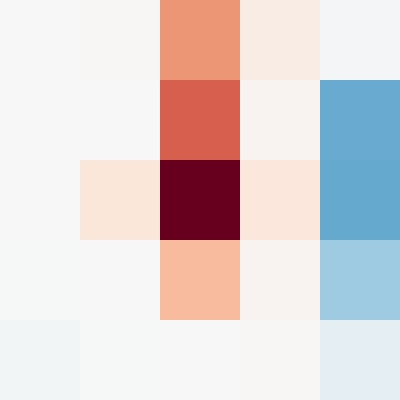
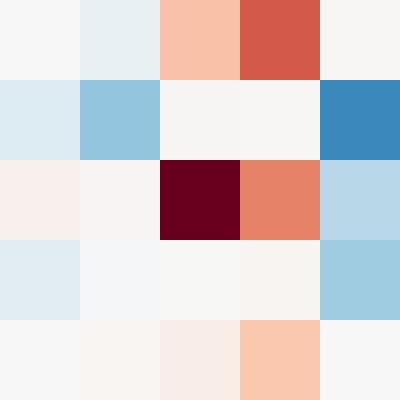
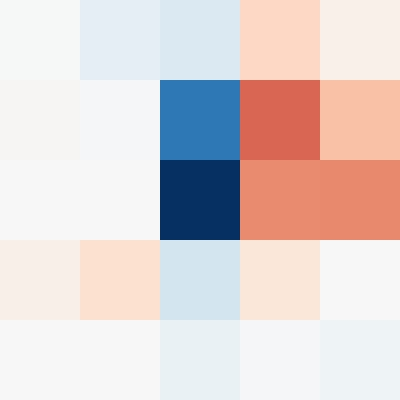
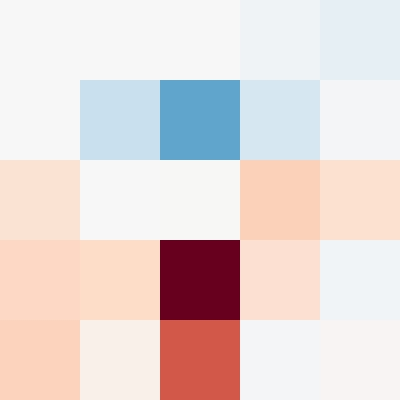
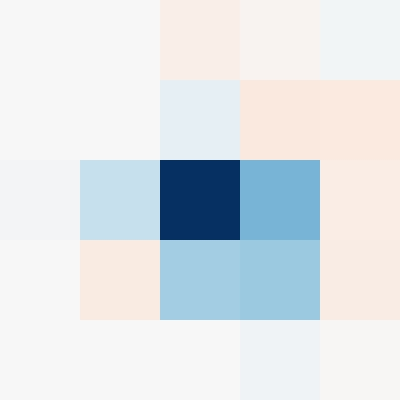
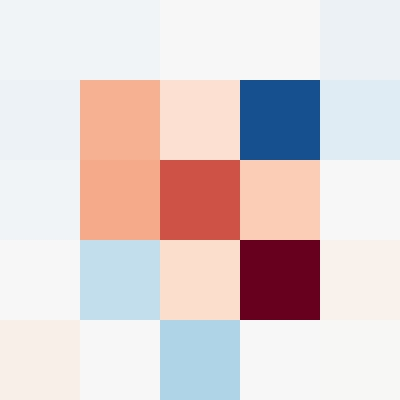
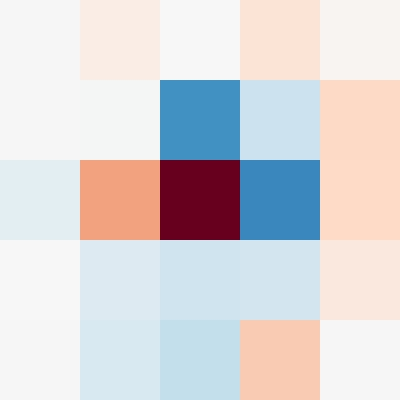
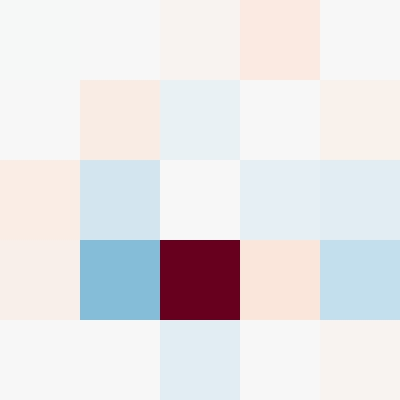
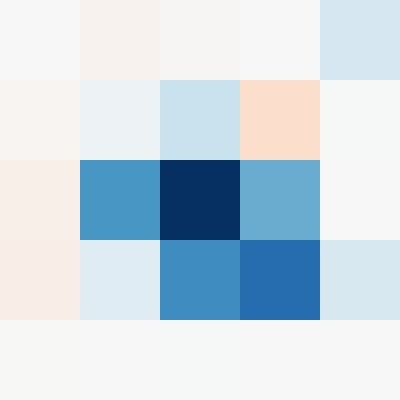
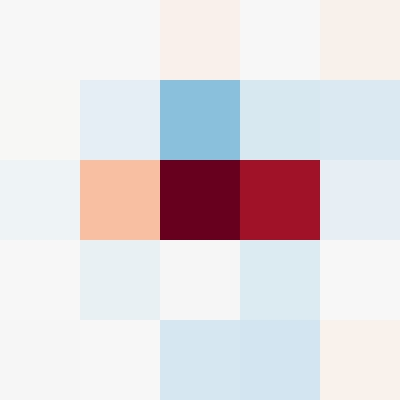
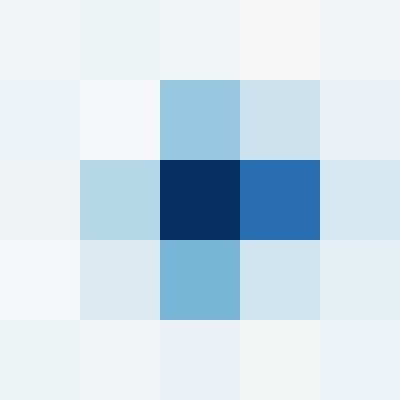
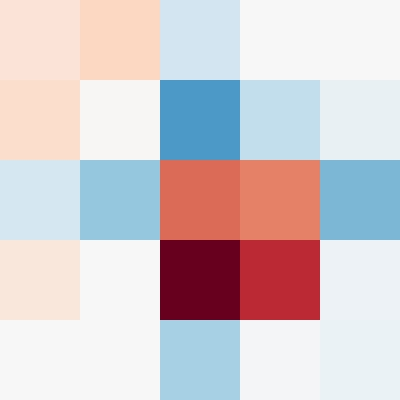
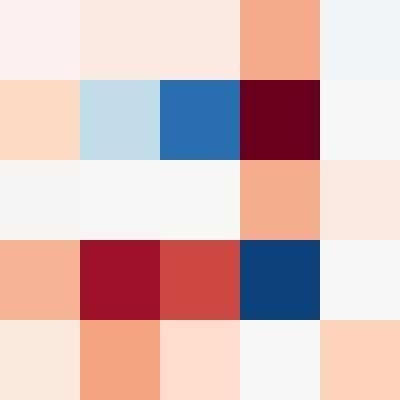
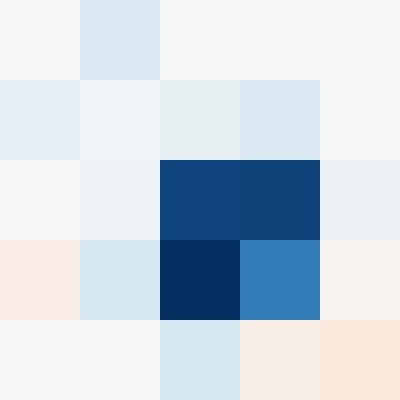
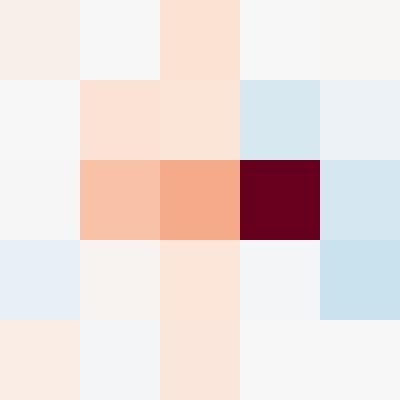
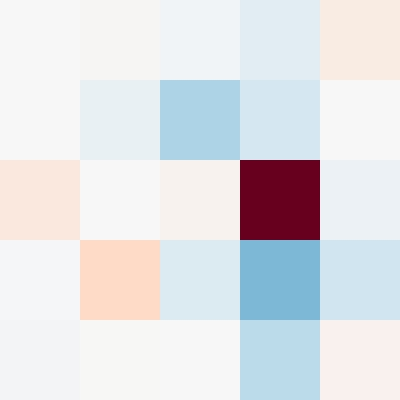
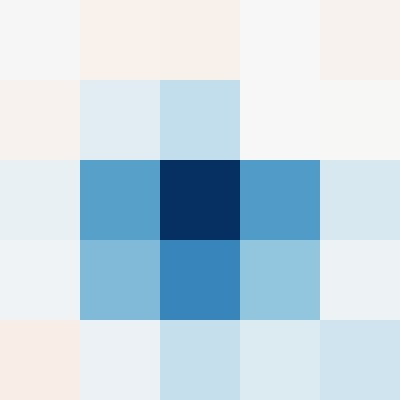
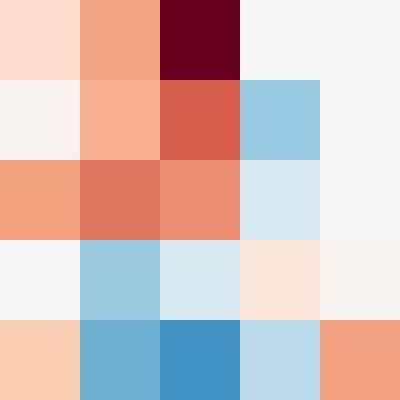
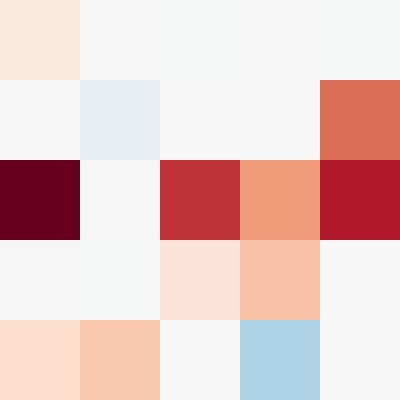
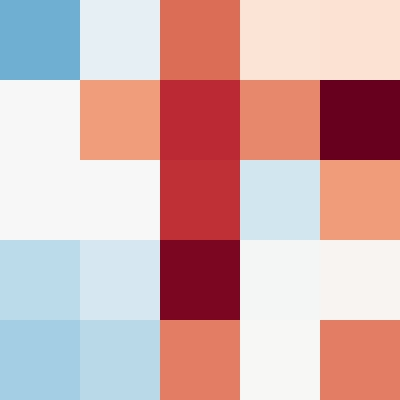
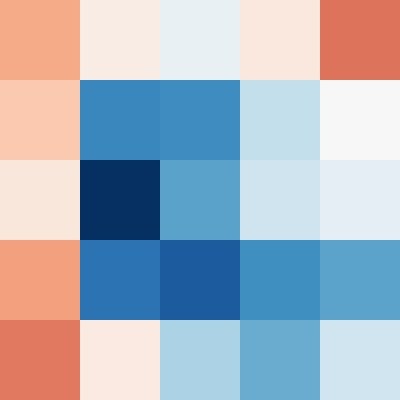
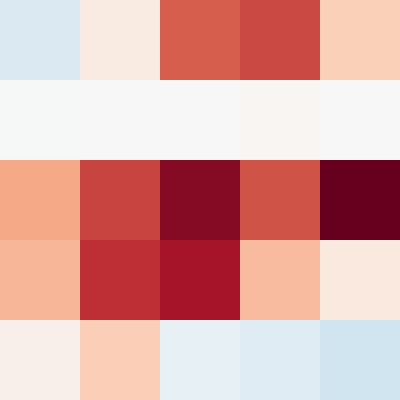
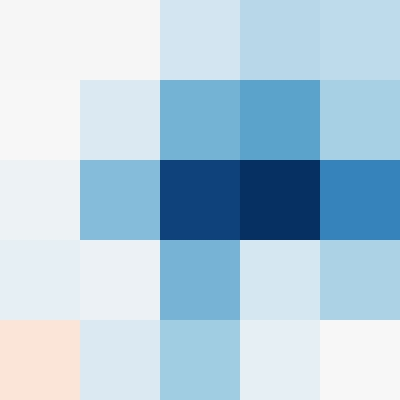
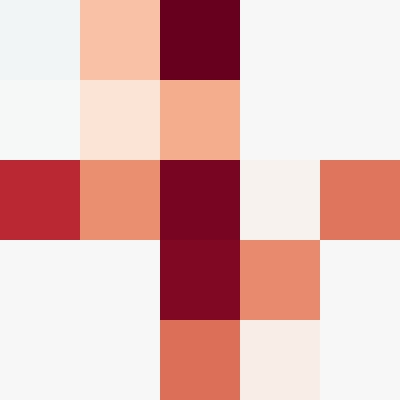
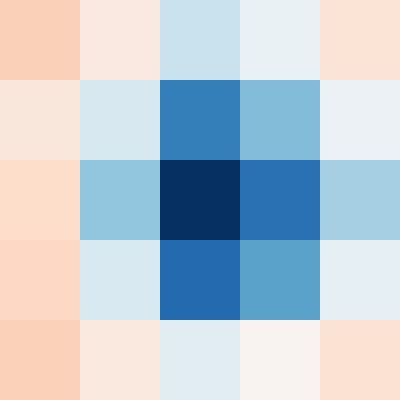
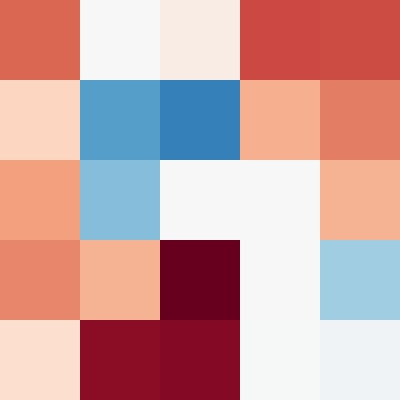
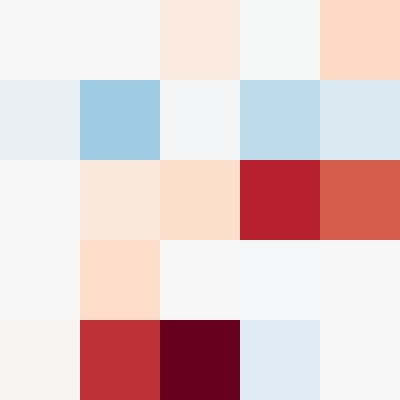
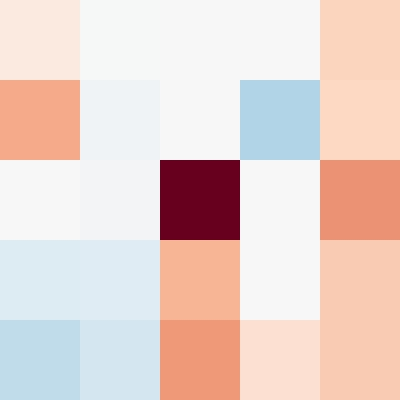
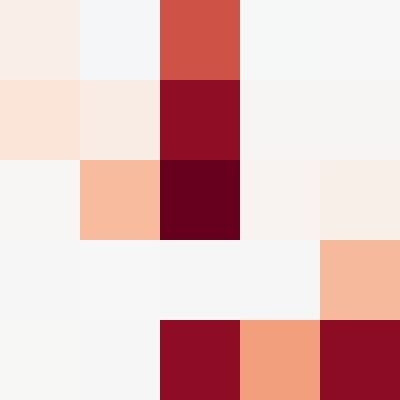
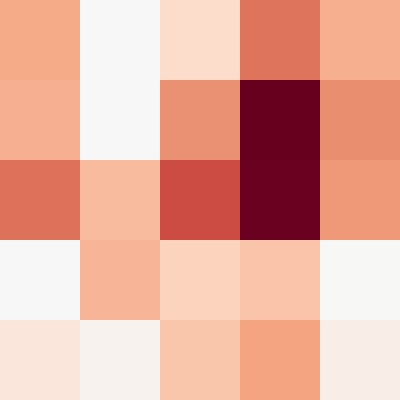
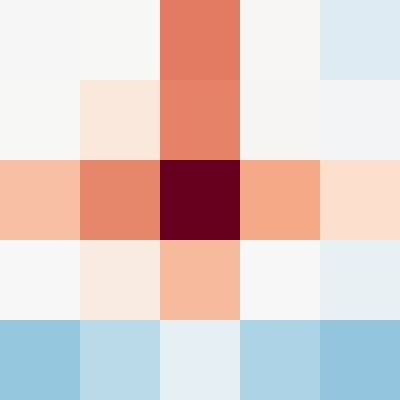
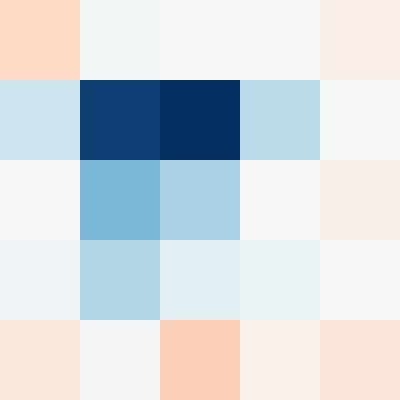
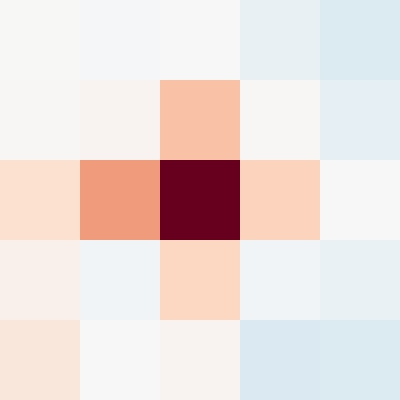
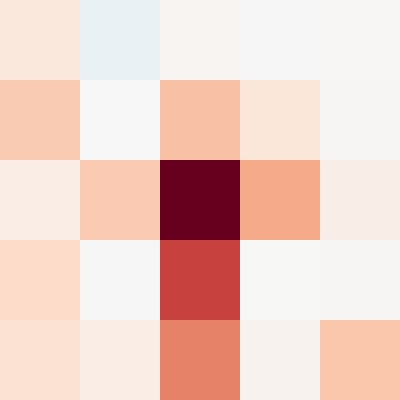
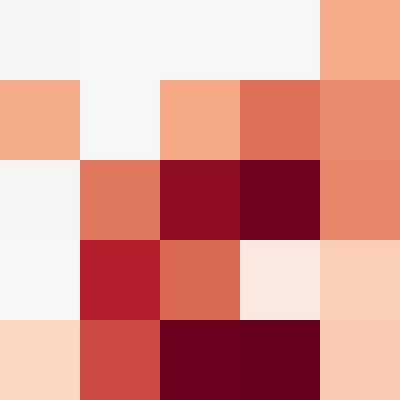
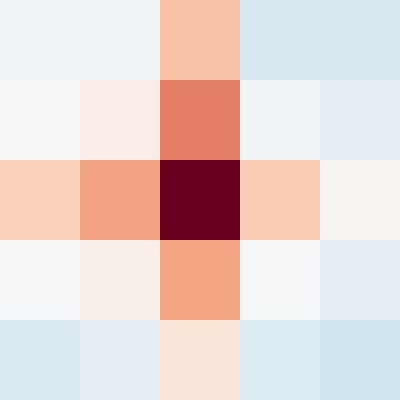
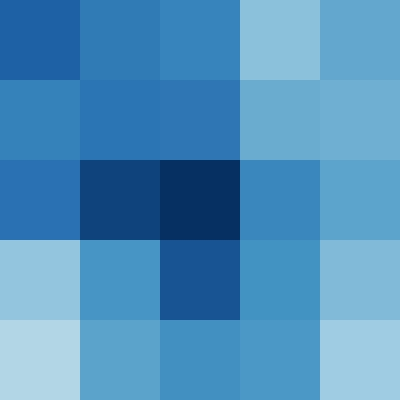
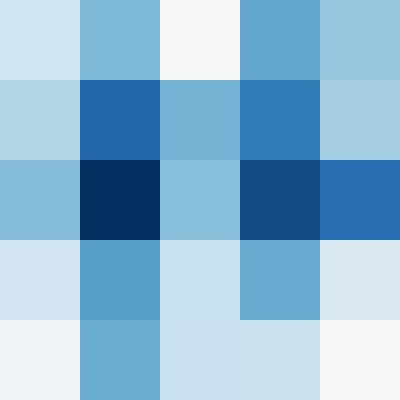
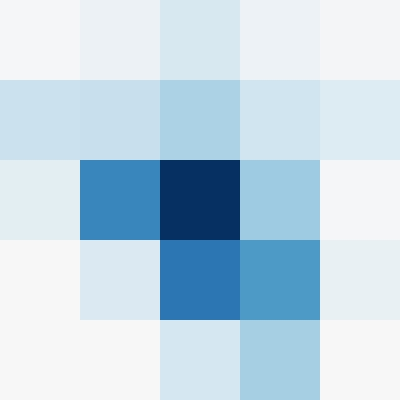
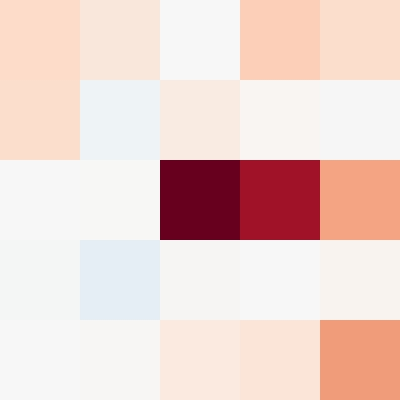
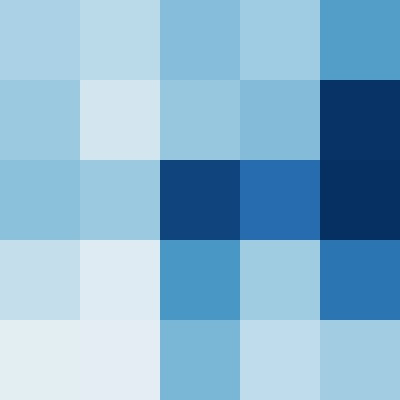
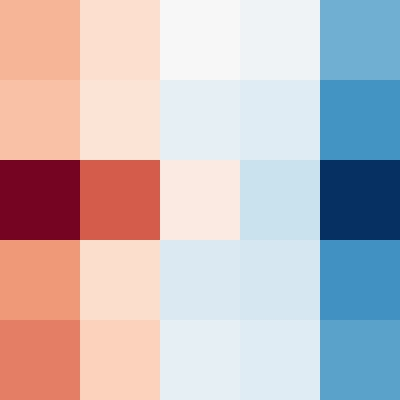
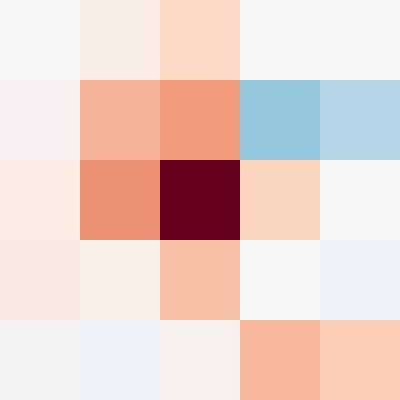
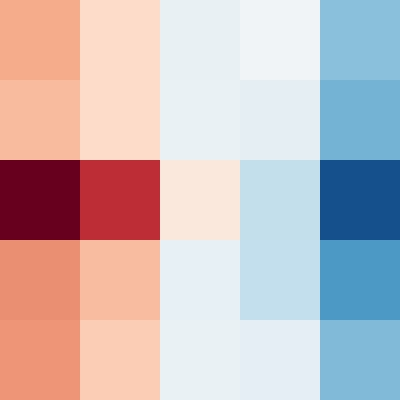
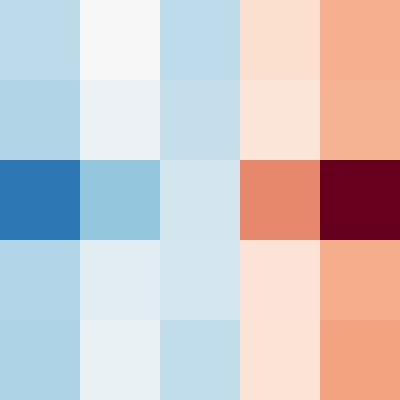
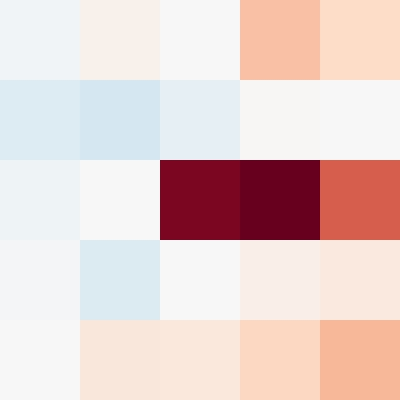
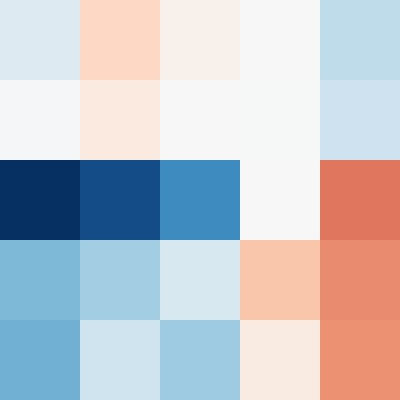
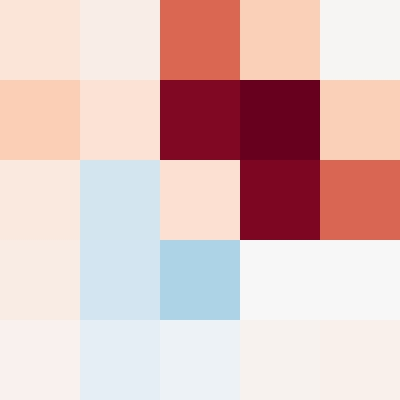
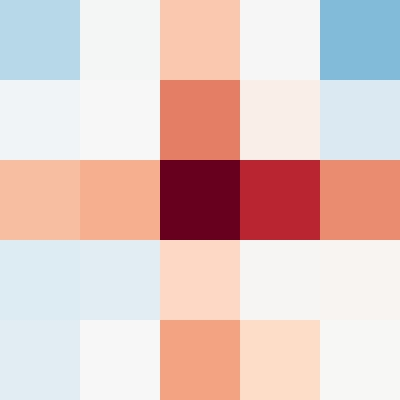
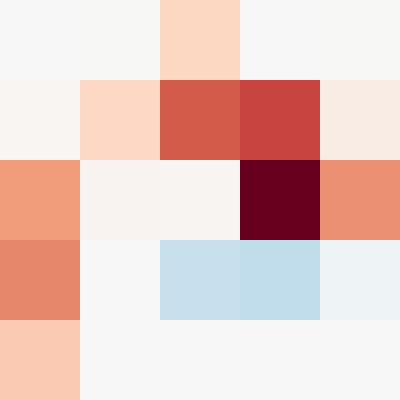
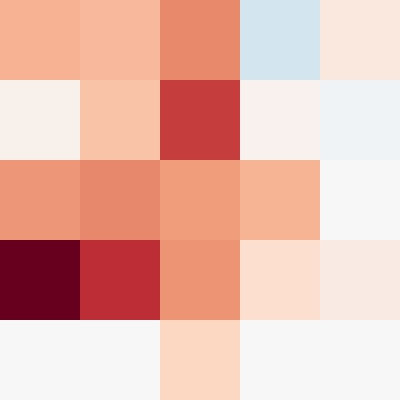
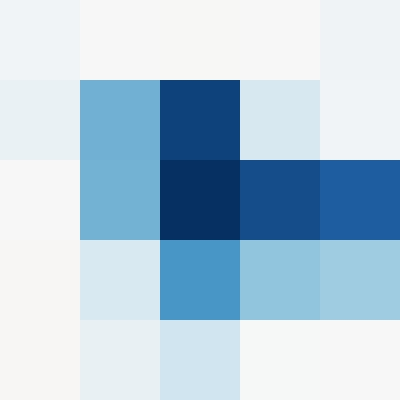
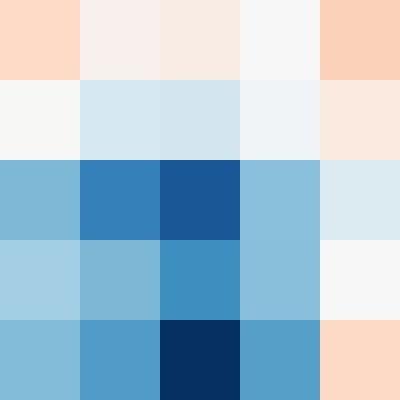
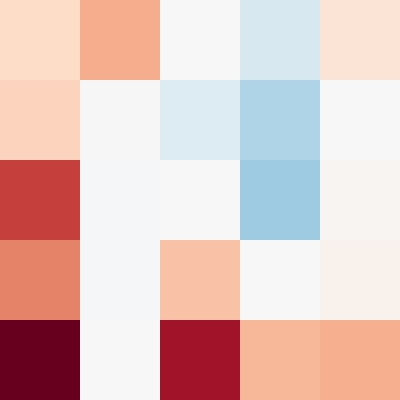
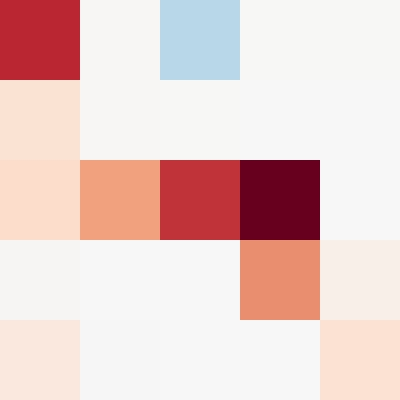
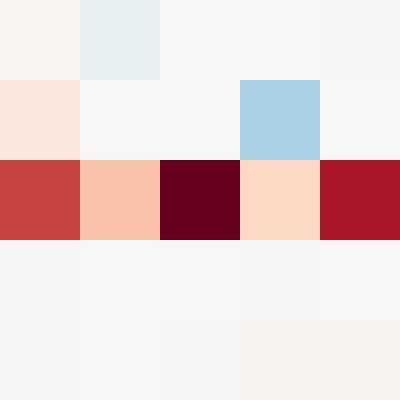
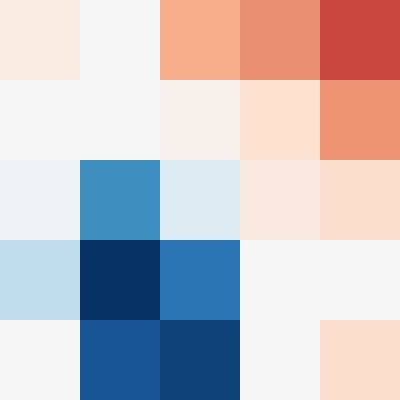
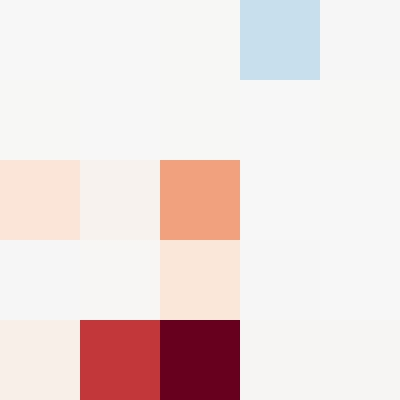
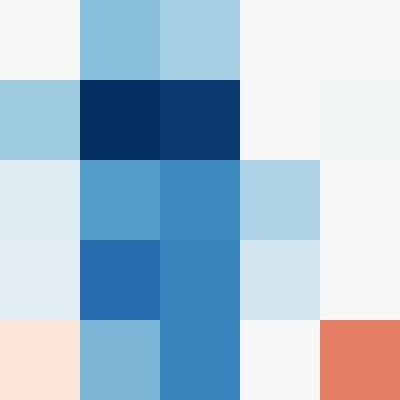
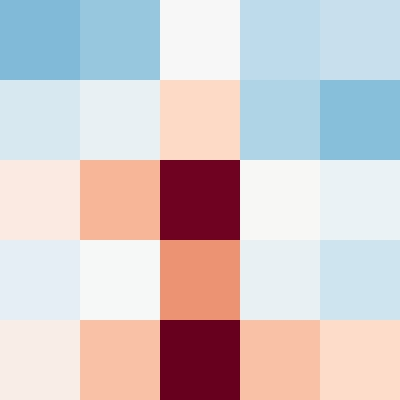
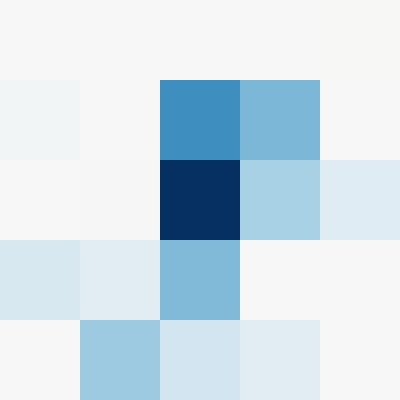
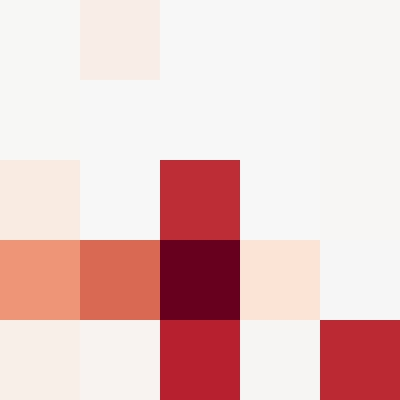
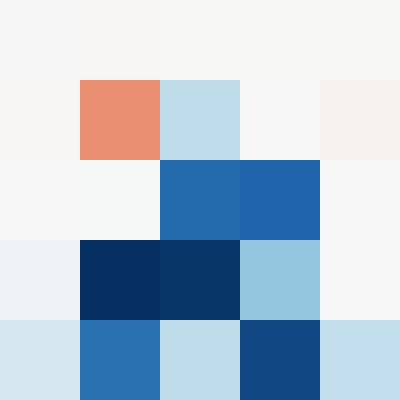
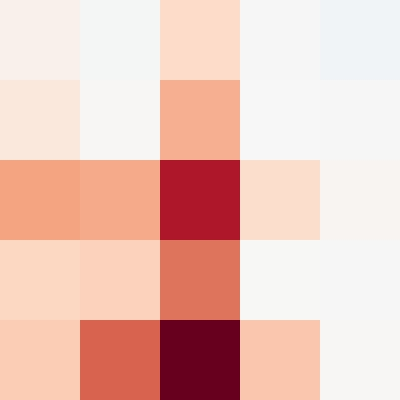
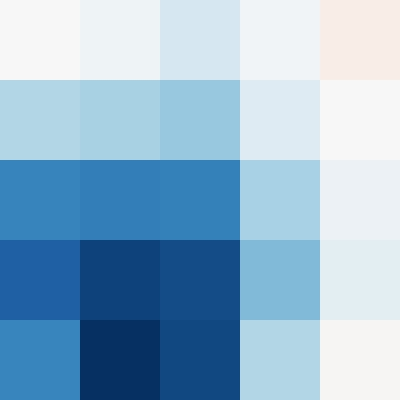
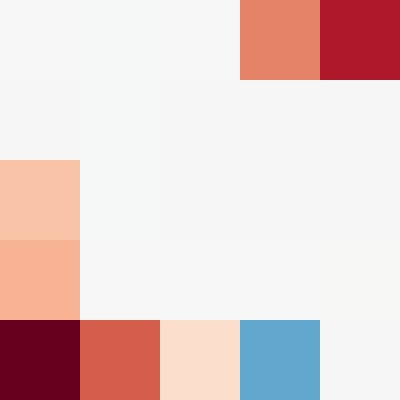
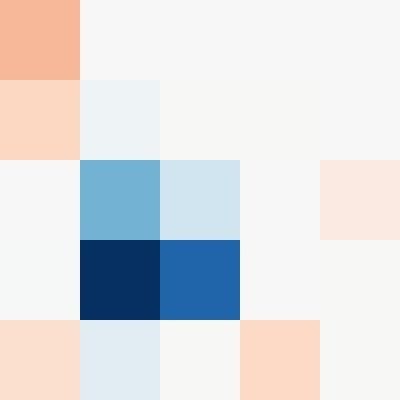
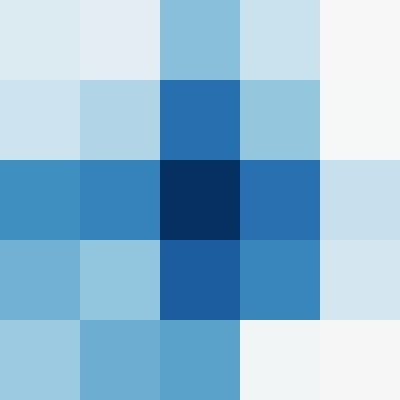
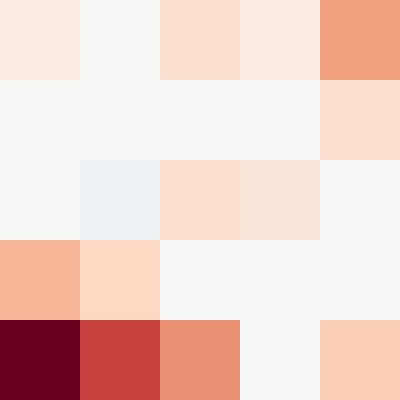
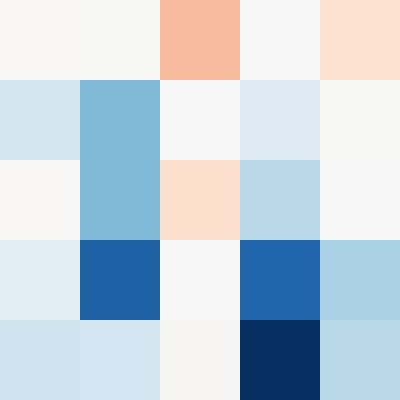
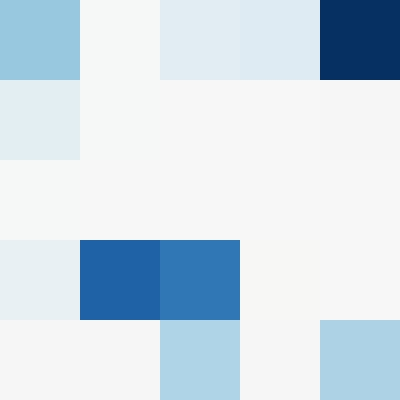
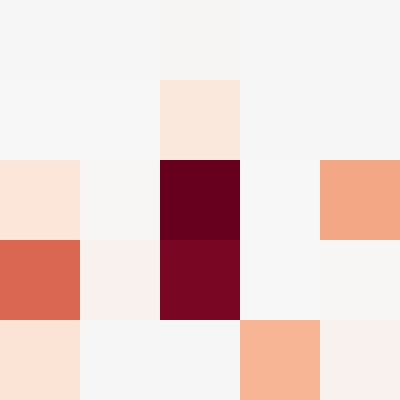
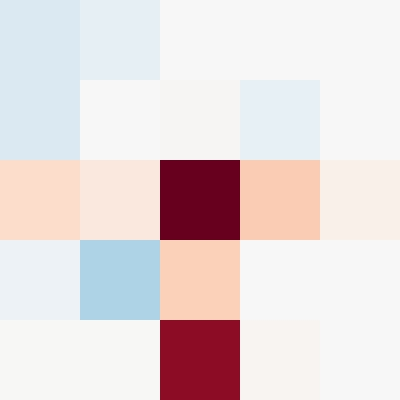
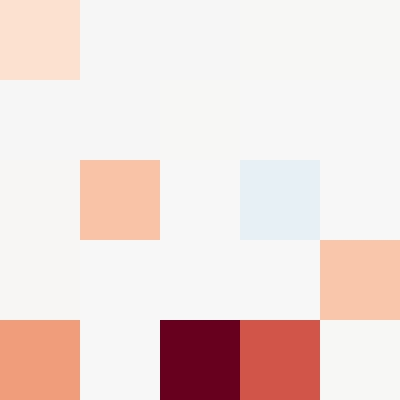
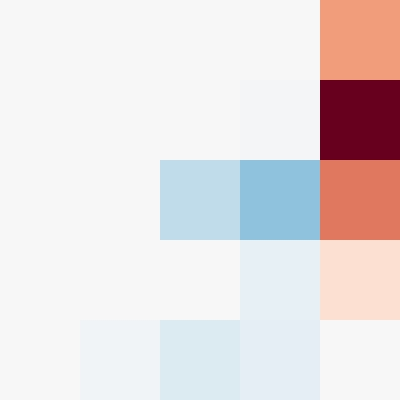
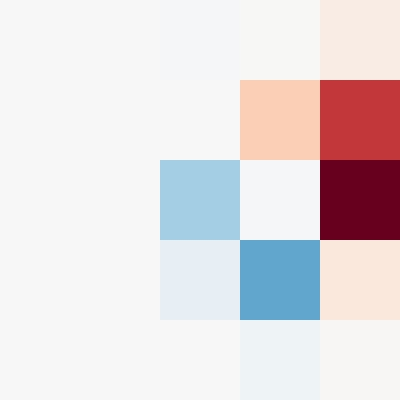
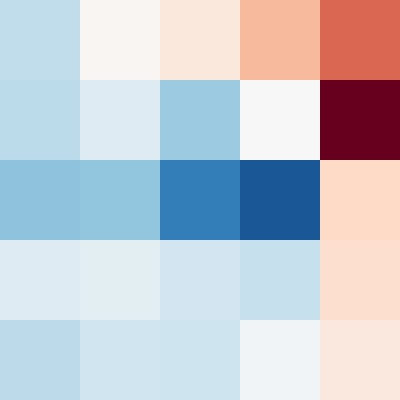
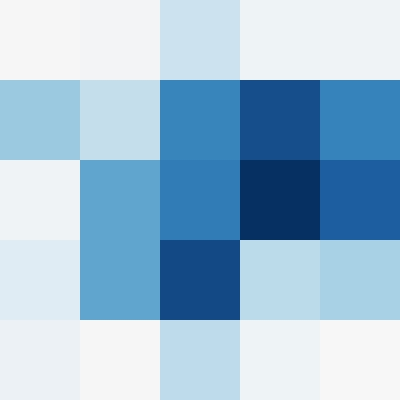
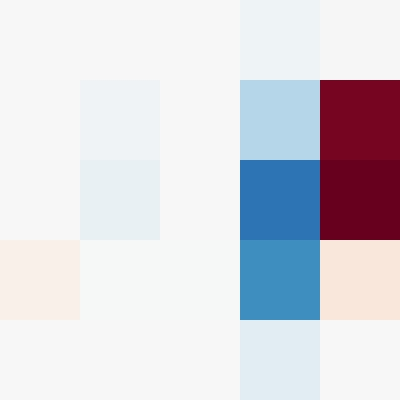
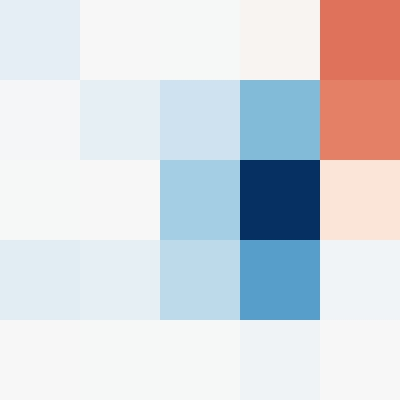
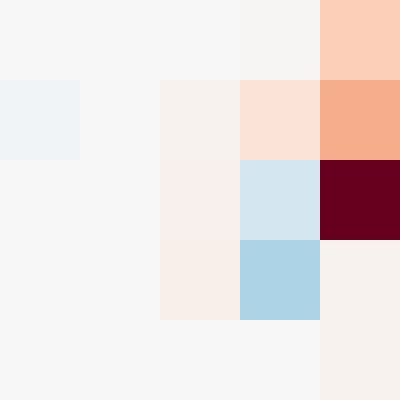
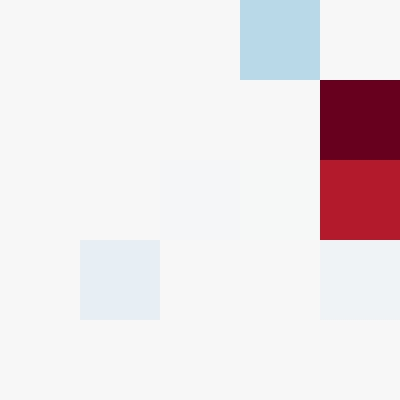
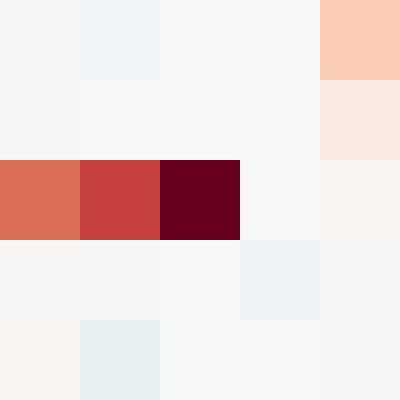
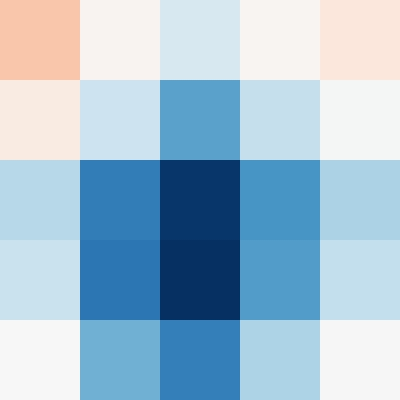
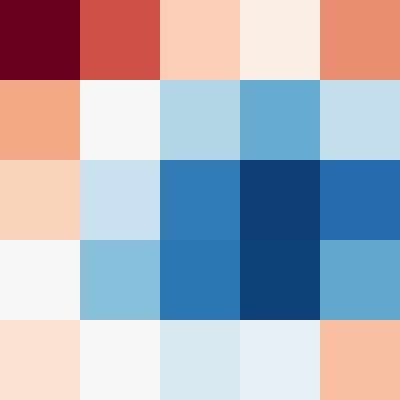
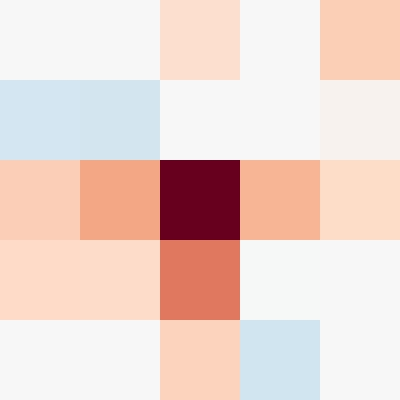
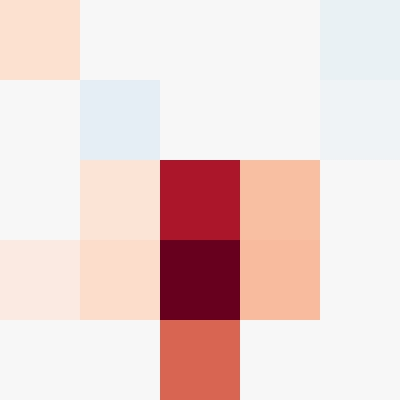
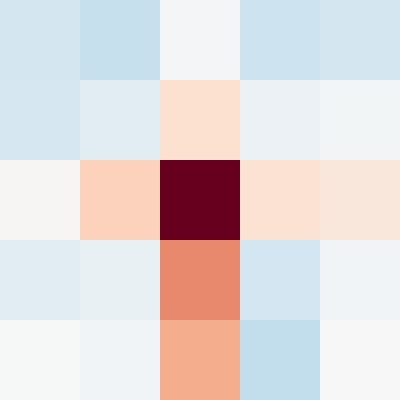
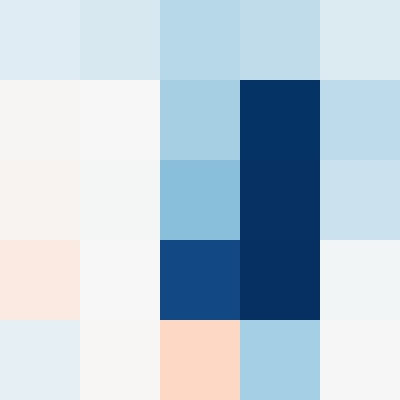
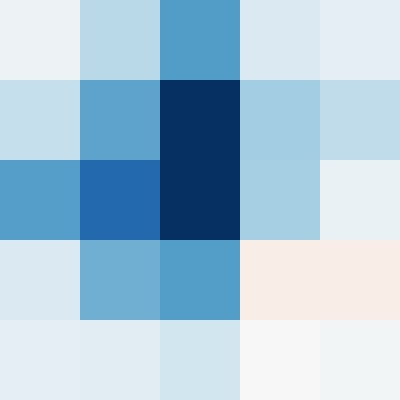
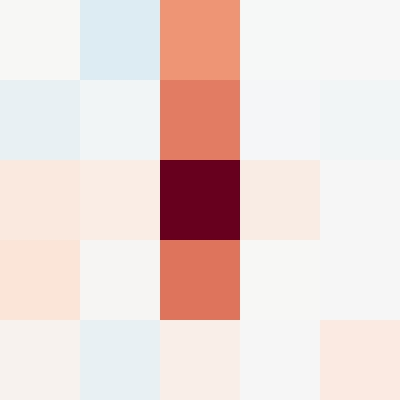
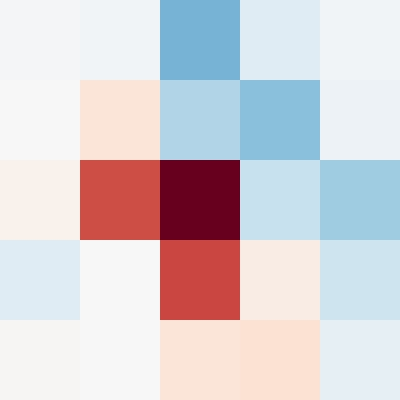
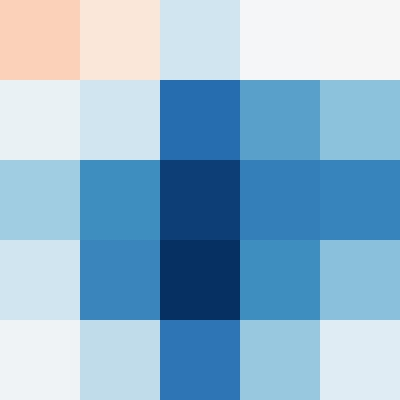
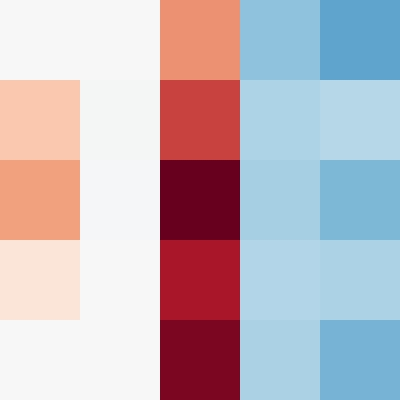
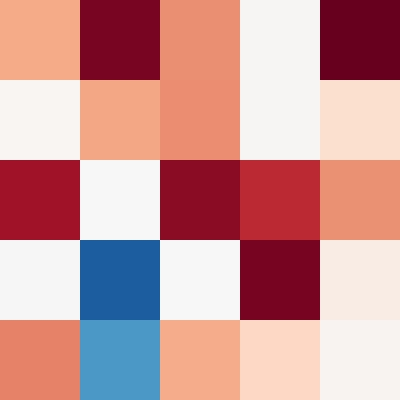
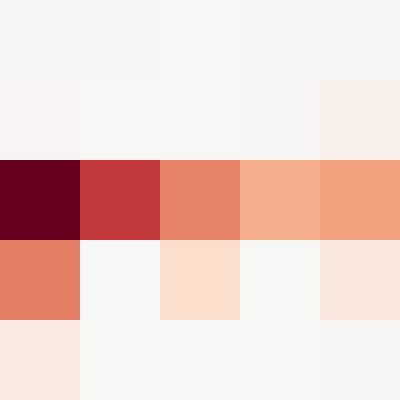
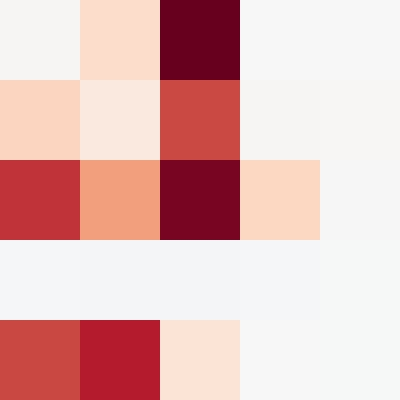
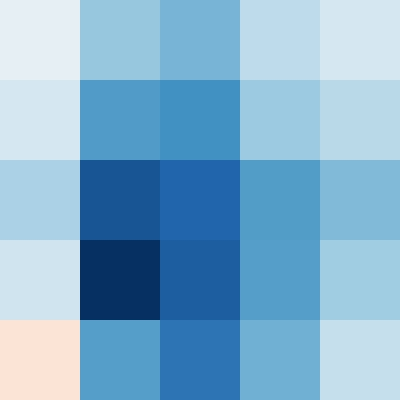
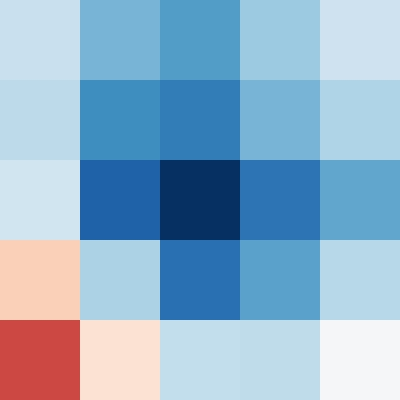
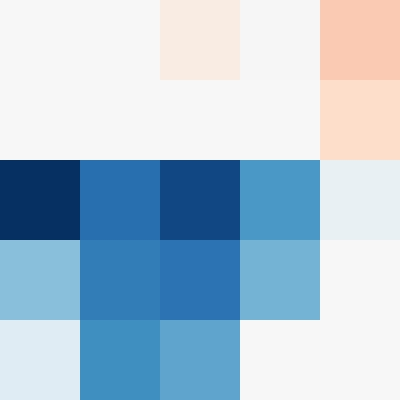
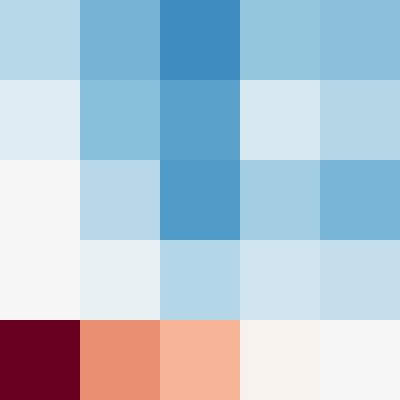
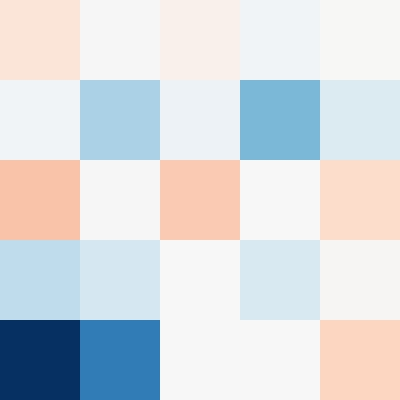
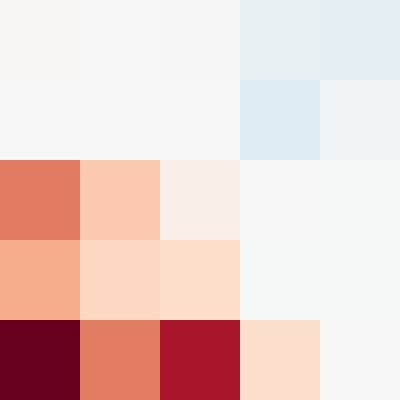
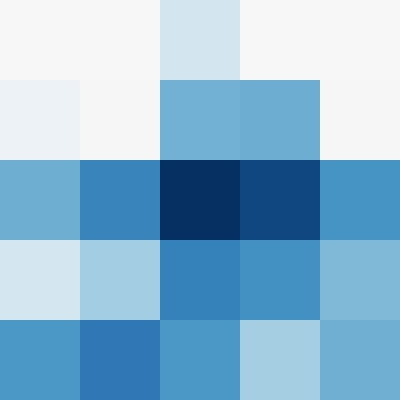
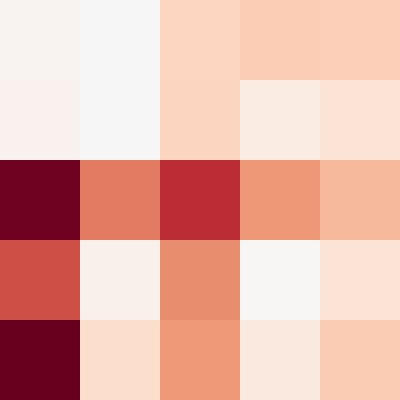
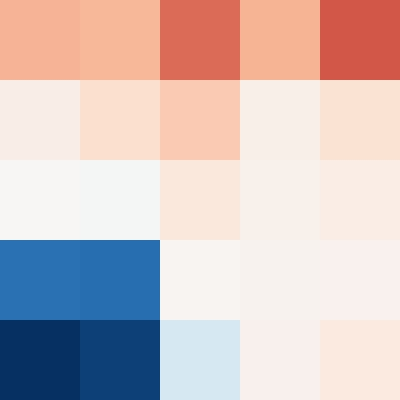
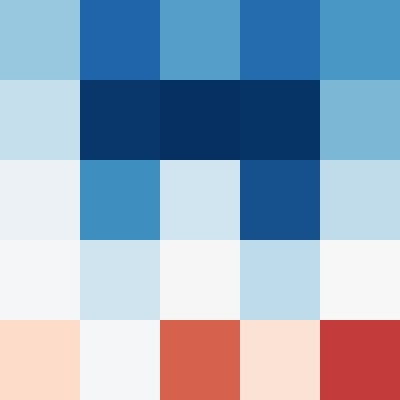
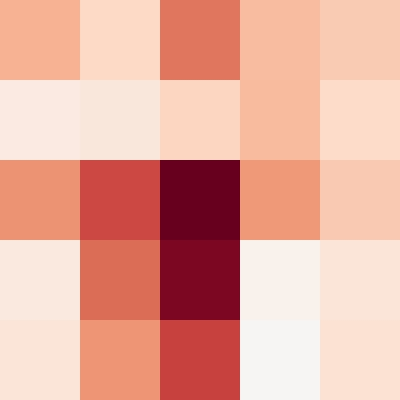
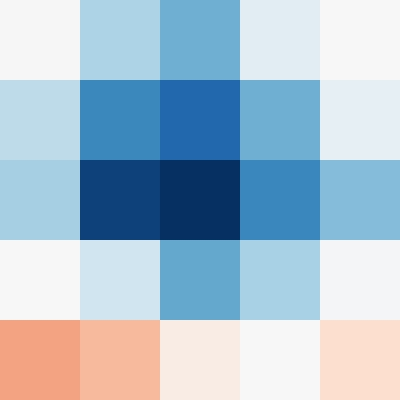
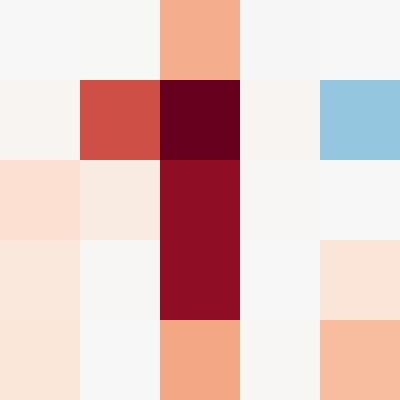
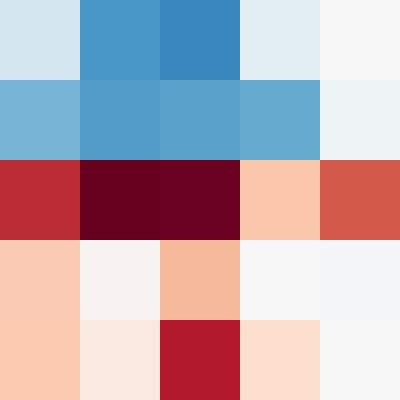
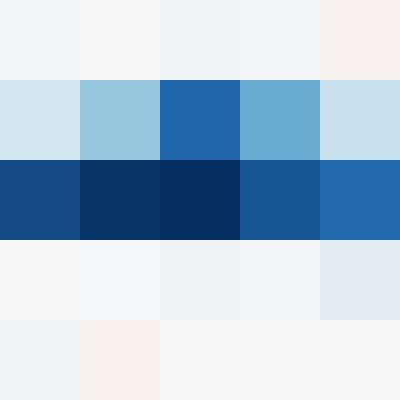
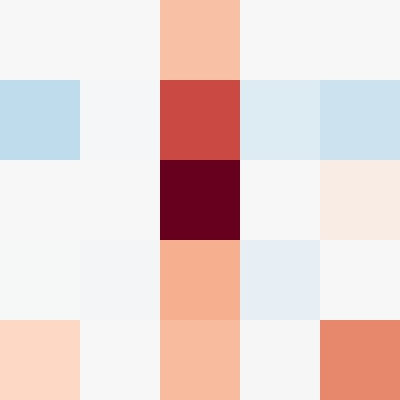
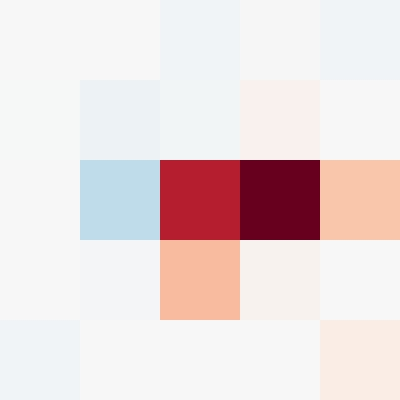
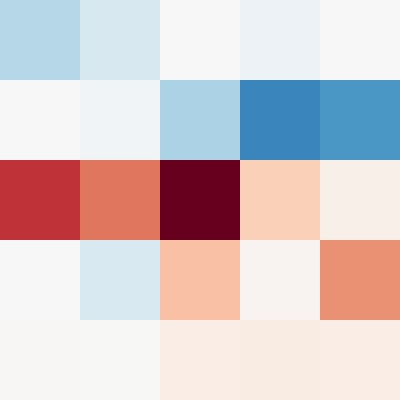
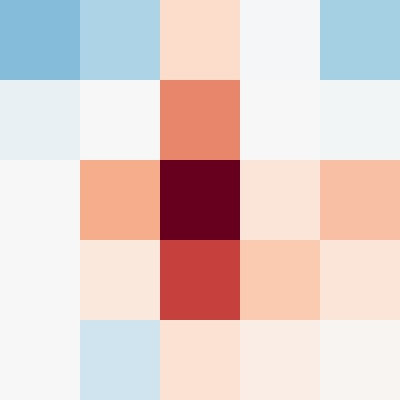
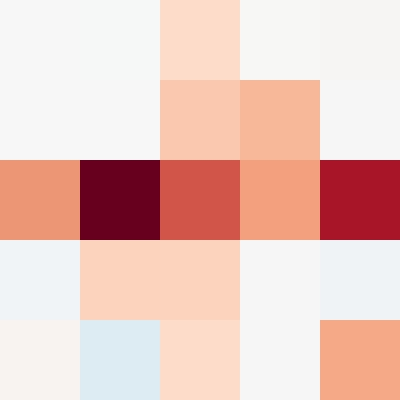
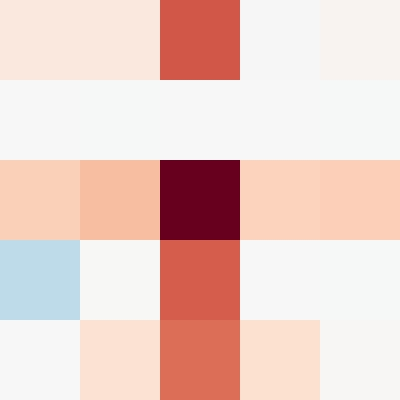
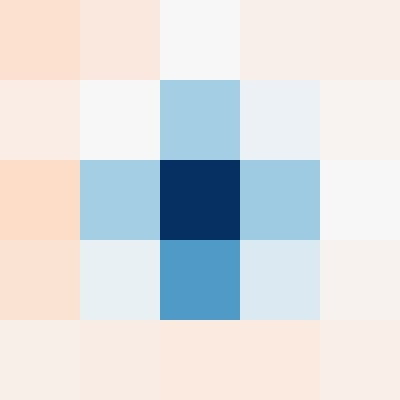
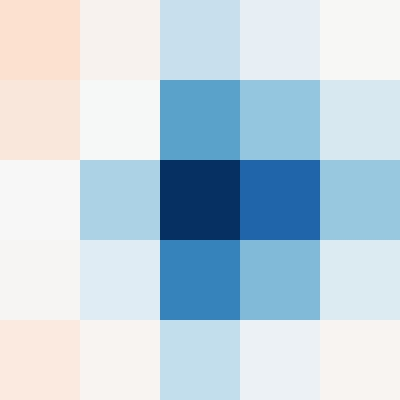
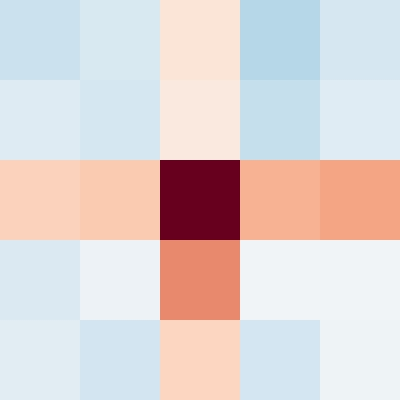
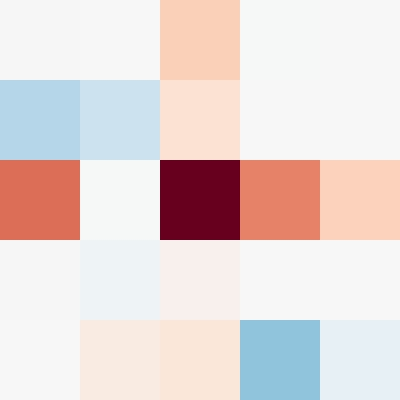
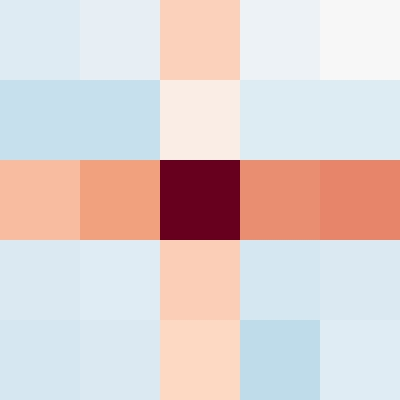
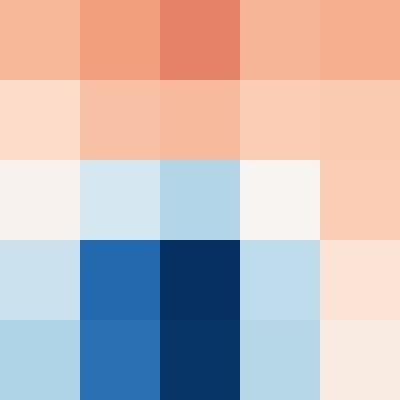
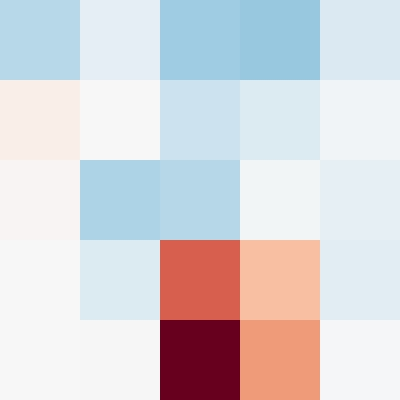
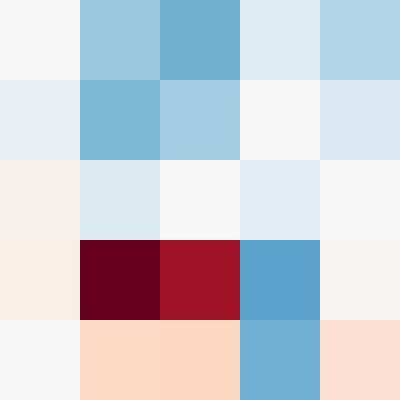
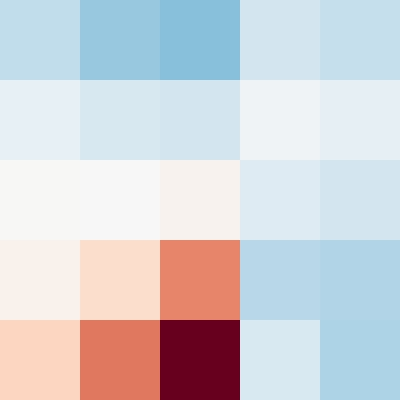
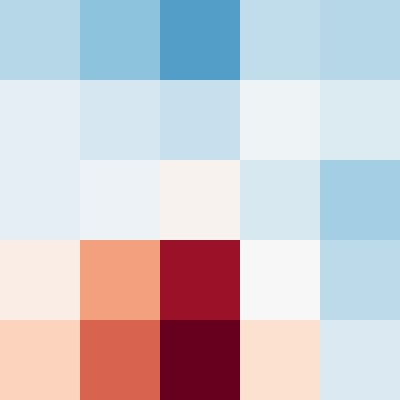
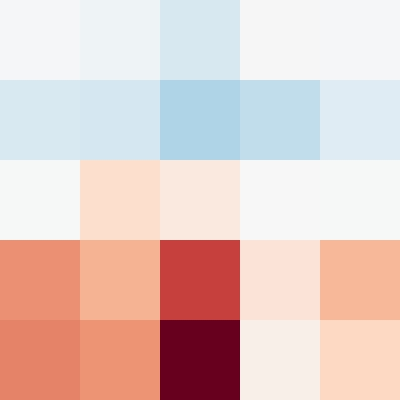
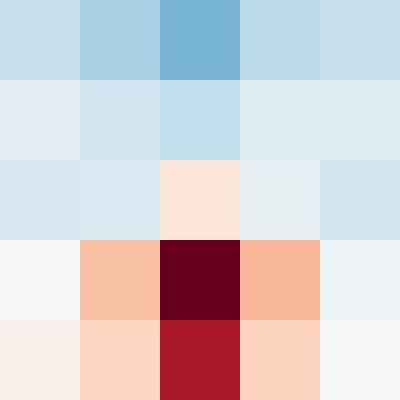
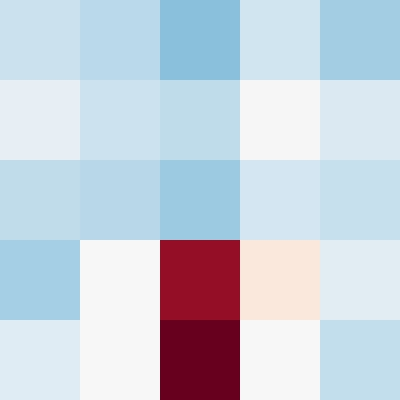
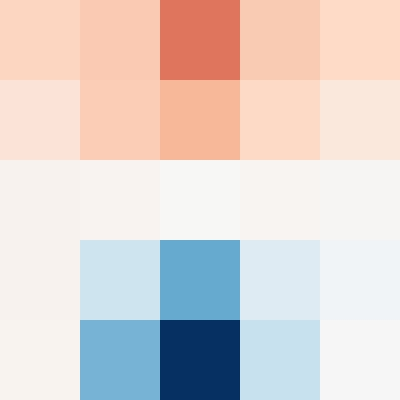
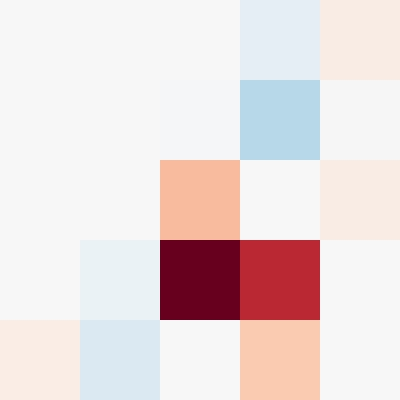
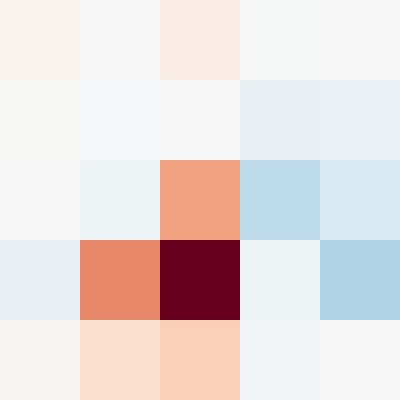
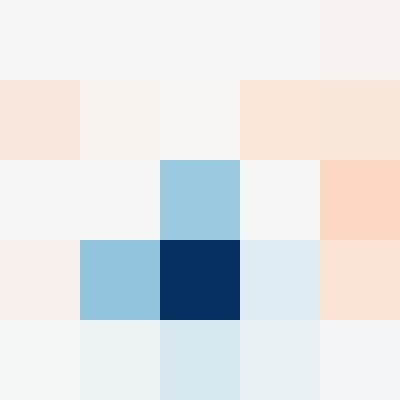
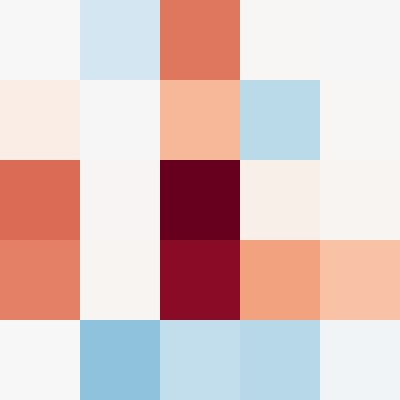
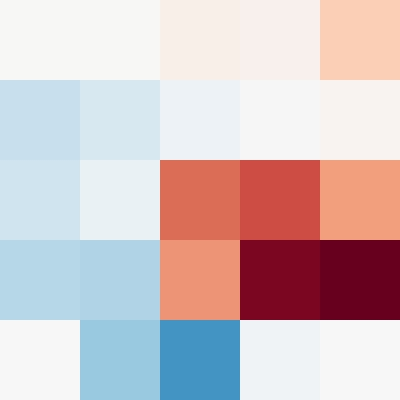
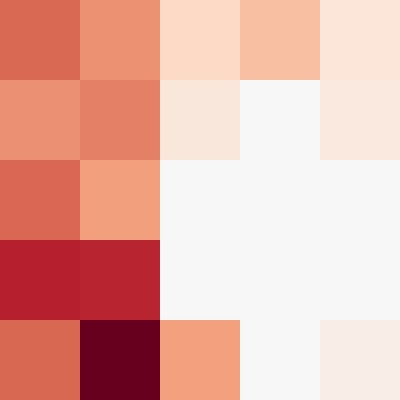
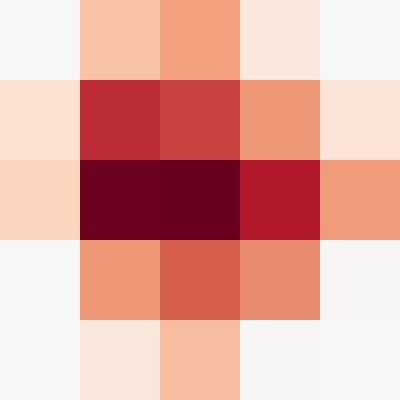
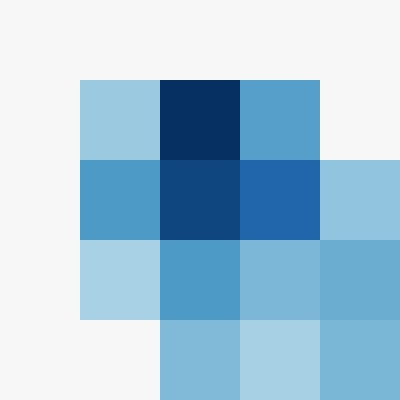
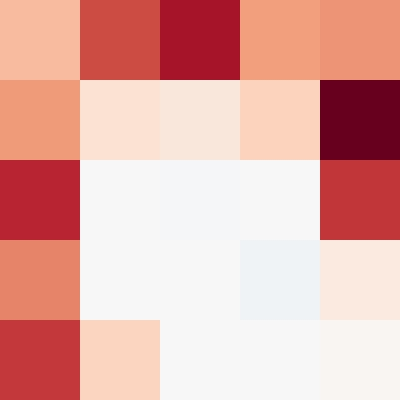
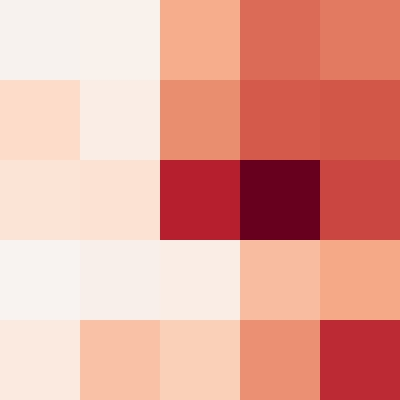
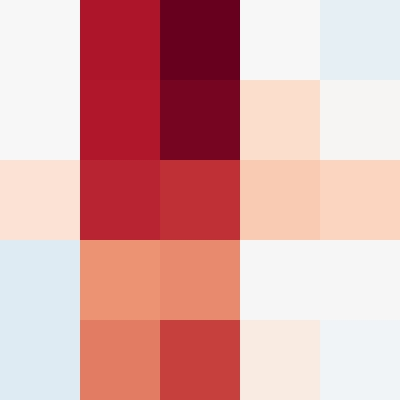
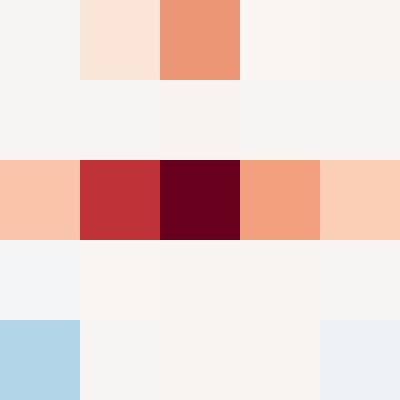
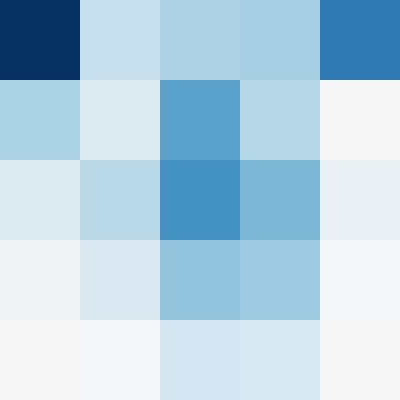
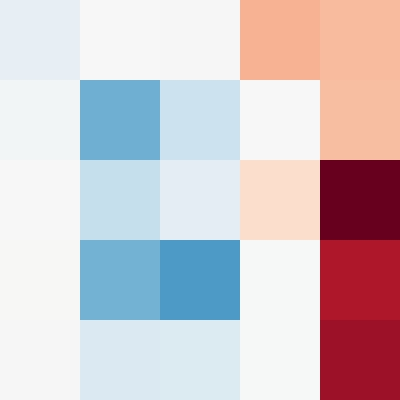
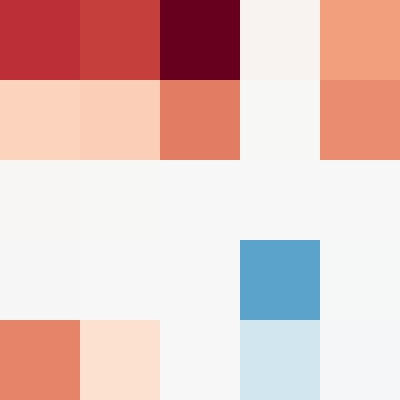
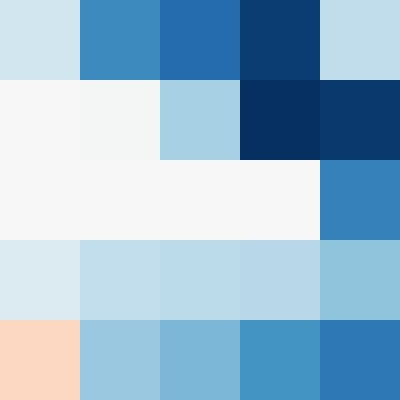
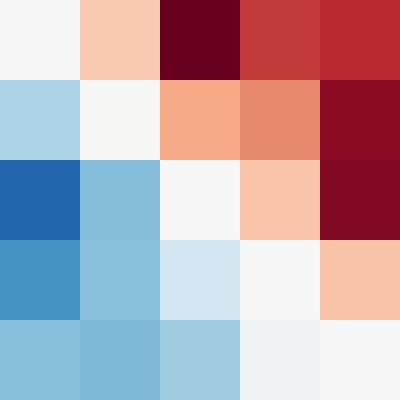
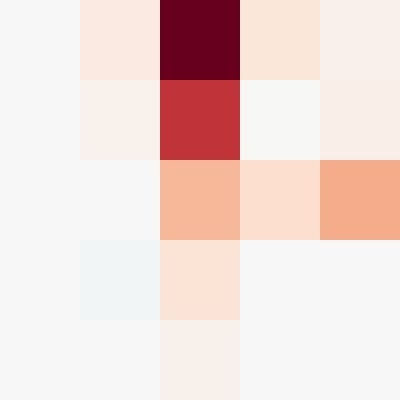
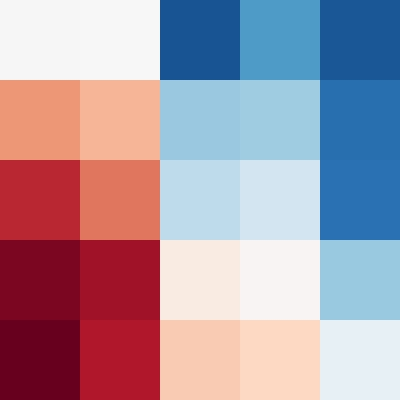
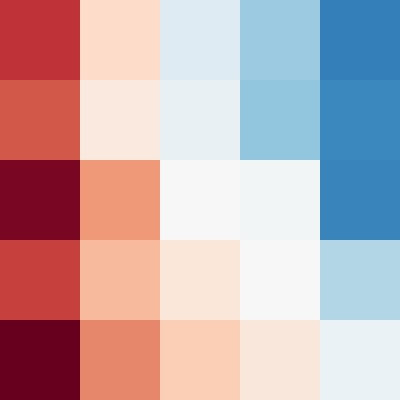
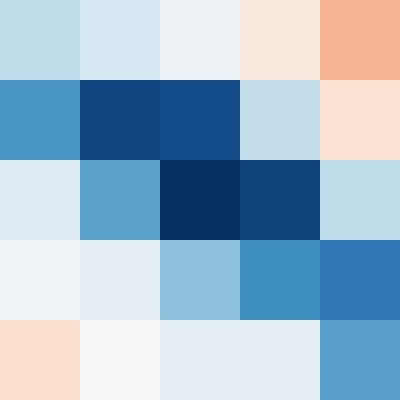
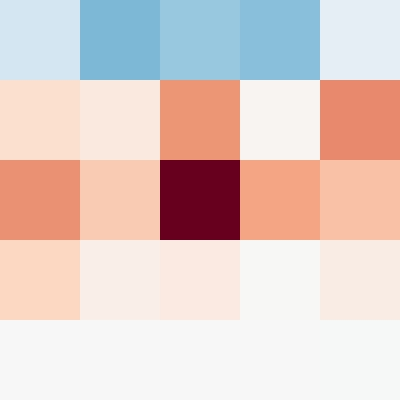
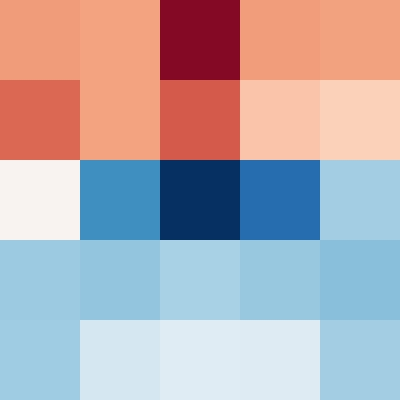
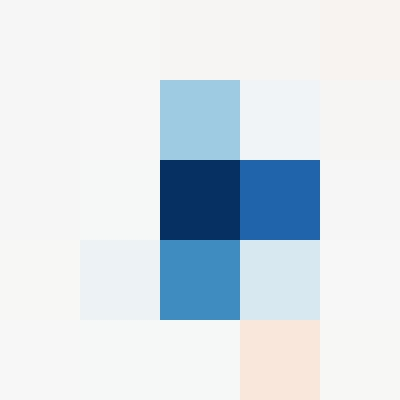
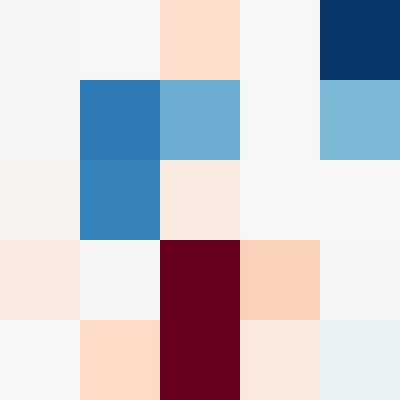
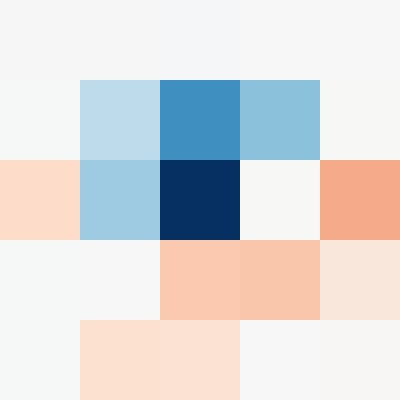
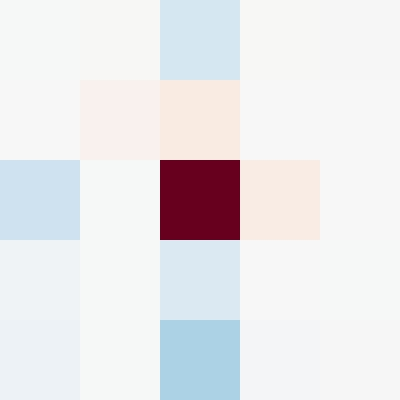
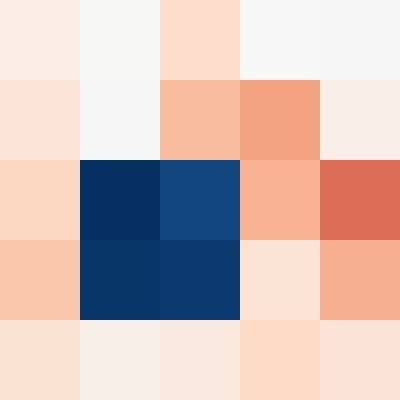
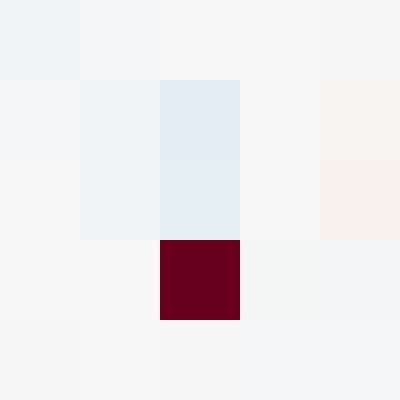
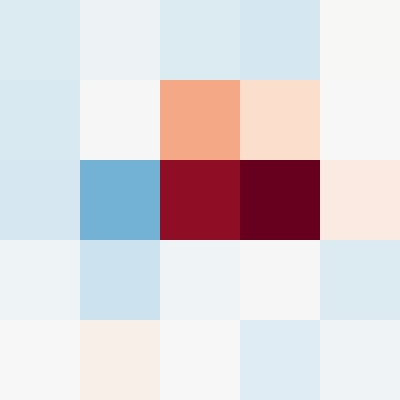
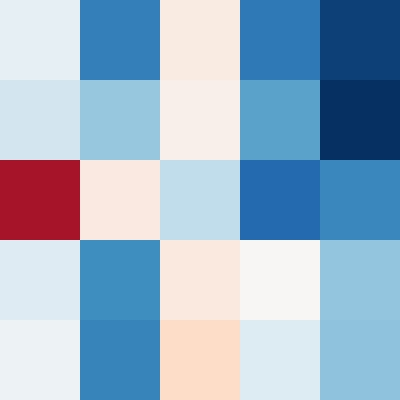
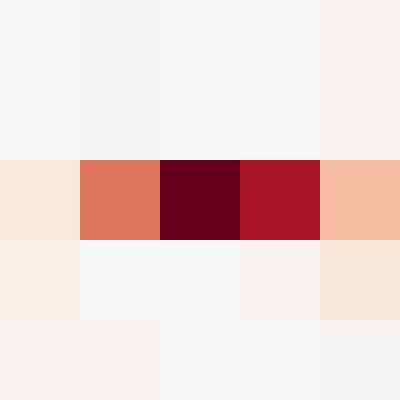
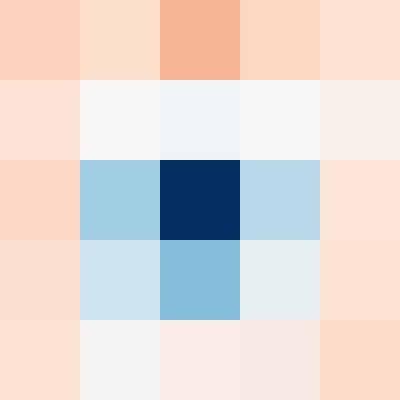
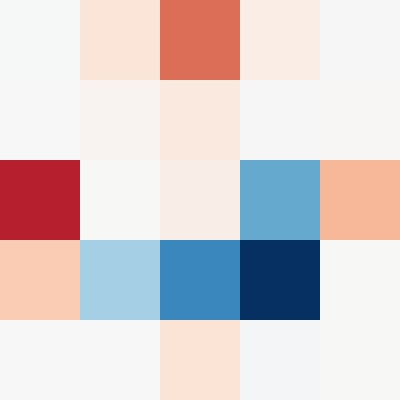
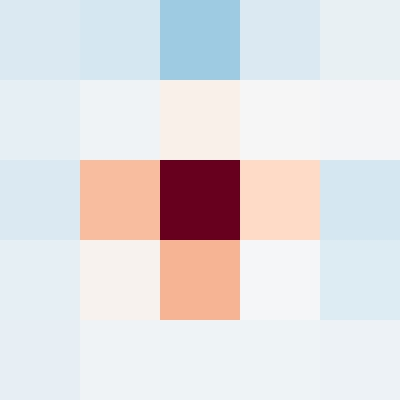
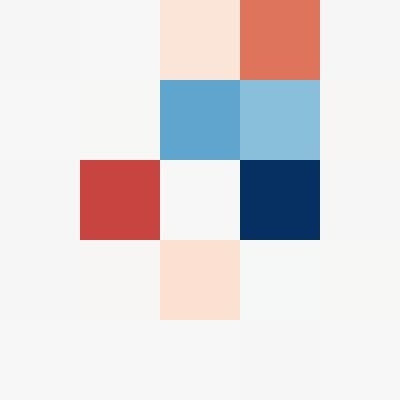
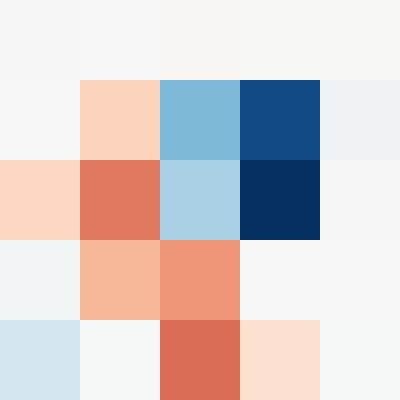
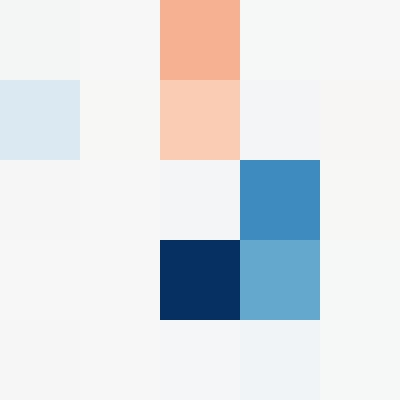
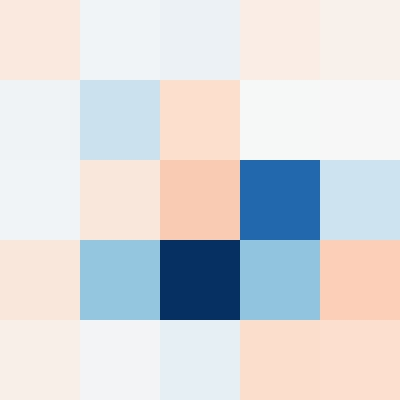
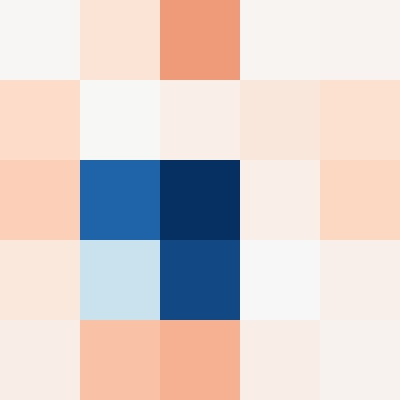
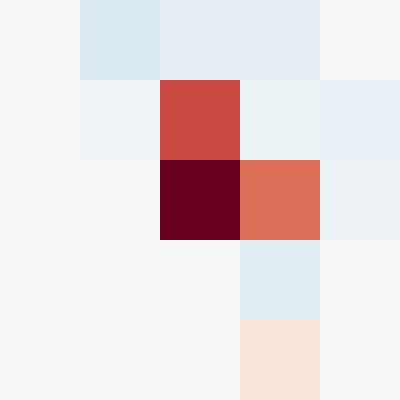
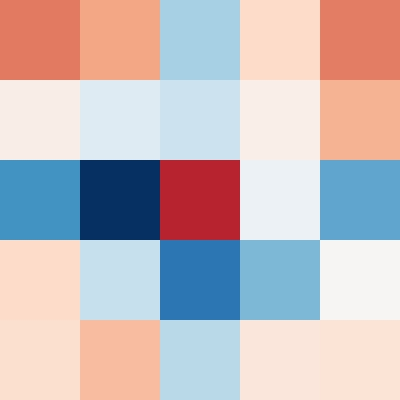
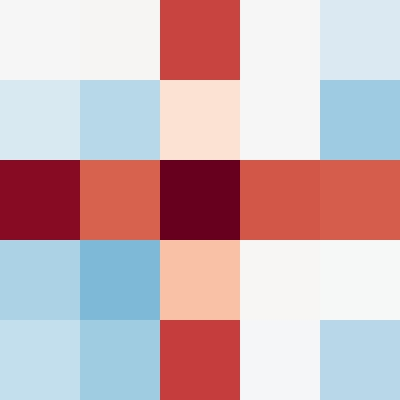
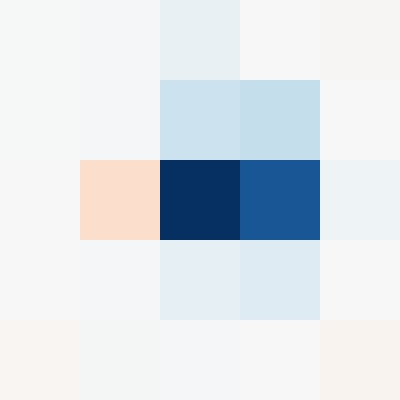
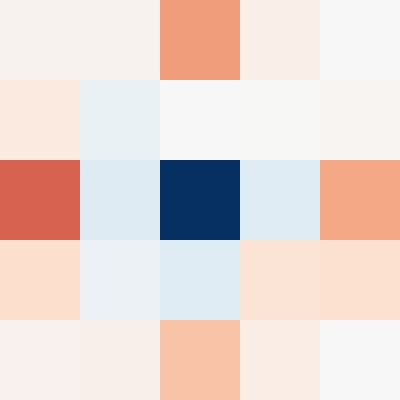
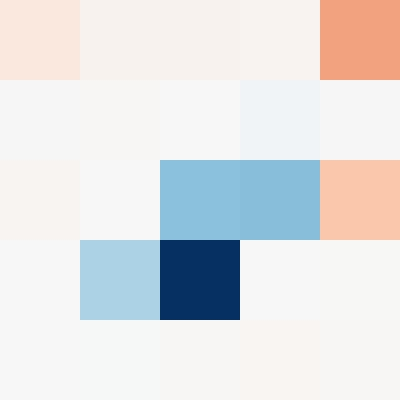
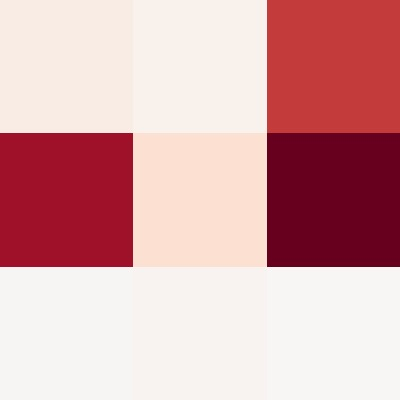
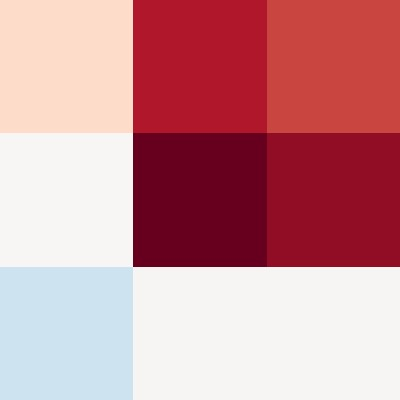
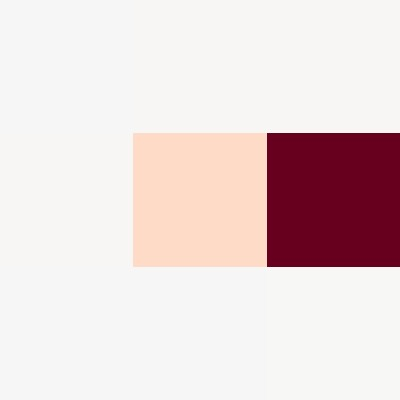
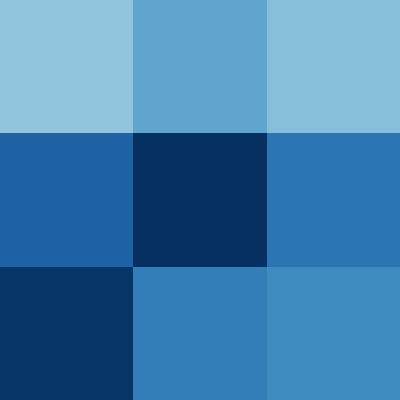
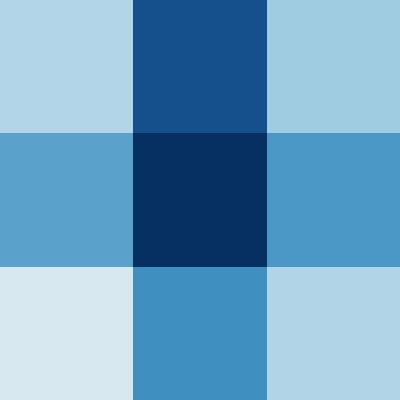
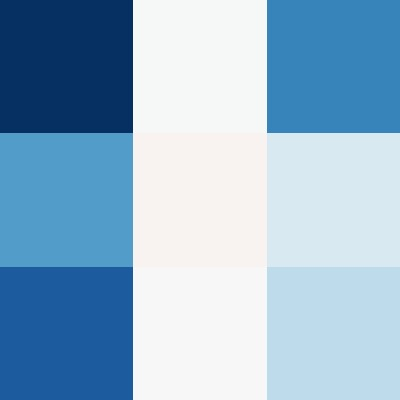
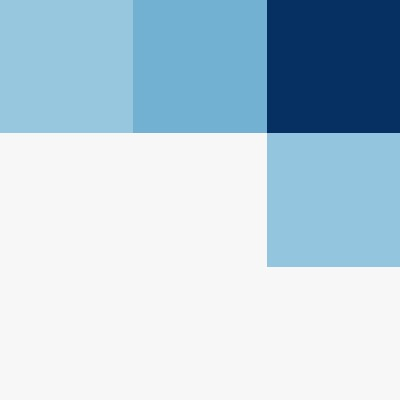
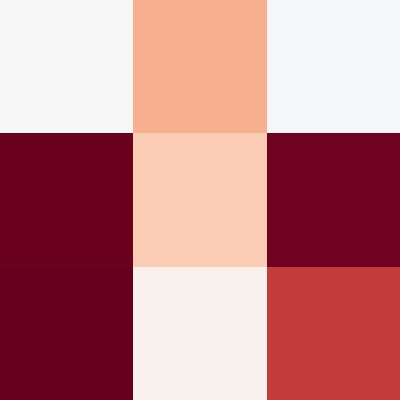
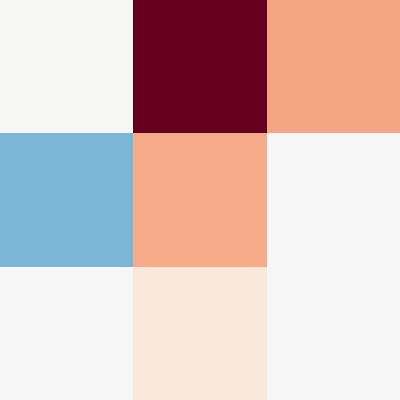
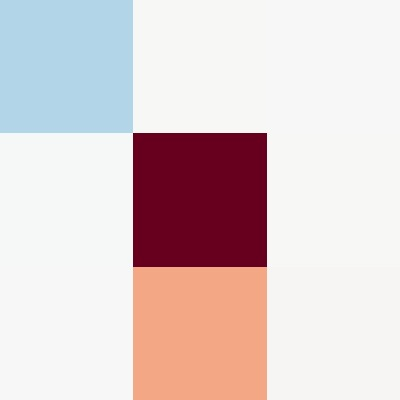
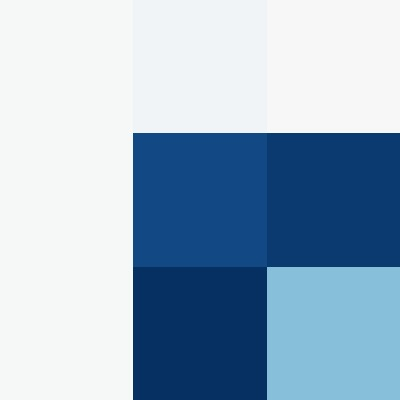
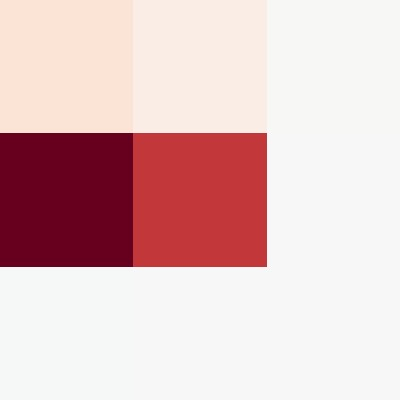
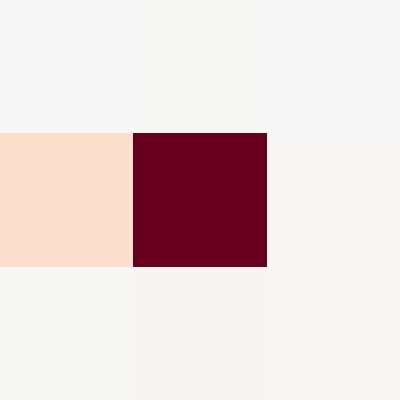
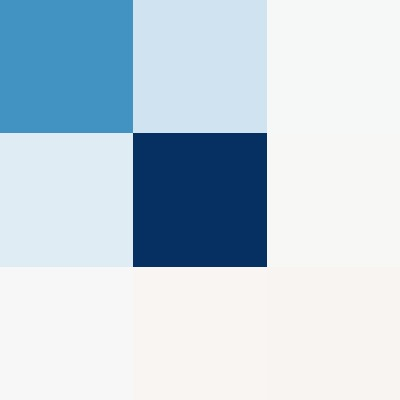
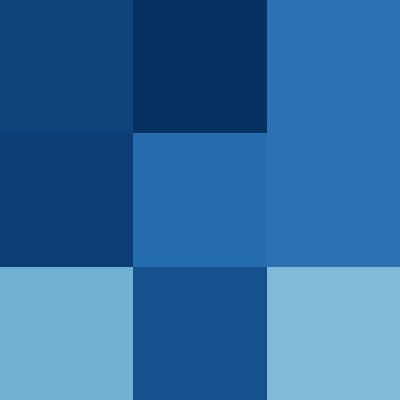
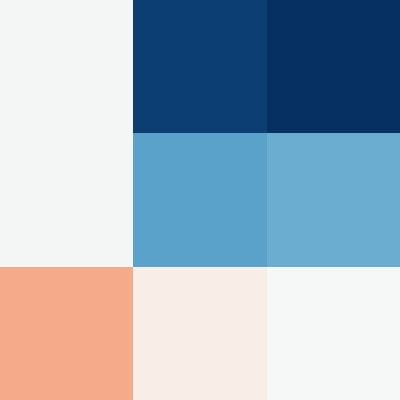
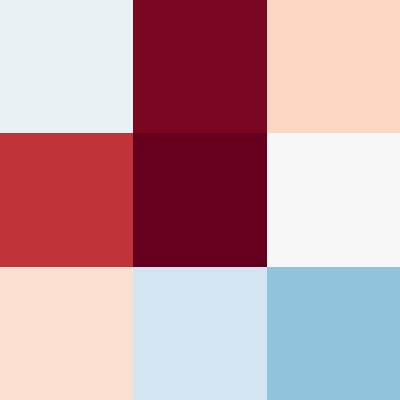
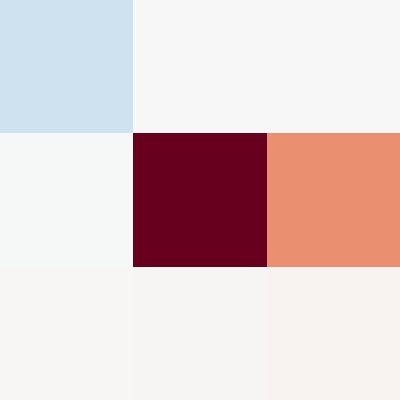
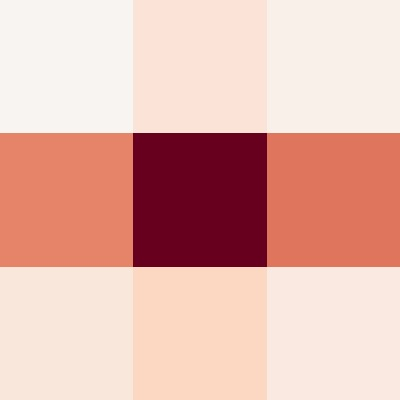
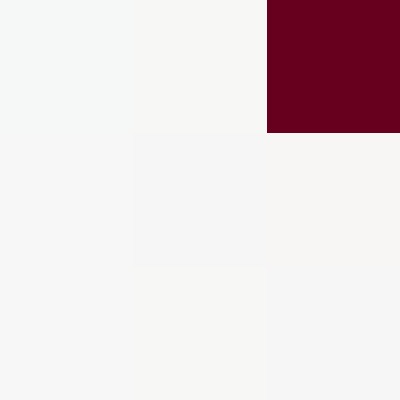
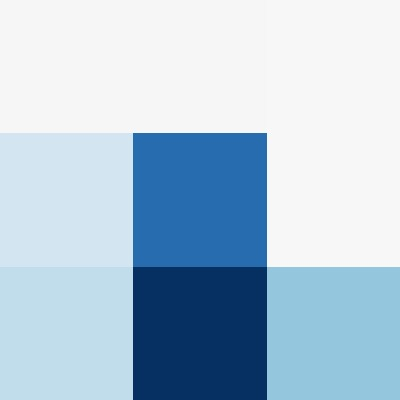
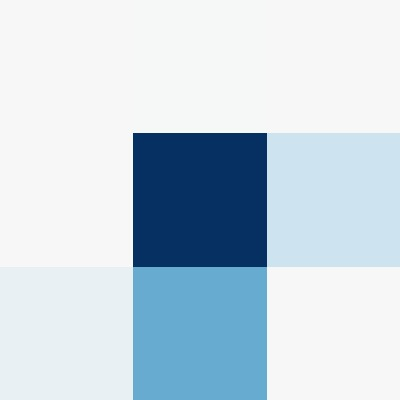
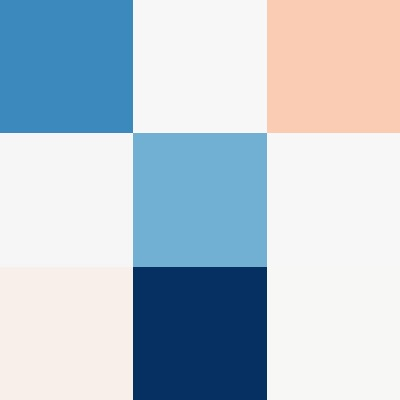
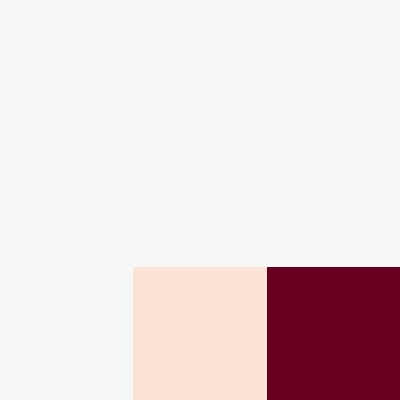
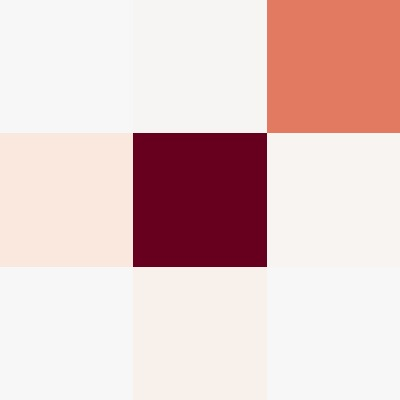
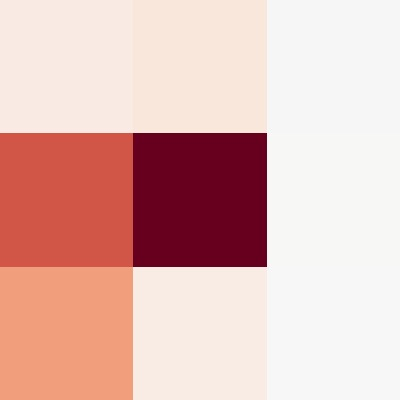
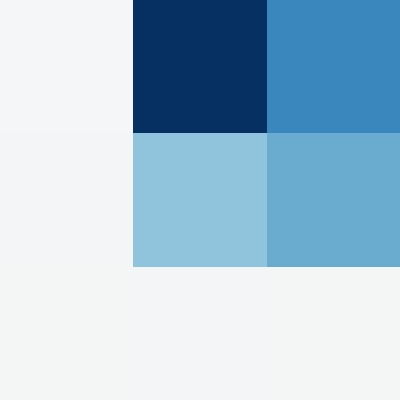
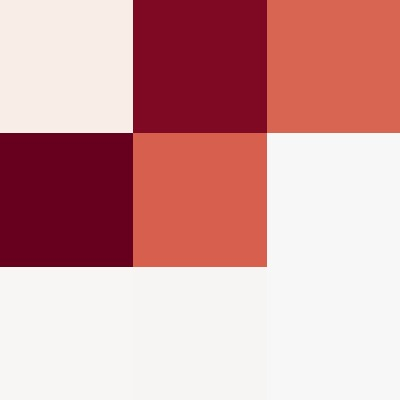
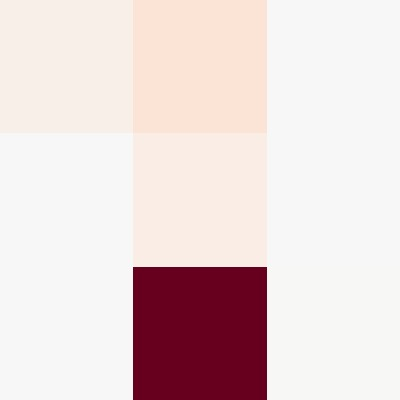
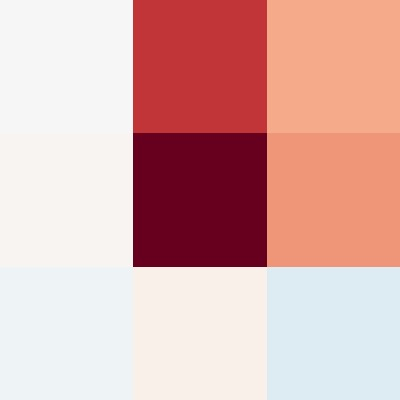
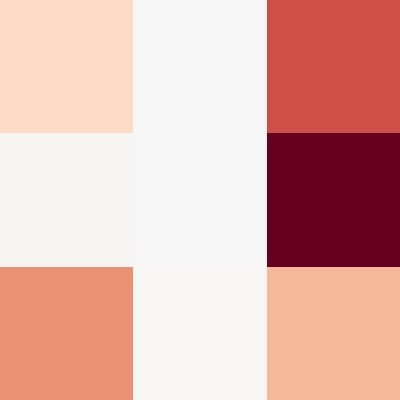
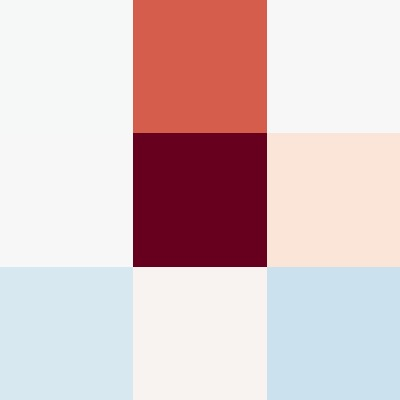
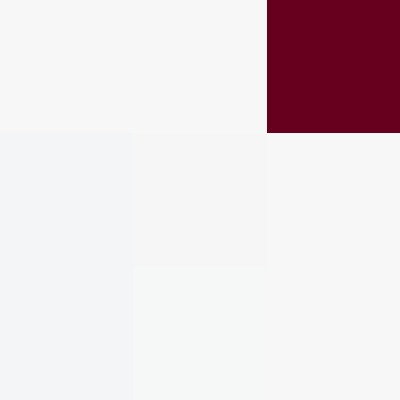
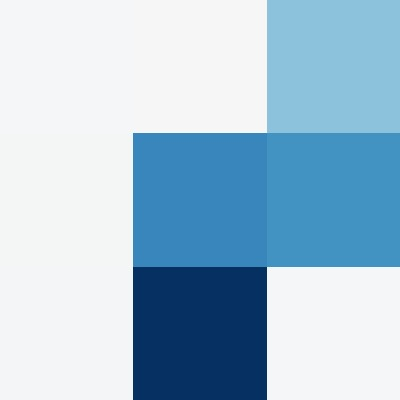
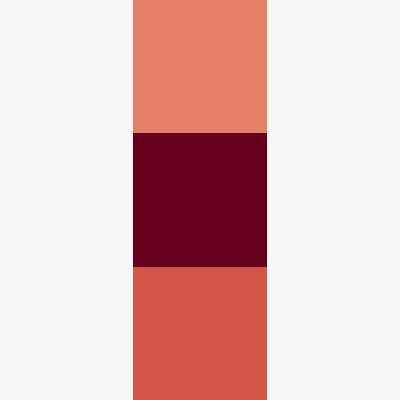
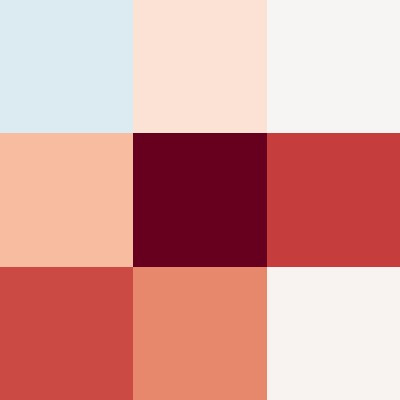
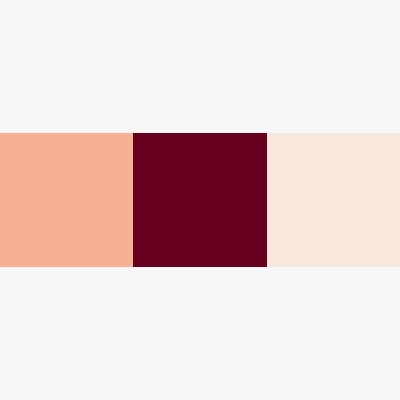
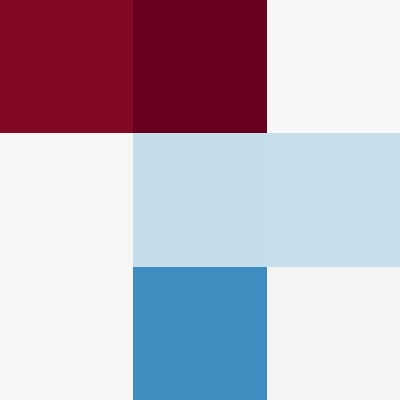
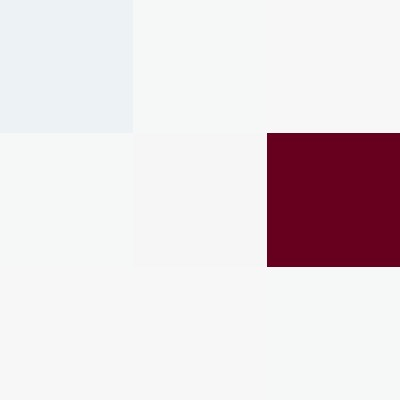
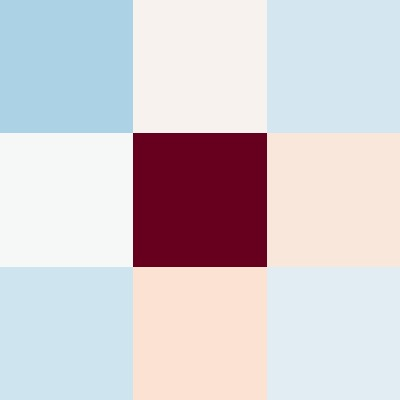
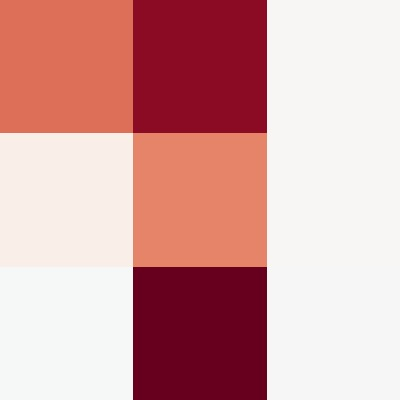
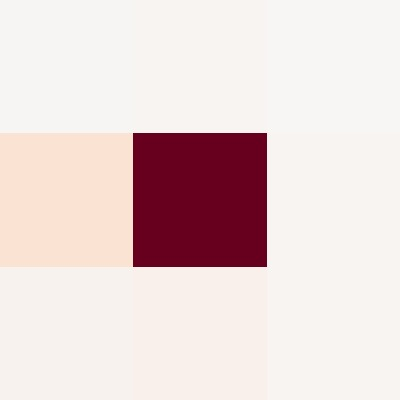
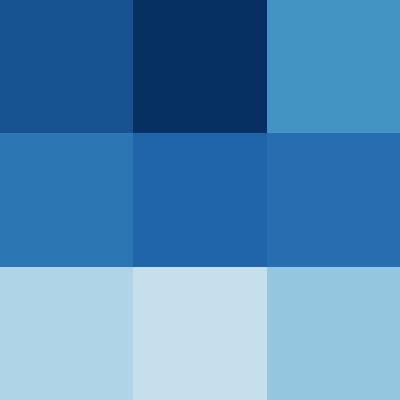
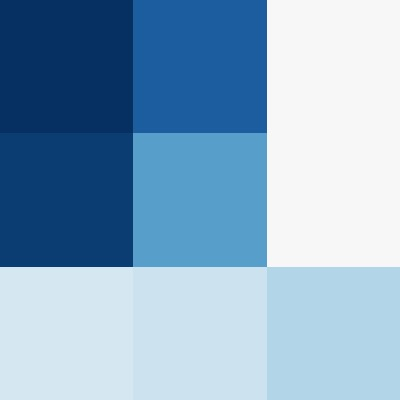
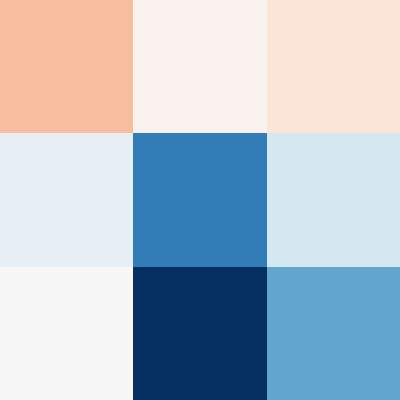
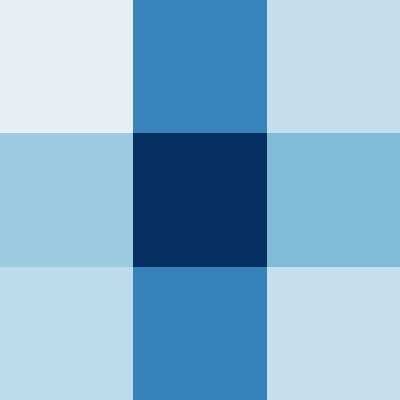

In [142]:
circuit_diagram.update_layout(height = 1000, width=2000, showlegend=False)

circuit_diagram


In [55]:
#hardware
device = 'cuda:0'

from circuit_pruner.utils import load_config

config = load_config('/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/configs/alexnet_sparse_config.py')
model = config.model.to(device)



#general
import torch
import os
from copy import deepcopy
from circuit_pruner.force import setup_net_for_circuit_prune, show_model_layer_names

In [60]:
from circuit_pruner.utils import filterid_2_perlayerid

layer = 'features_6'
unit = 56

feature_targets = {layer:[unit]}

In [61]:
import os

general_ranks_folder = '../../circuit_ranks/alexnet_sparse/imagenet_2/actxgrad/'
general_rank_files = os.listdir(general_ranks_folder)
for file in general_rank_files:
    if '_'+layer+':'+str(unit)+'_' in file:
        print('found')
        general_ranks = torch.load(general_ranks_folder+file)
        break

found


In [62]:
from circuit_pruner.extraction import model_ranks_2_circuit_model
from circuit_pruner.utils import circuit_2_model_sparsity

sparsity = .9

general_circuit,general_mask = model_ranks_2_circuit_model(general_ranks,sparsity,model,
                                                                     feature_targets,device,structure='edges',
                                                                     use_effective_mask=True)

general_circuit = general_circuit.eval().to('cpu')

for l in general_mask:
    l = l.to('cpu')
    
    
circuit_feature_targets = {layer:[0]}
circuit_unit = 0

general_circuit_sparsity_factor = circuit_2_model_sparsity(general_circuit,model)

features_6 effective last layer
target sparsity: 0.9
total params to feature: 12672

kept params in original mask: 11405      (total params * sparsity)
original mask: 300460 params
effective mask: 300460 params
effective_sparsity: 0.8999368686868687
filter sparsity: 1.0
kernel sparsity: 0.8999368686868687


------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:14<00:00, 35.67it/s]



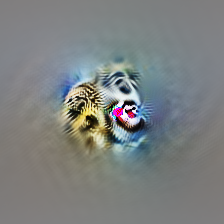

(13, 13)
(6, 6)
[(62.0, 161.0), (62.0, 161.0)]


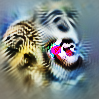

In [63]:
from circuit_pruner.visualizer.featureviz  import featviz_in_recep_field


featviz_in_recep_field(deepcopy(general_circuit),layer,circuit_unit,margin=0)

In [13]:
import torch

old_subgraph_folder = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/subgraphs/models/'

subgraph_dict = torch.load(old_subgraph_folder+'312_0.60.8.pt')

In [14]:

old_subgraph = subgraph_dict['model']
old_subgraph

Sequential(
  (conv_0): Conv2d(3, 15, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (relu_1): ReLU()
  (pool_1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_1): Conv2d(15, 18, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(18, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [15]:
def rename_attribute(obj, old_name, new_name):
    obj._modules[new_name] = obj._modules.pop(old_name)

In [16]:
rename_attribute(old_subgraph,'conv_0','features_0')
rename_attribute(old_subgraph,'relu_1','features_1')
rename_attribute(old_subgraph,'pool_1','features_2')
rename_attribute(old_subgraph,'conv_1','features_3')
rename_attribute(old_subgraph,'relu_2','features_4')
rename_attribute(old_subgraph,'pool_2','features_5')
rename_attribute(old_subgraph,'conv_2','features_6')

In [17]:
old_subgraph

Sequential(
  (features_0): Conv2d(3, 15, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (features_1): ReLU()
  (features_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_3): Conv2d(15, 18, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (features_4): ReLU()
  (features_5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_6): Conv2d(18, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [18]:
node_df = subgraph_dict['node_df']
edge_df = subgraph_dict['edge_df']
#df.rename(columns={"A": "a", "B": "c"})
node_df = node_df.rename(columns={"actxgrad_rank": "norm_rank"})
edge_df = edge_df.rename(columns={"actxgrad_rank": "norm_rank"})

edge_ranks = []
for layer in ['features_0','features_3','features_6']:
    edge_ranks.append(torch.from_numpy(np.array(edge_df.loc[edge_df['layer_name'] == layer]['norm_rank'])))
    
edge_ranks = minmax_norm_ranks(edge_ranks)
edge_ranks = torch.cat(edge_ranks,dim=0)
print(edge_ranks.shape)
edge_df['norm_rank'] = edge_ranks.numpy()



torch.Size([210])


In [23]:
dfs = [edge_df,node_df]

In [ ]:
# trim df

keep_ratio = .5




In [93]:
dfs = [edge_df,node_df]

edge_num  layer_name layer out_channel in_channel  act_rank  grad_rank  \
1            1  features_0     0           0          1  1.933793   0.000008   
0            0  features_0     0           0          0  1.312708   0.000008   
6            6  features_0     0           2          0  2.480993   0.000017   
7            7  features_0     0           2          1  1.523213   0.000017   
8            8  features_0     0           2          2  1.016833   0.000017   
...        ...         ...   ...         ...        ...       ...        ...   
23325    23325  features_6     2          56         93  0.229052   0.000947   
23344    23344  features_6     2          56        112  0.207033   0.000947   
23404    23404  features_6     2          56        172  0.137072   0.000947   
23412    23412  features_6     2          56        180  0.179541   0.000947   
23422    23422  features_6     2          56        190  0.203327   0.000947   

       norm_rank  
1       0.051089  
0       0.028144  
6       0.093596  
7       0.053942  
8       0.038410  
...          ...  
23325   0.035793  
23344   0.026653  
23404   0.000000  
23412   0.011735  
23422   0.026780  

[210 rows x 8 columns]

In [24]:
from circuit_pruner.visualizer.circuit_gui import *

viz_folder = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/visualization_cache/old_subgraph_312/'

circuit_diagram = launch_circuit_gui(old_subgraph,None,model,None,dfs=dfs,viz_folder=viz_folder,interactive=False,device=device)

generating feature_viz objective string for 75
found pre-generated image
generating feature_viz objective string for 78
found pre-generated image
generating feature_viz objective string for 218
found pre-generated image
generating feature_viz objective string for 210
found pre-generated image
generating feature_viz objective string for 240
found pre-generated image
generating feature_viz objective string for 253
found pre-generated image
generating feature_viz objective string for 188
found pre-generated image
generating feature_viz objective string for 157
found pre-generated image
generating feature_viz objective string for 70
found pre-generated image
generating feature_viz objective string for 189
found pre-generated image
generating feature_viz objective string for 254
found pre-generated image
generating feature_viz objective string for 214
found pre-generated image
generating feature_viz objective string for 66
found pre-generated image
generating feature_viz objective string fo


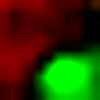
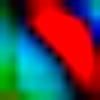
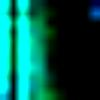
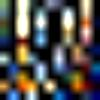
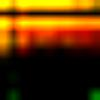
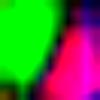
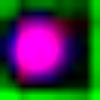
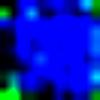
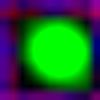
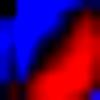
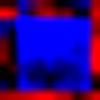
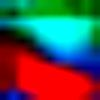
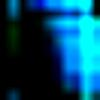
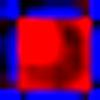
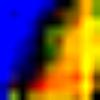
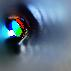
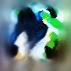
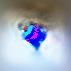
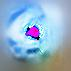
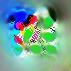
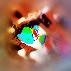
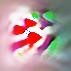
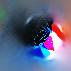
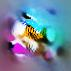
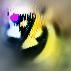
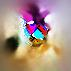
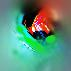
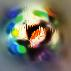
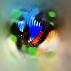
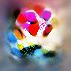
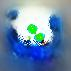
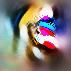
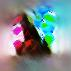
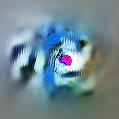
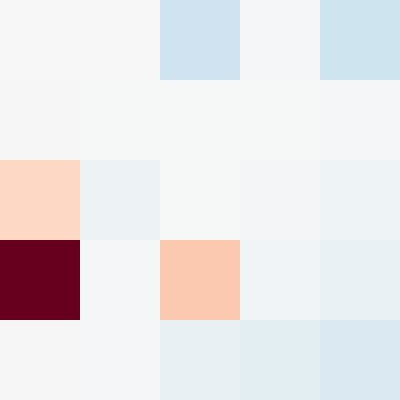
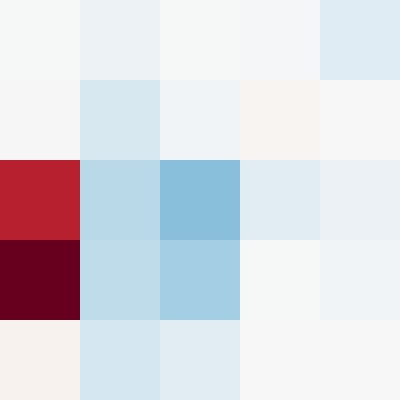
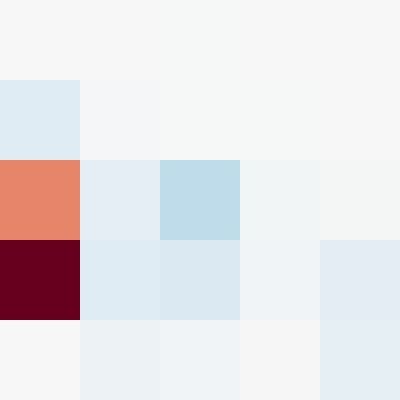
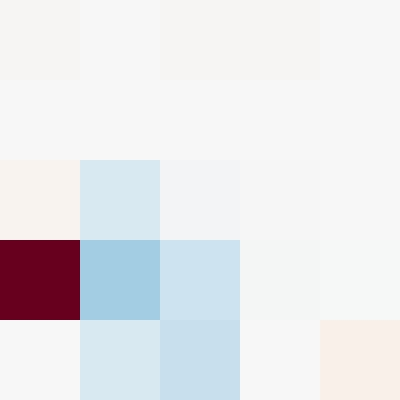
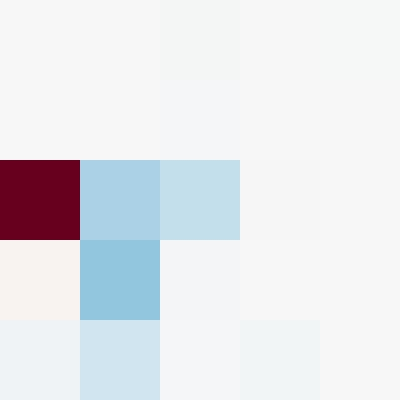
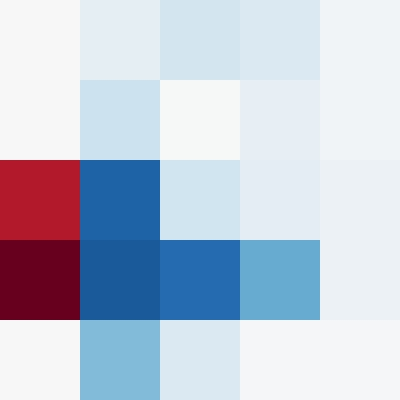
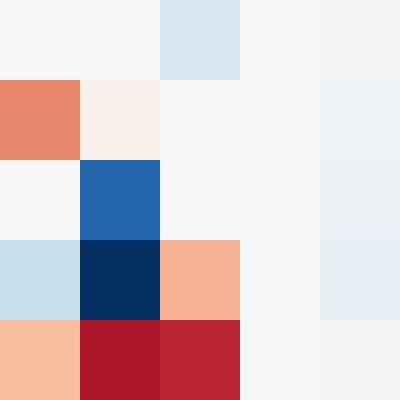
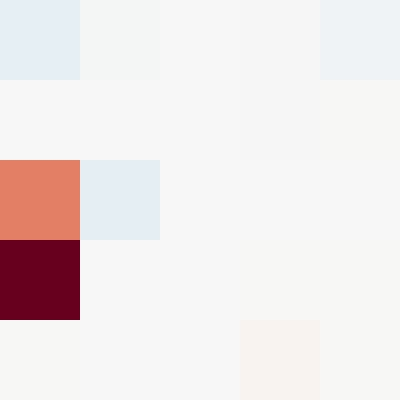
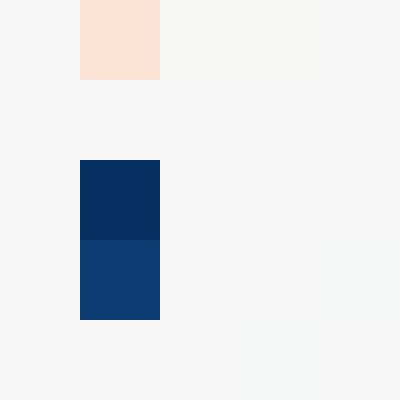
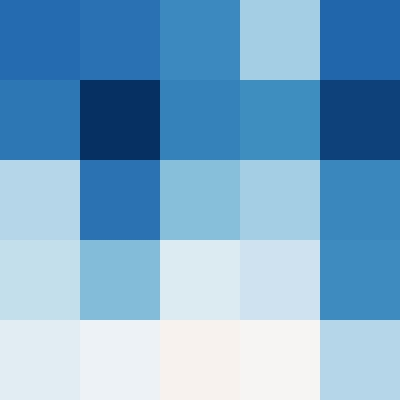
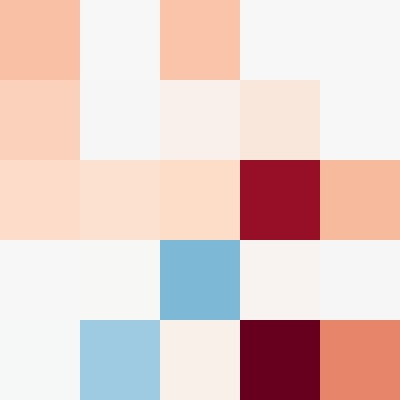
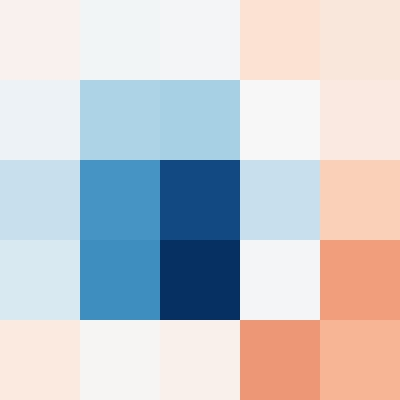
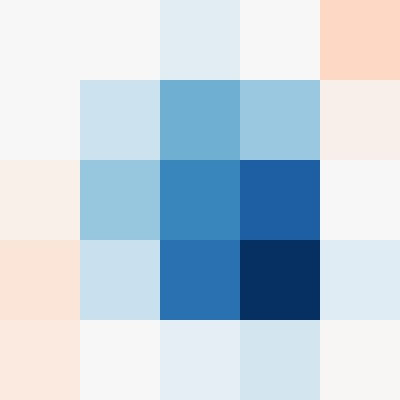
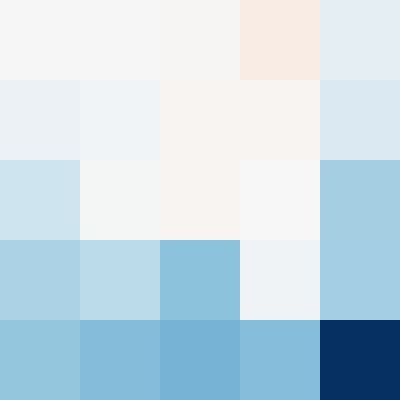
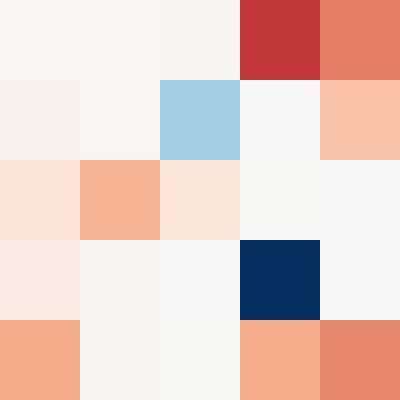
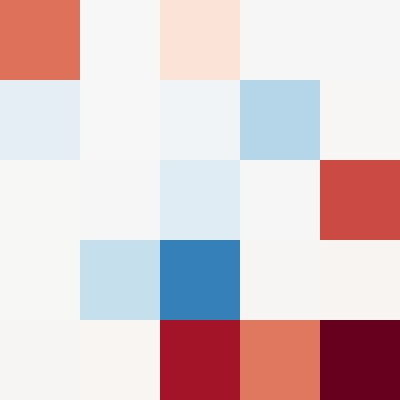
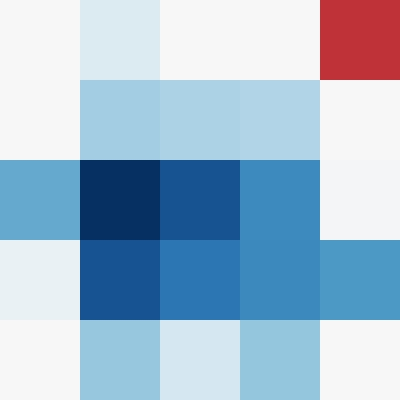
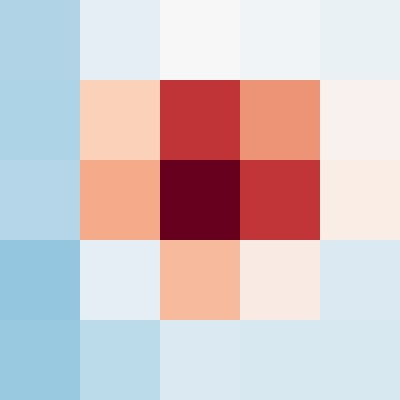
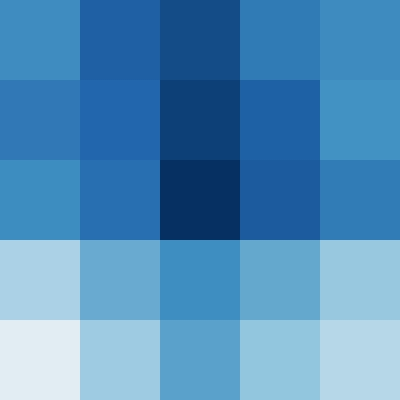
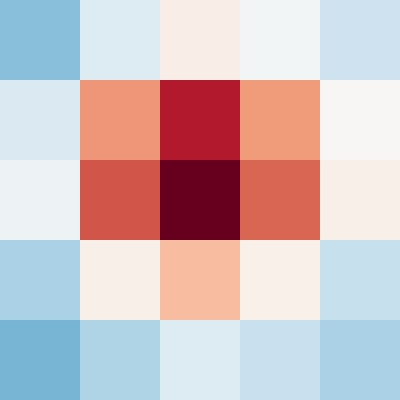
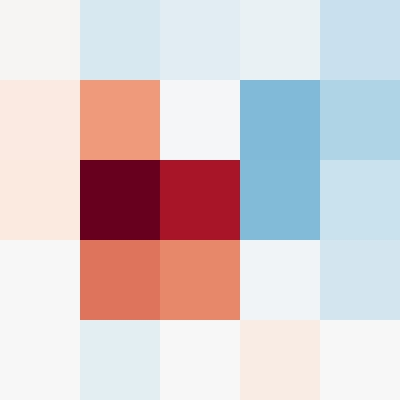
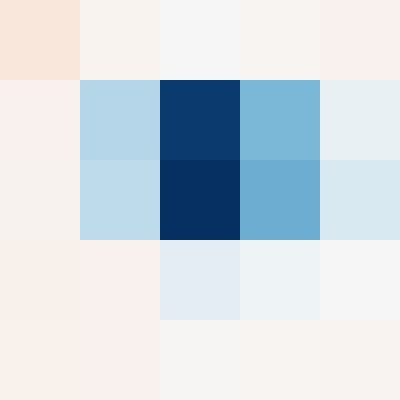
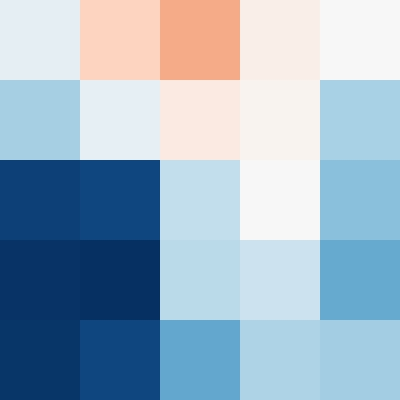
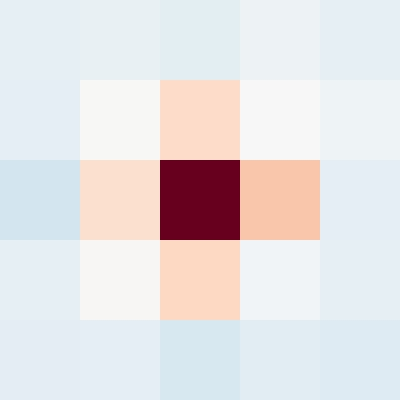
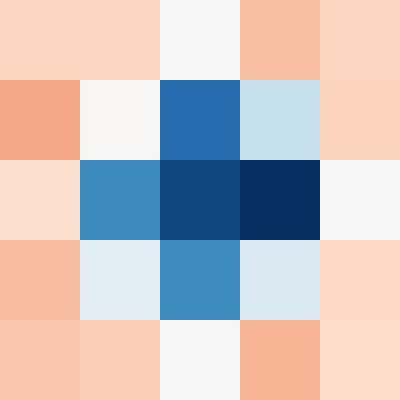
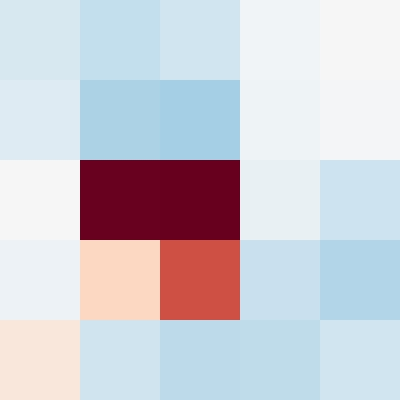
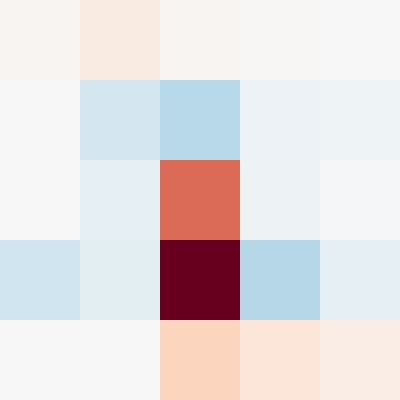
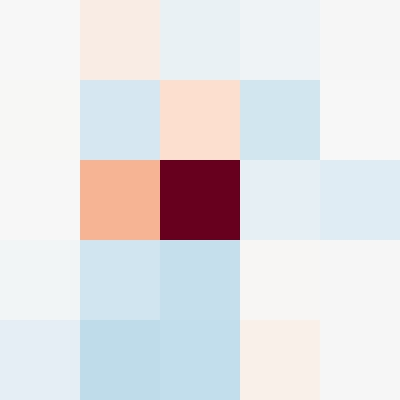
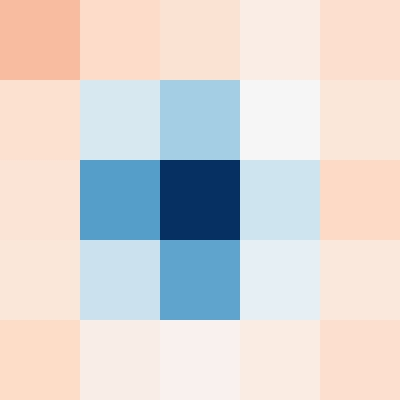
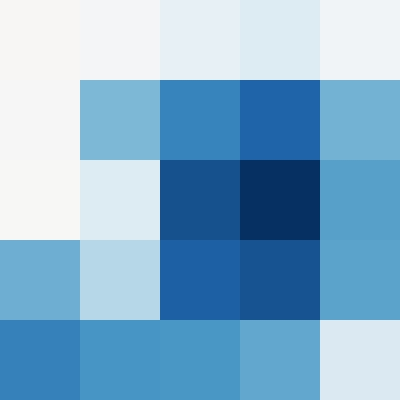
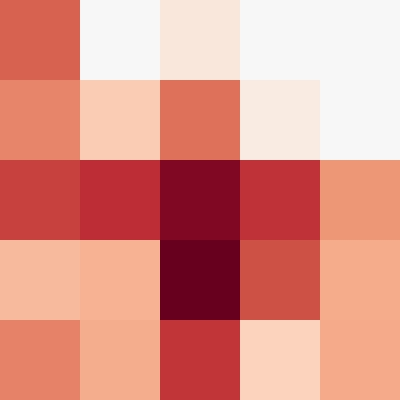
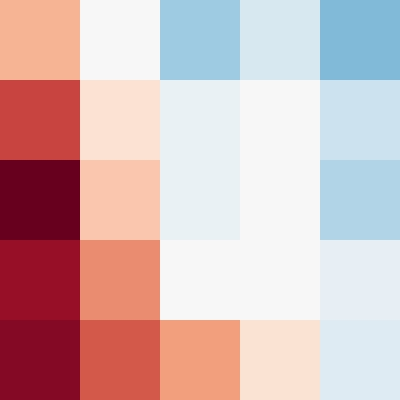
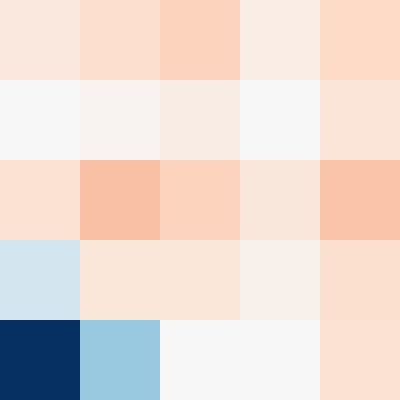
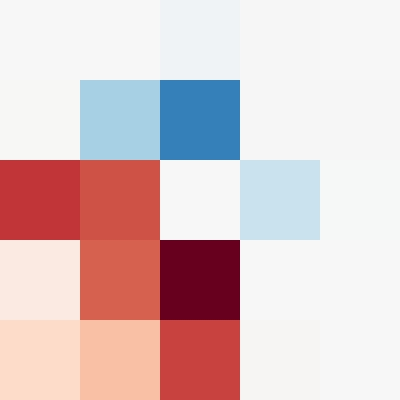
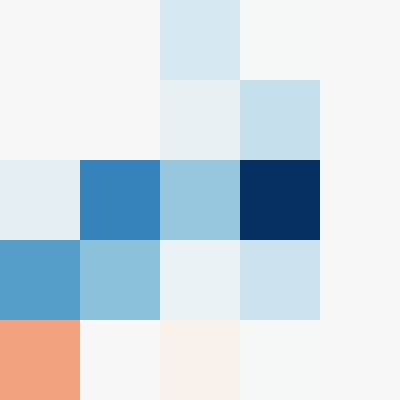
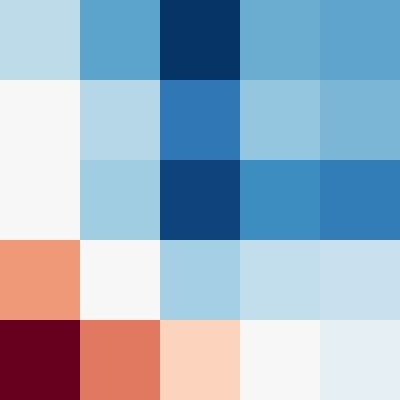
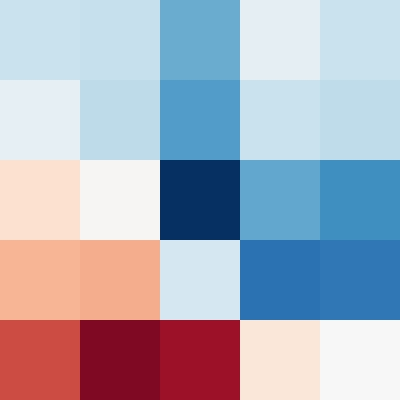
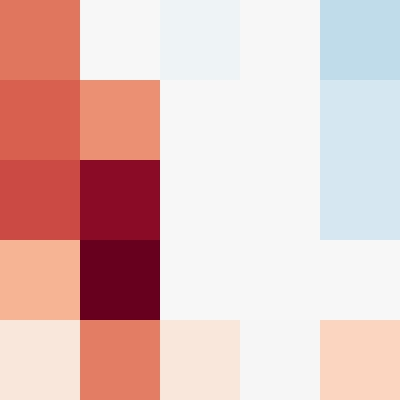
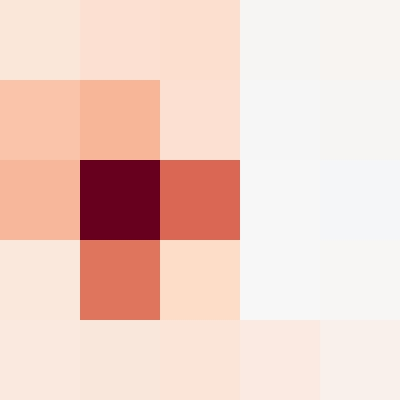
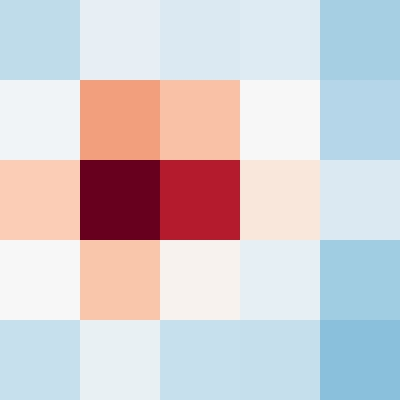
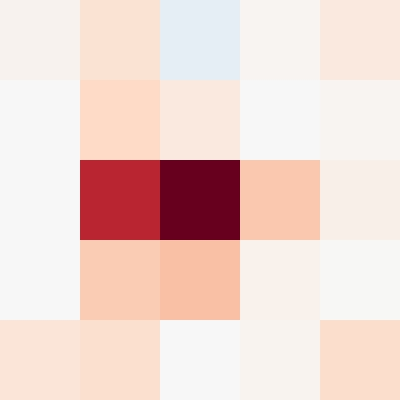
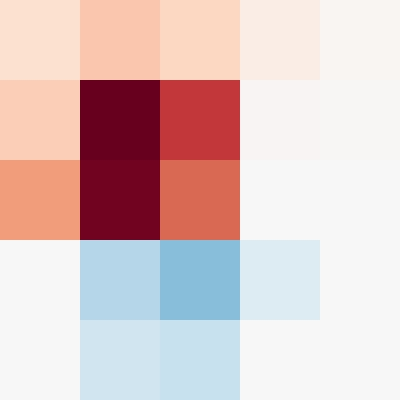
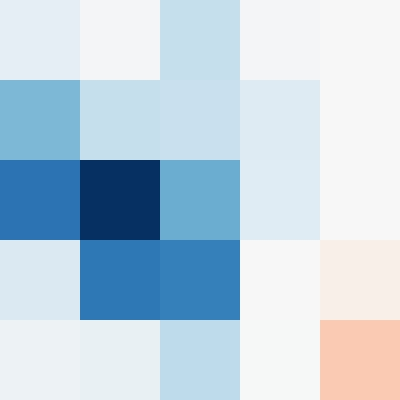
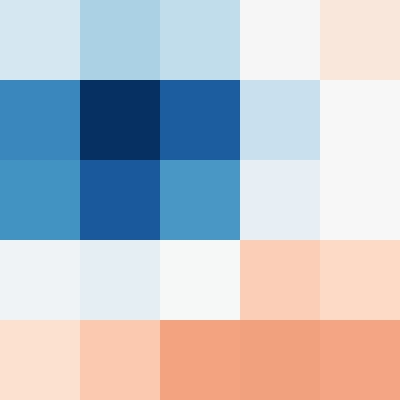
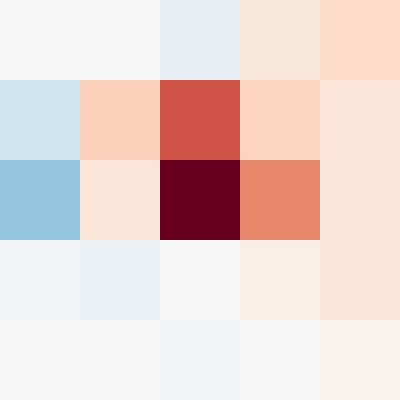
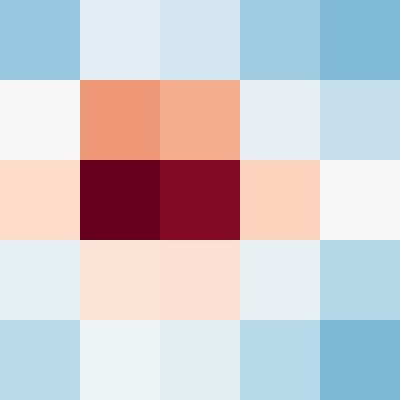
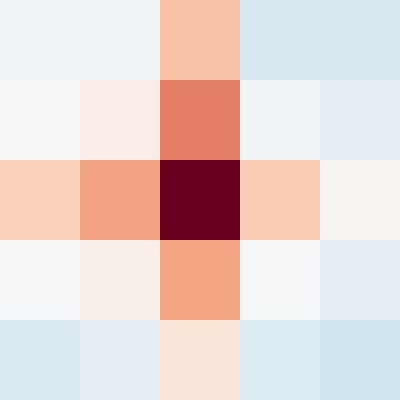
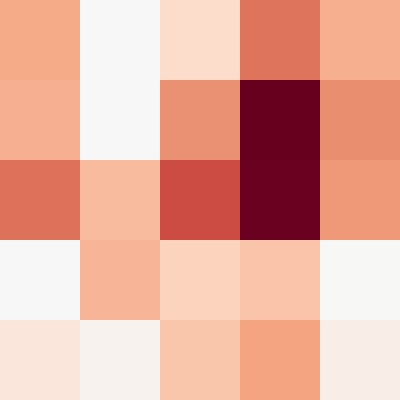
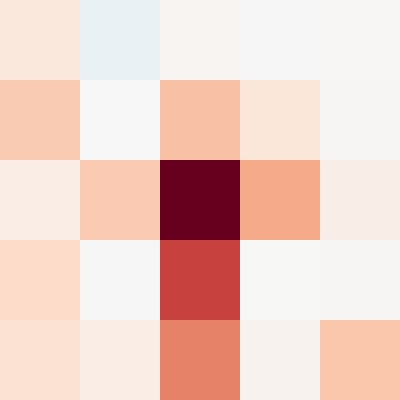
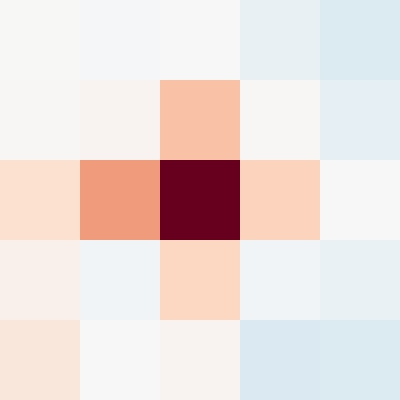
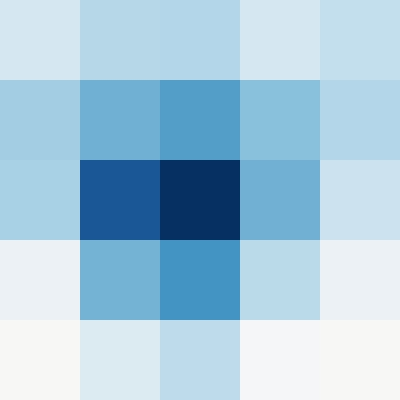
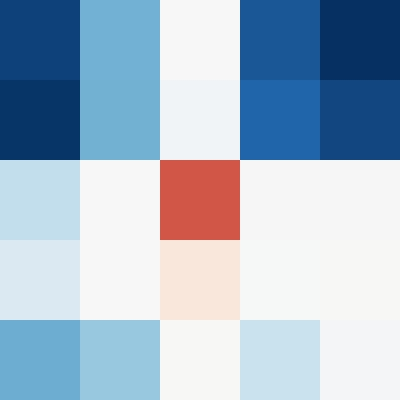
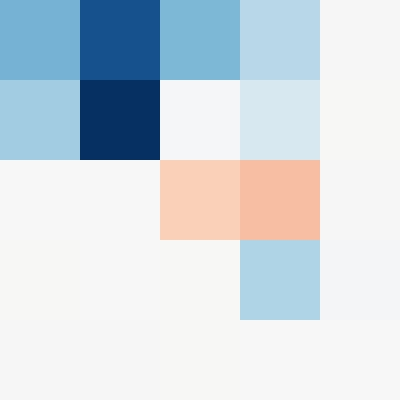
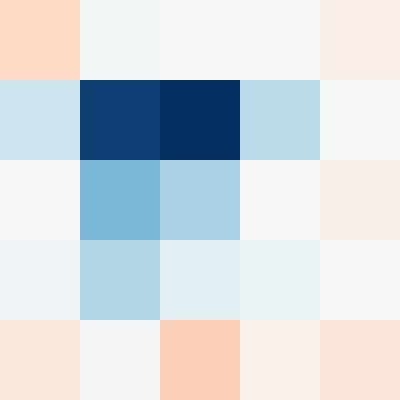
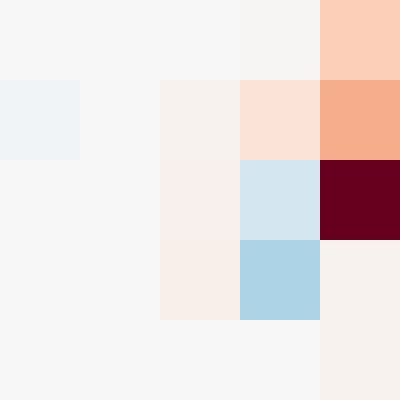
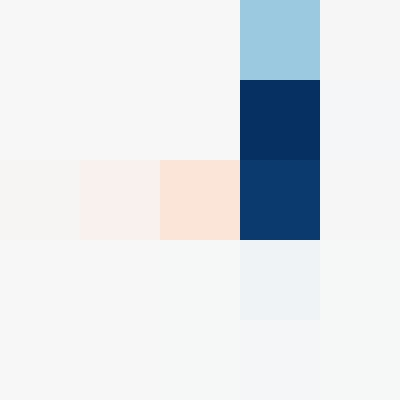
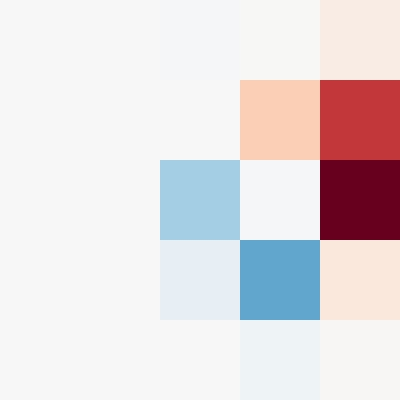
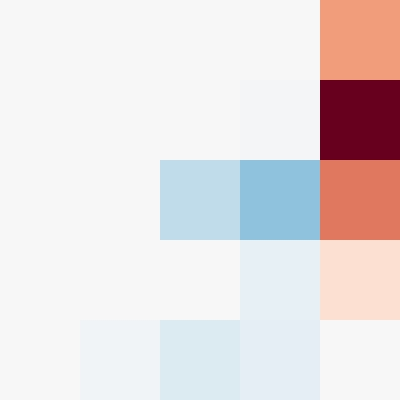
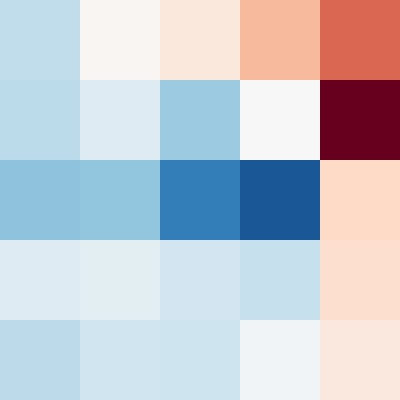
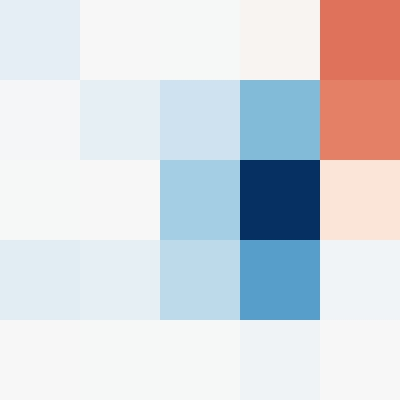
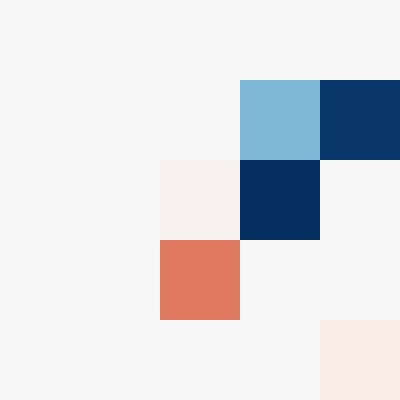
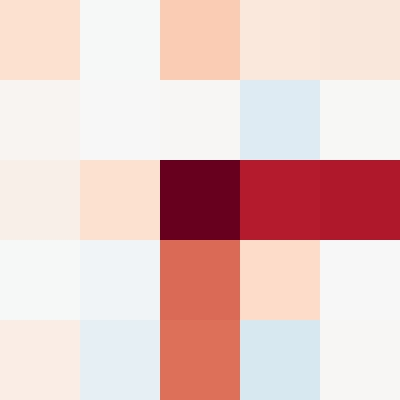
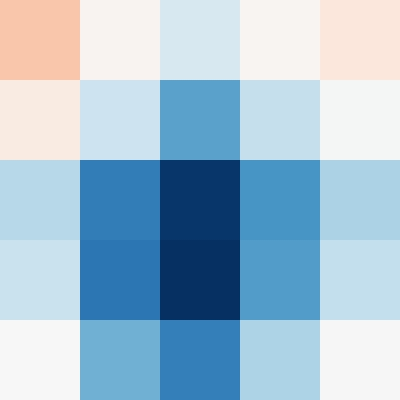
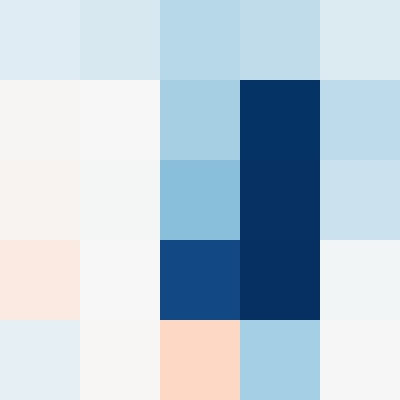
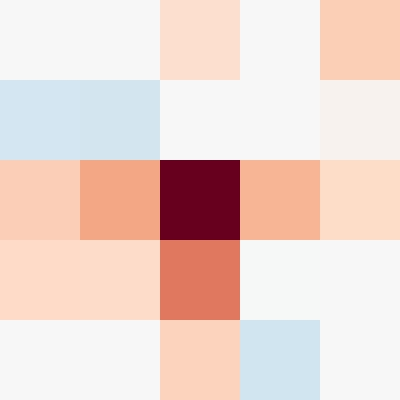
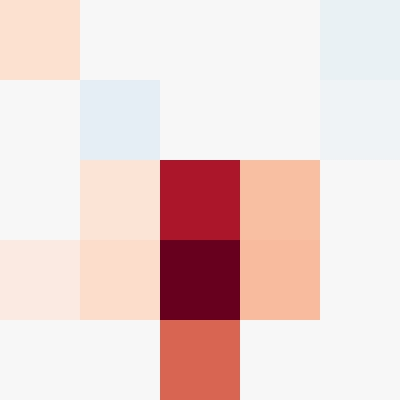
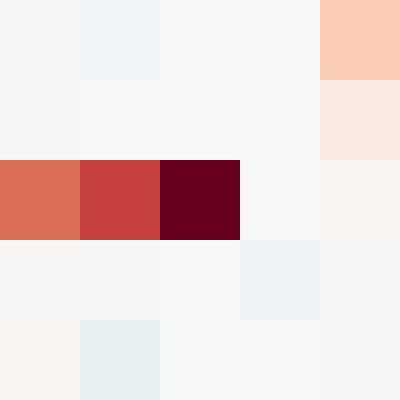
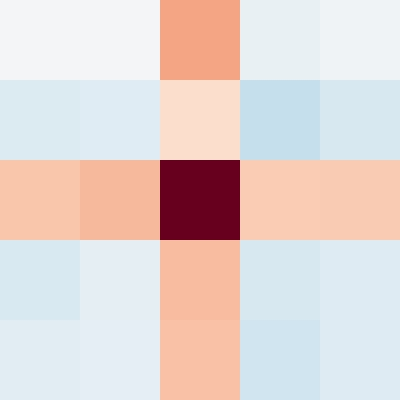
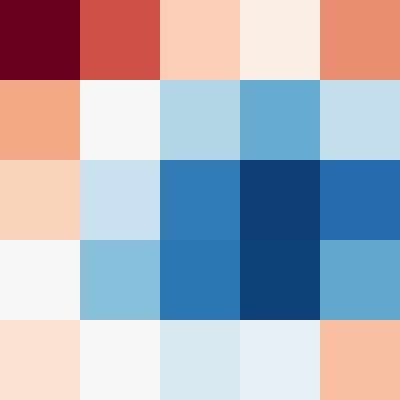
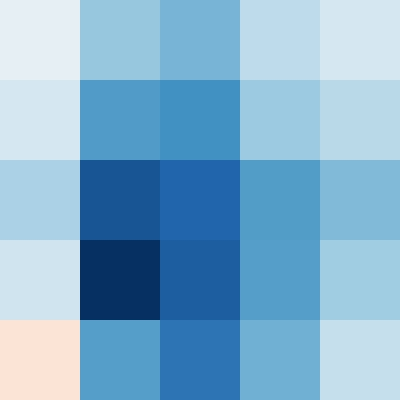
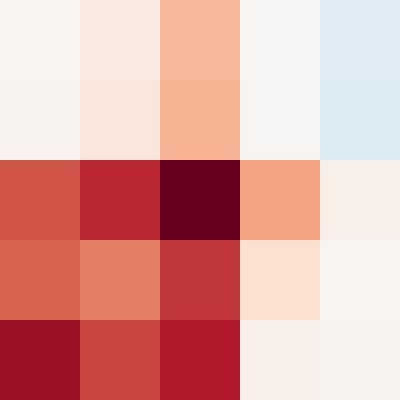
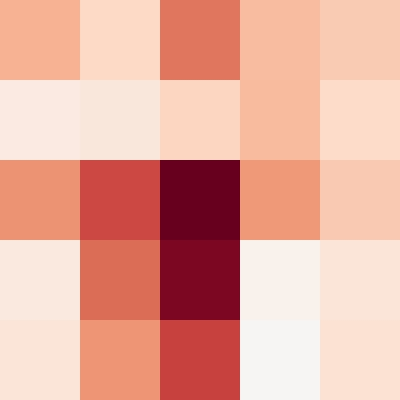
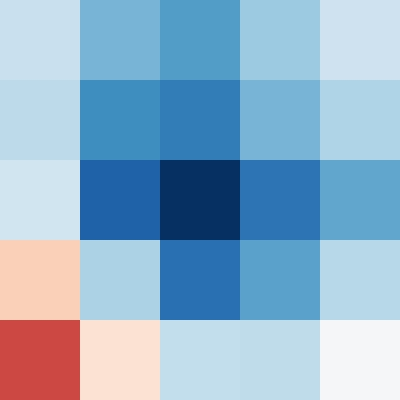
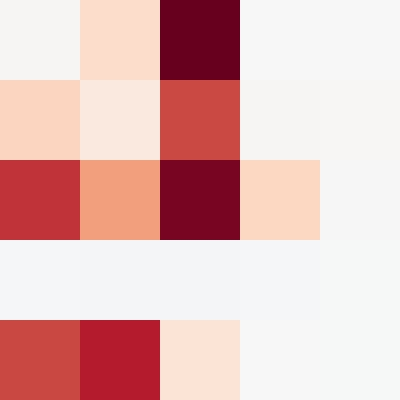
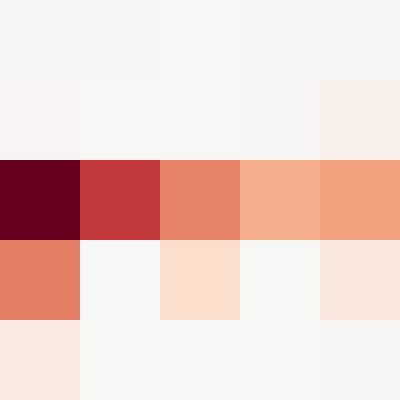
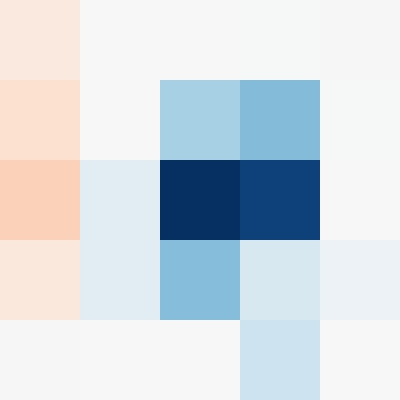
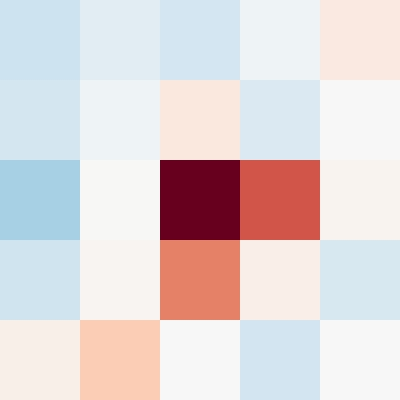
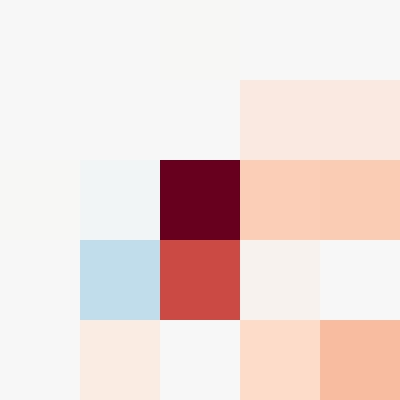
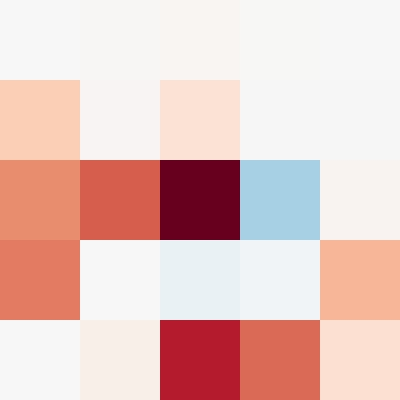
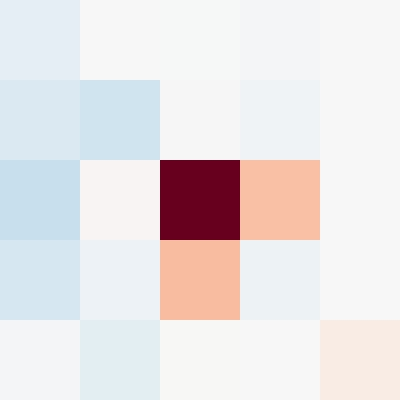
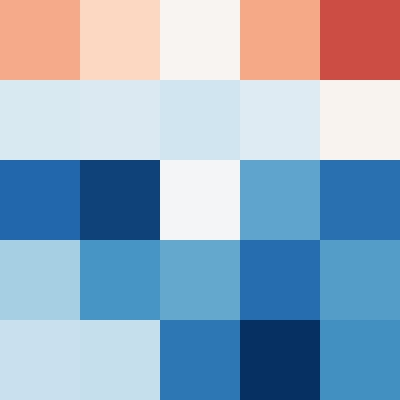
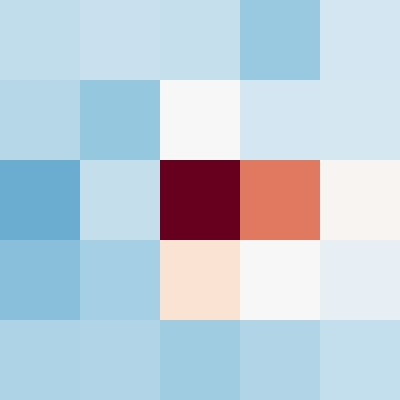
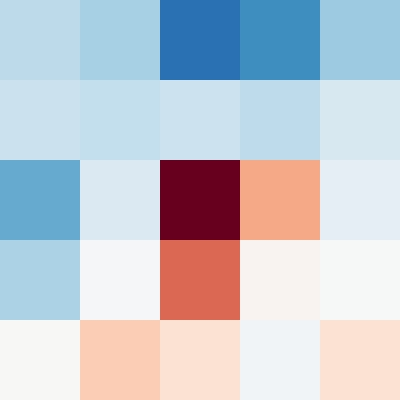
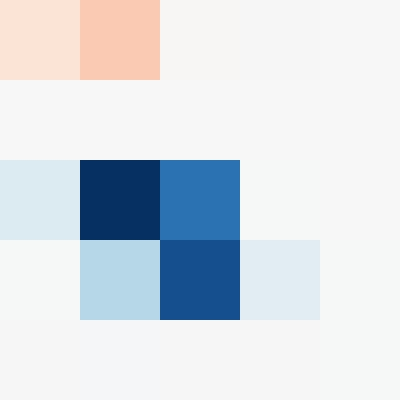
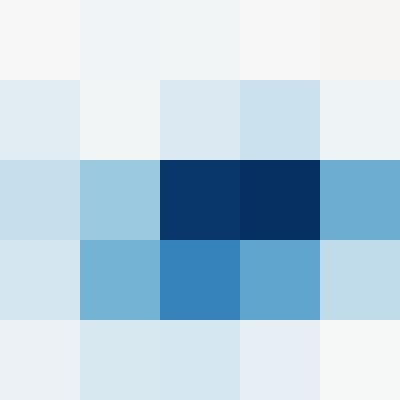
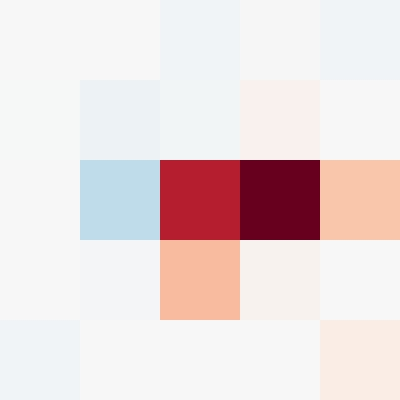
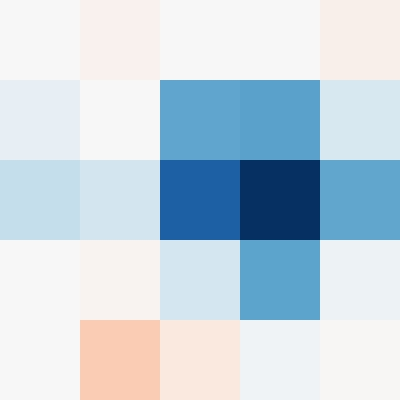
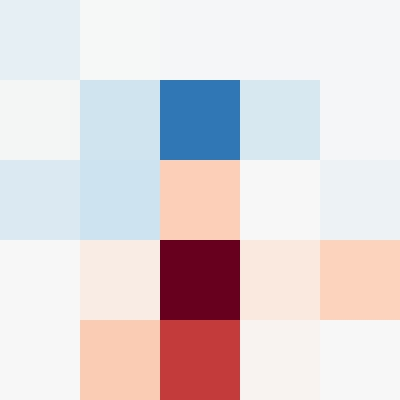
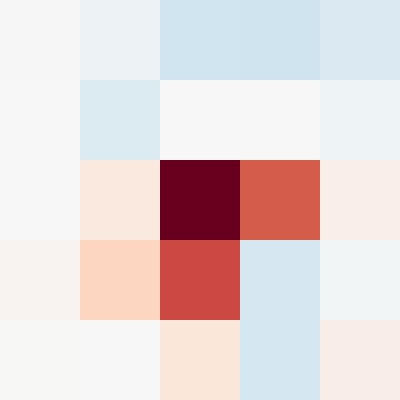
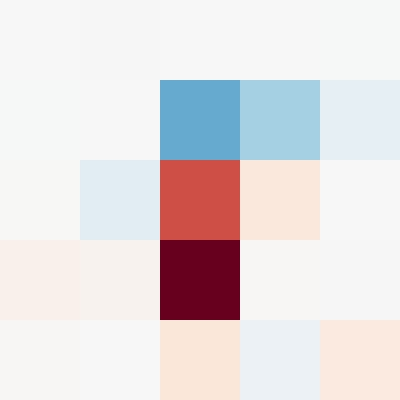
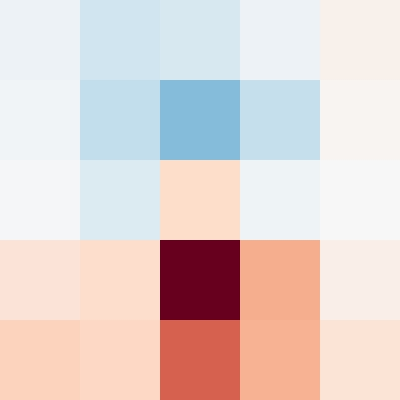
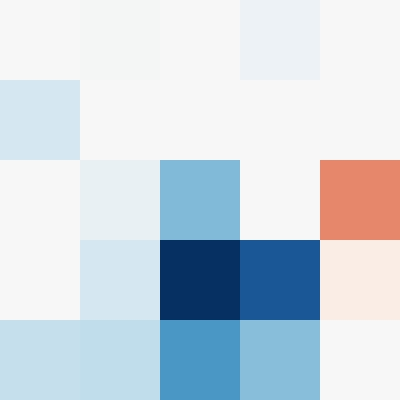
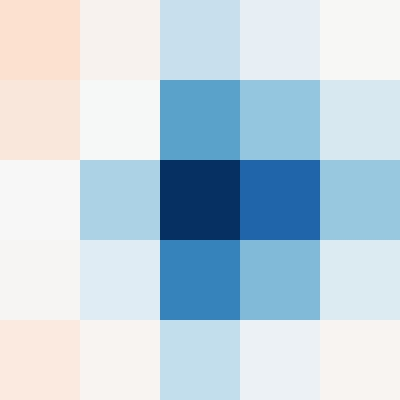
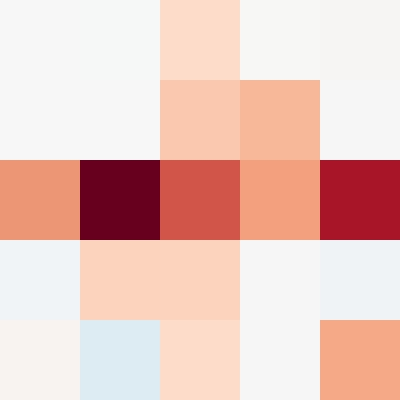
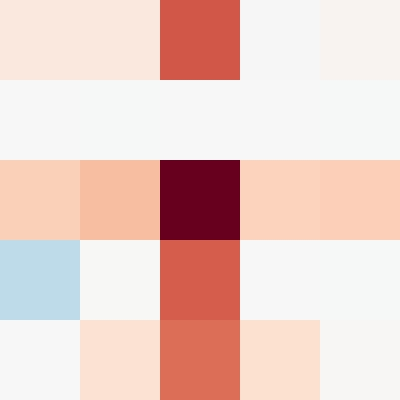
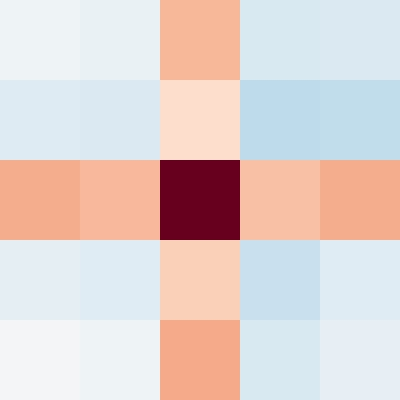
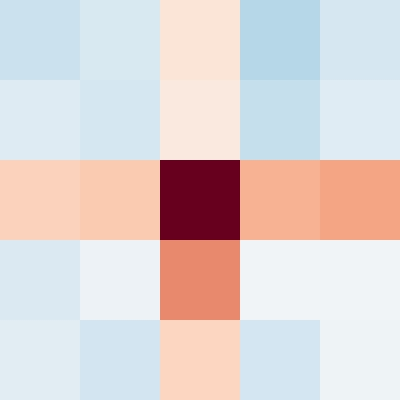
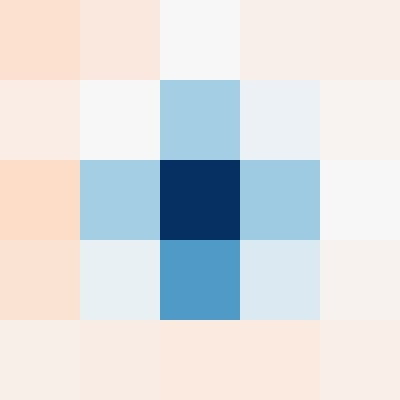
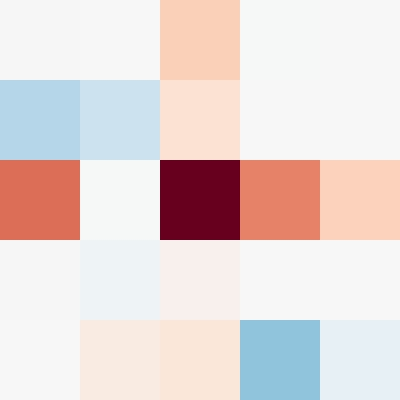
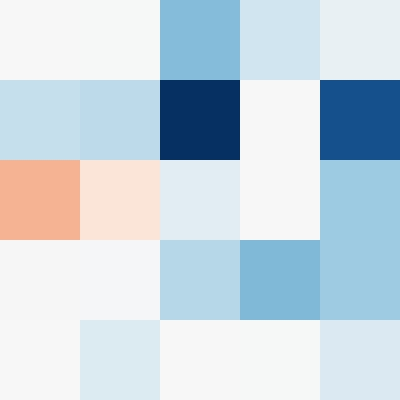
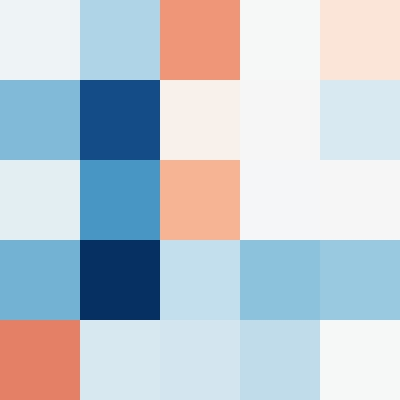
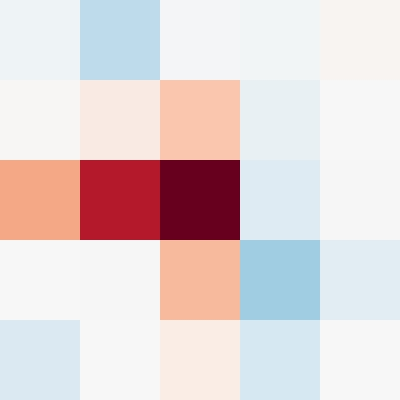
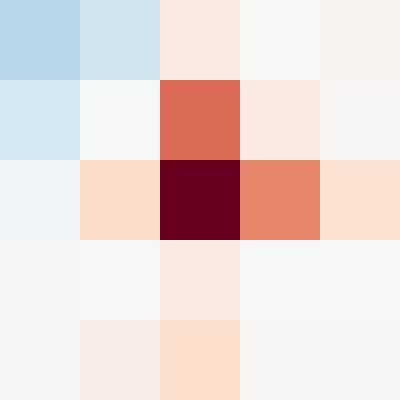
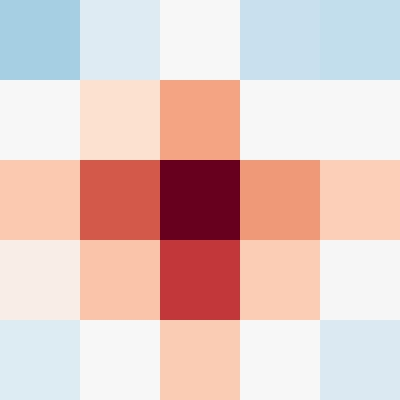
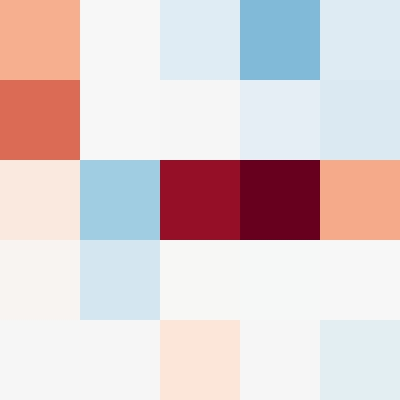
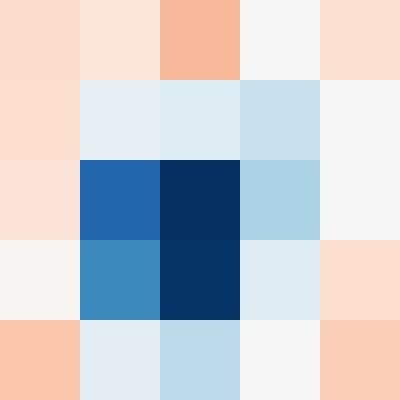
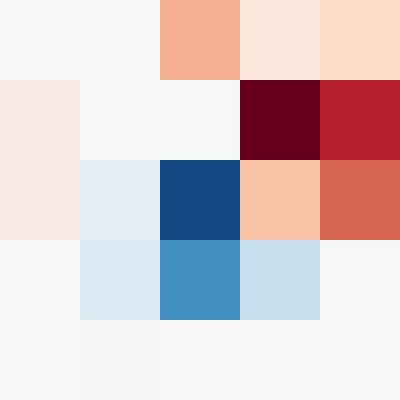
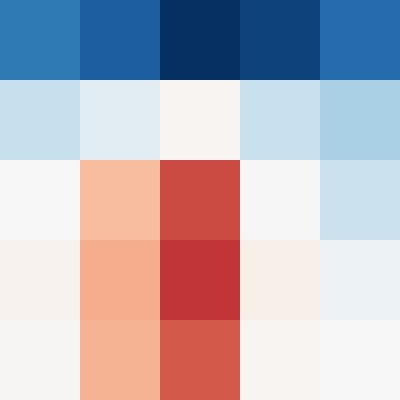
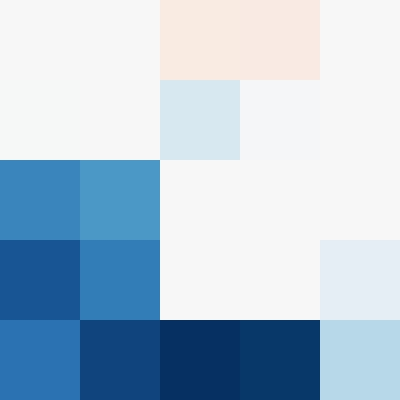
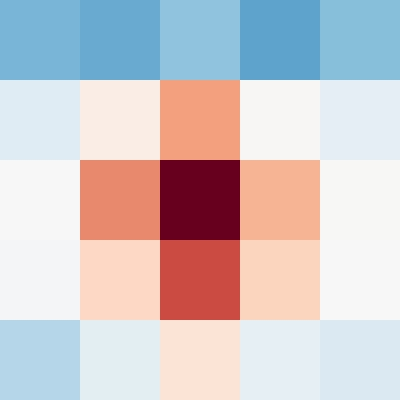
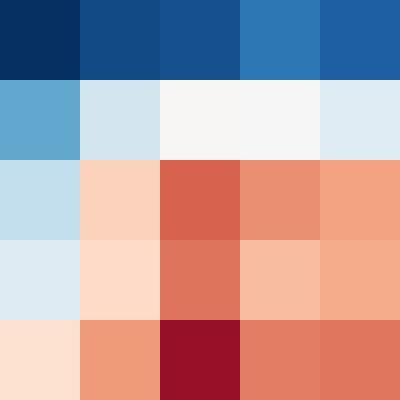
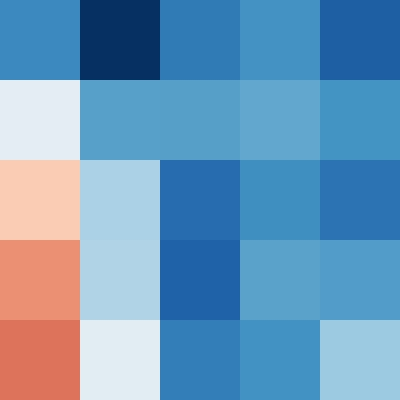
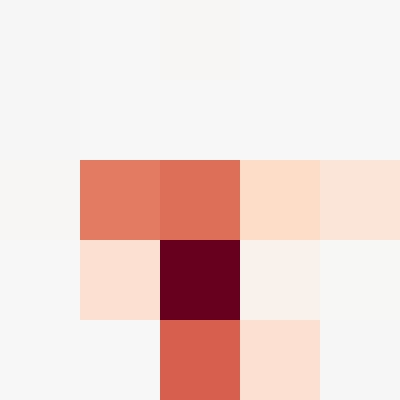
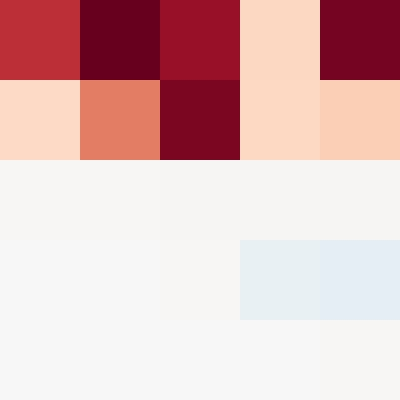
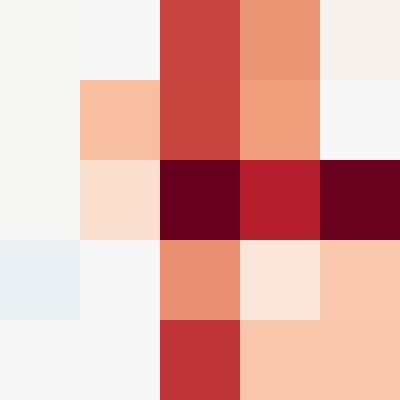
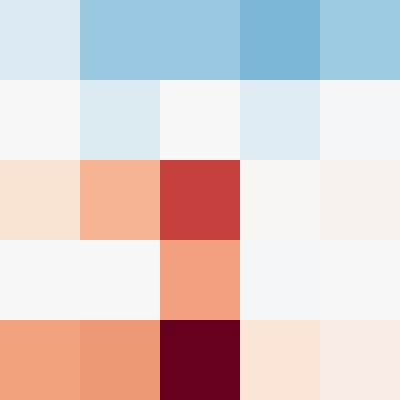
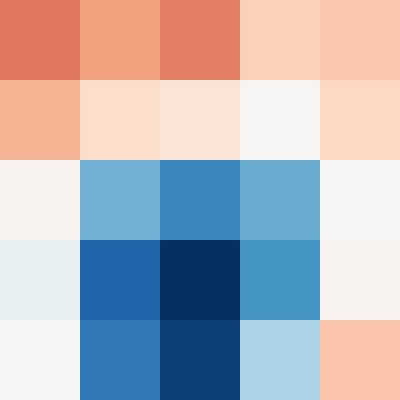
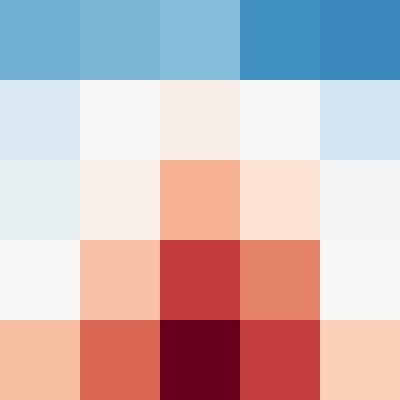
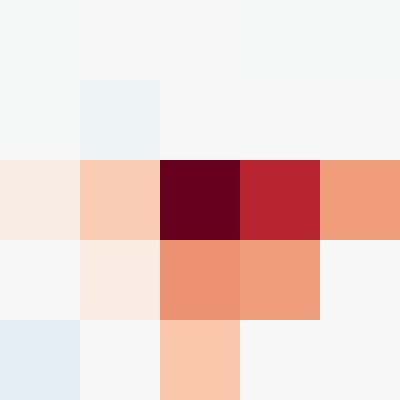
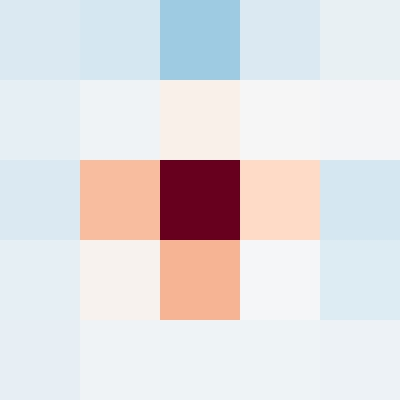
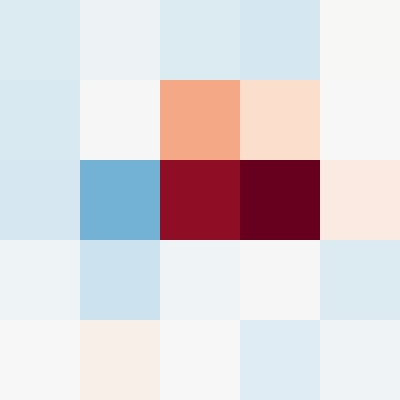
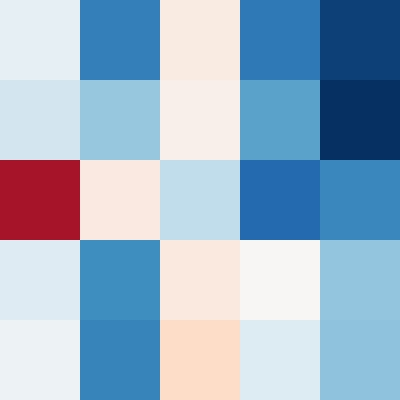
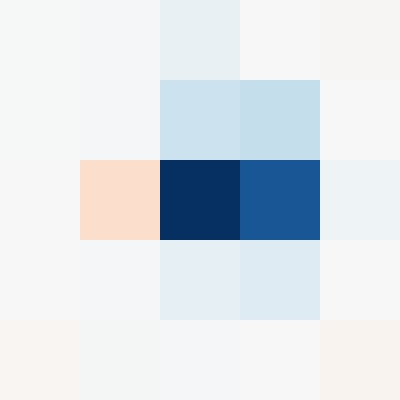
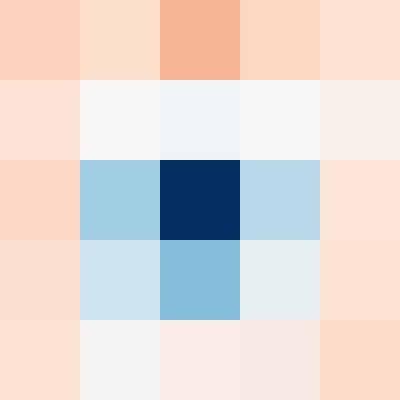
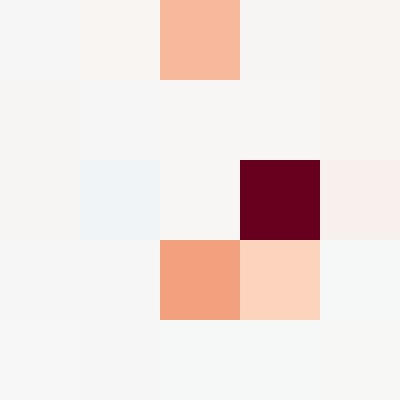
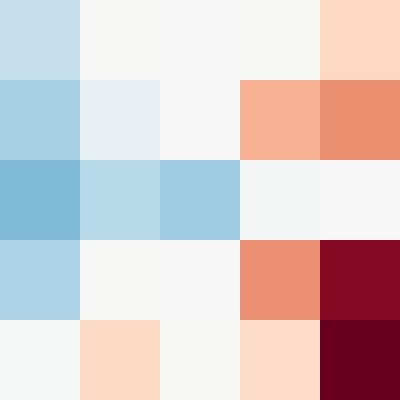
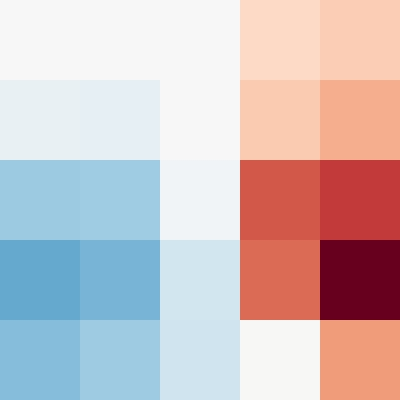
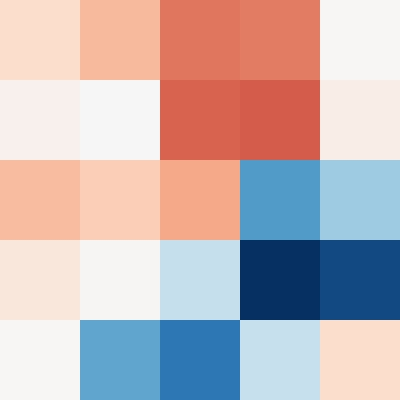
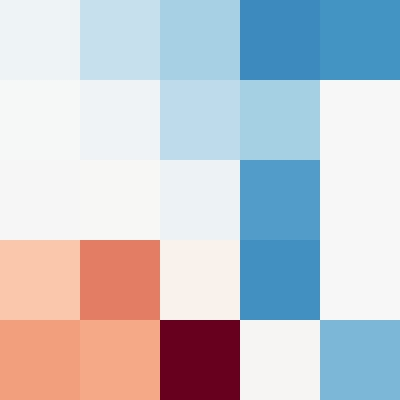
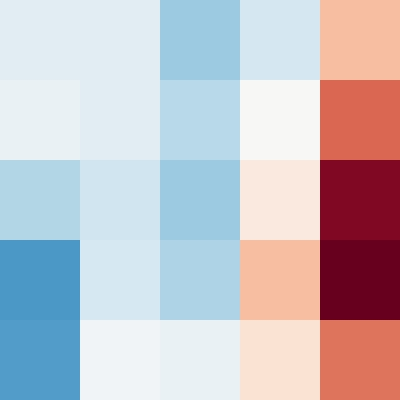
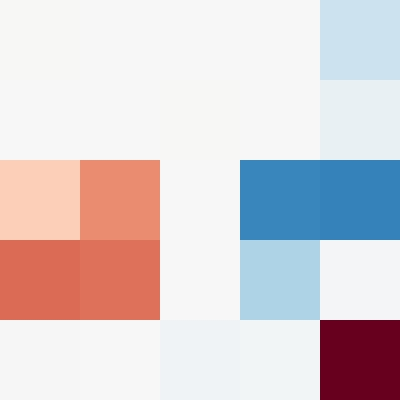
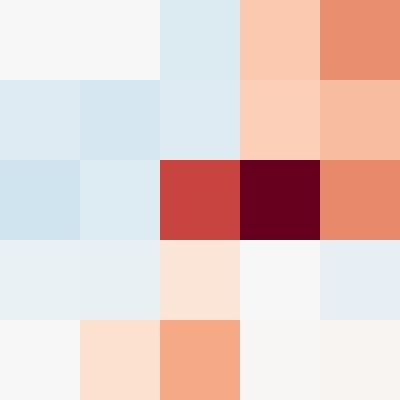
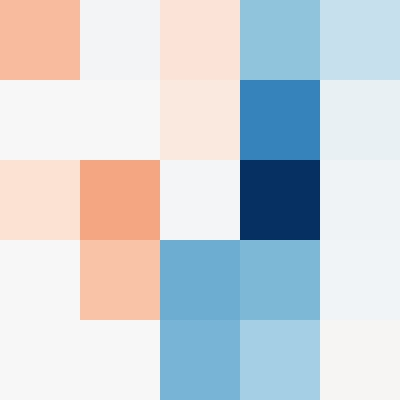
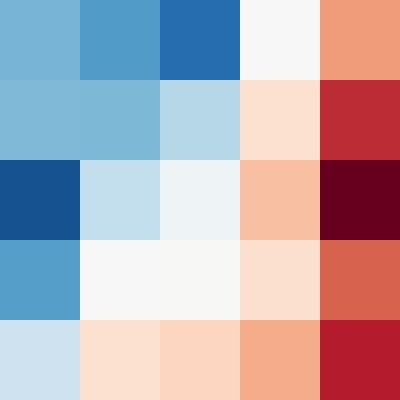
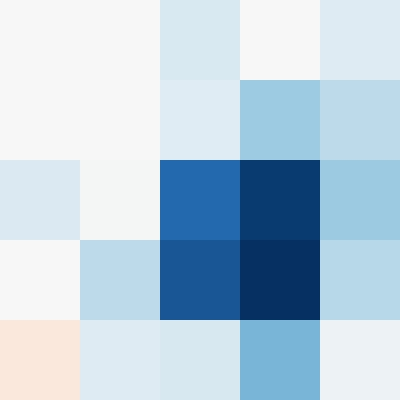
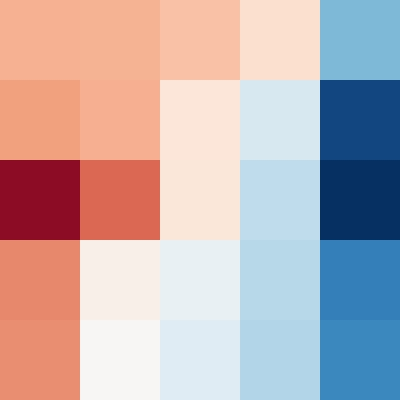
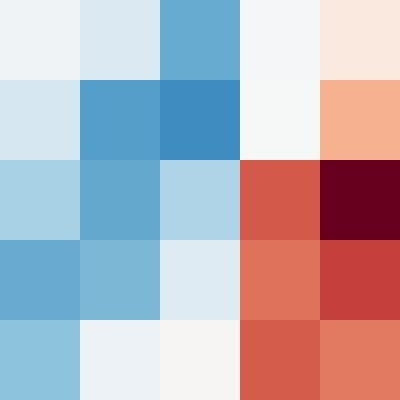
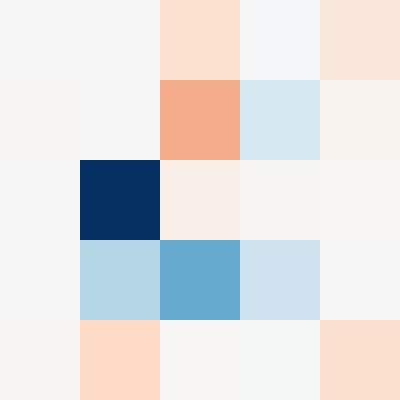
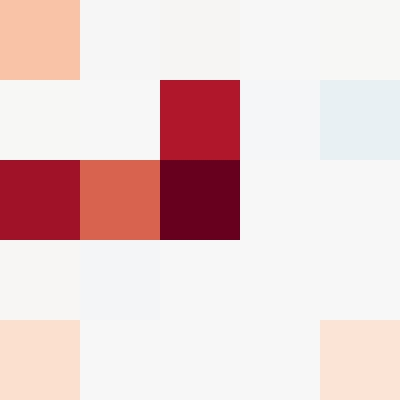
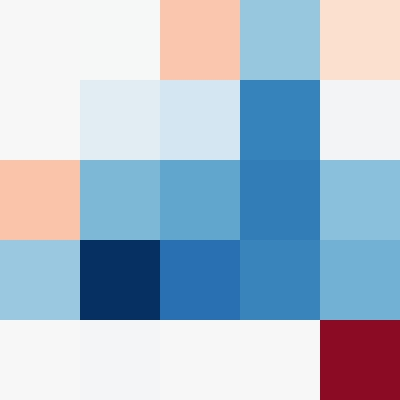
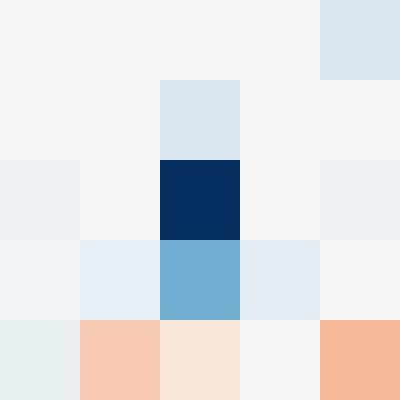
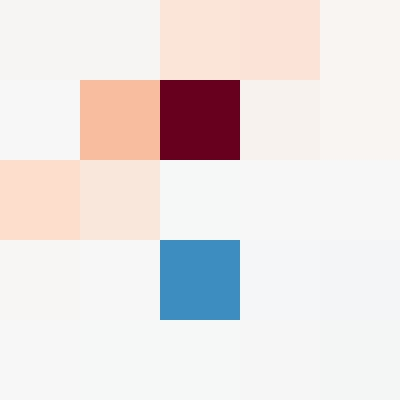
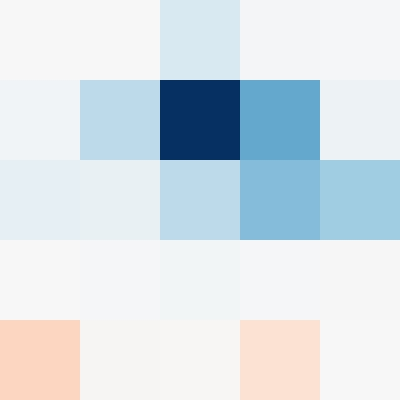
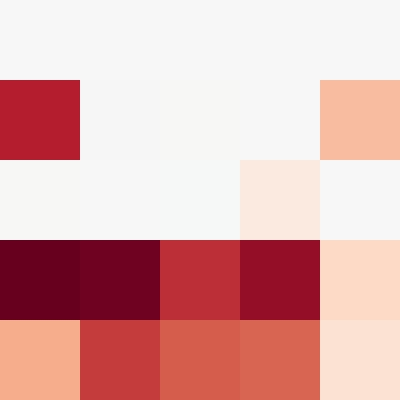
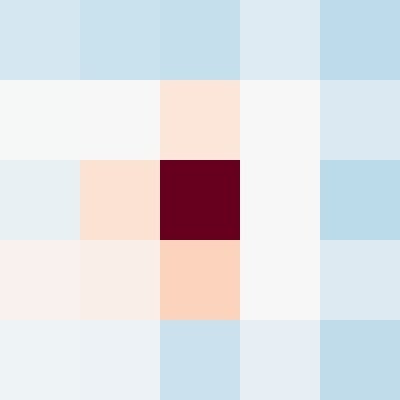
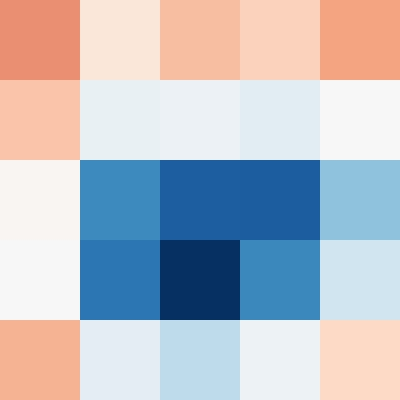
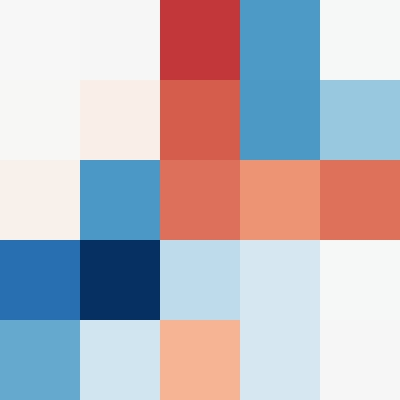
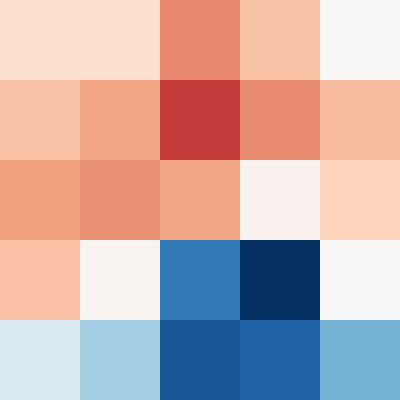
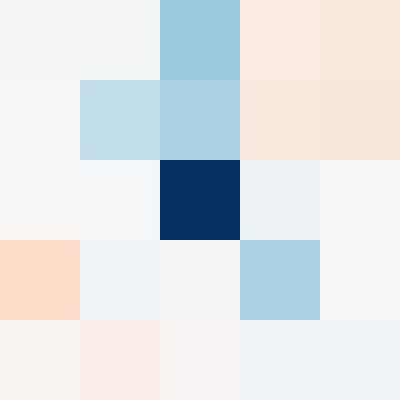
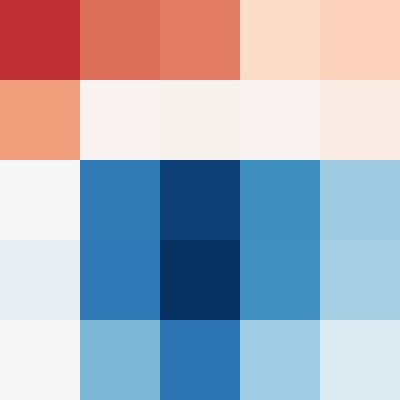
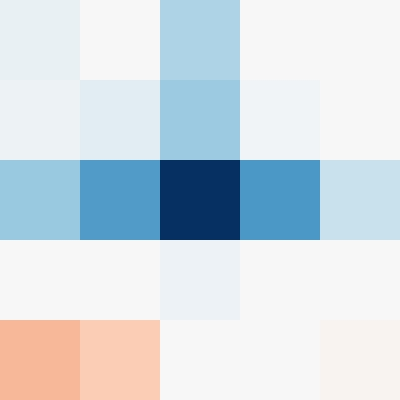
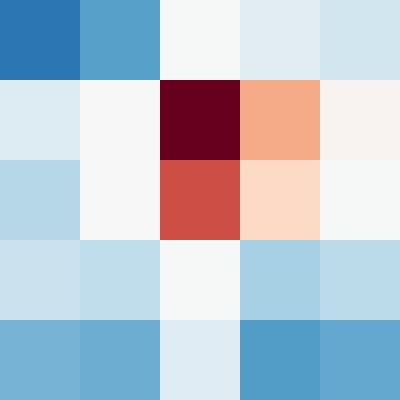
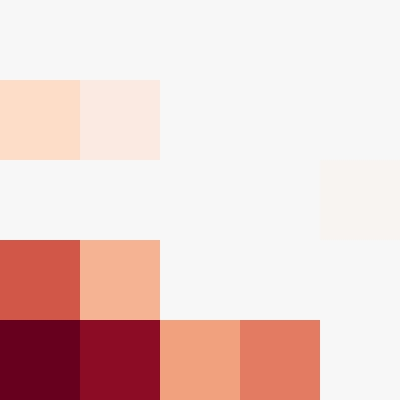
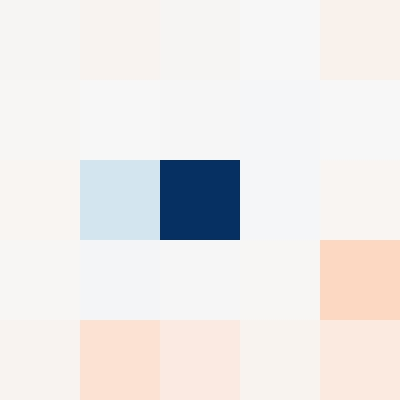
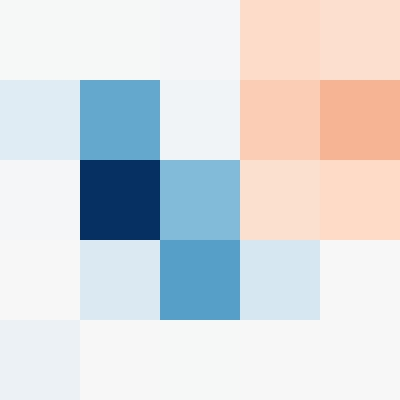
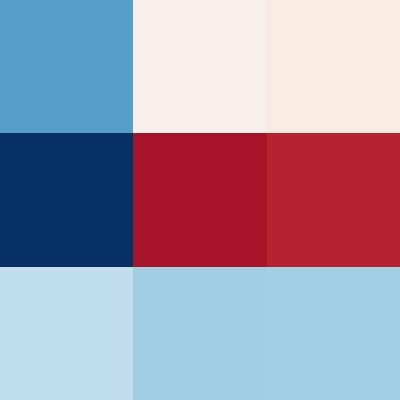
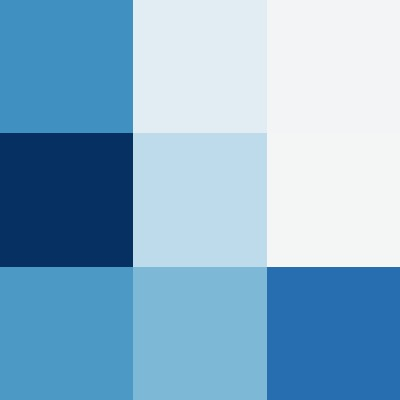
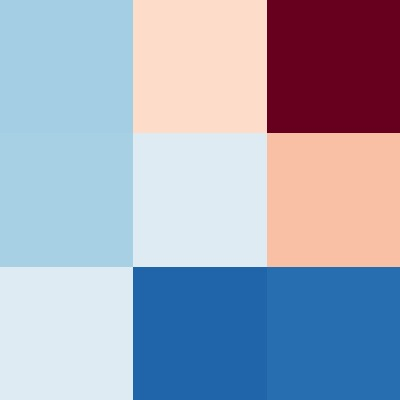
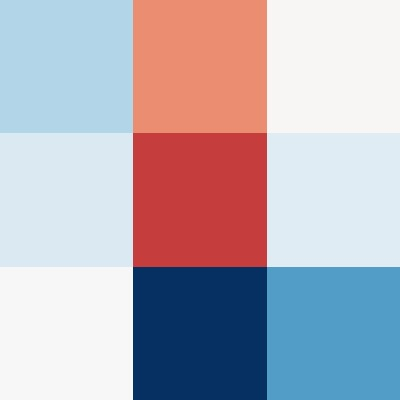
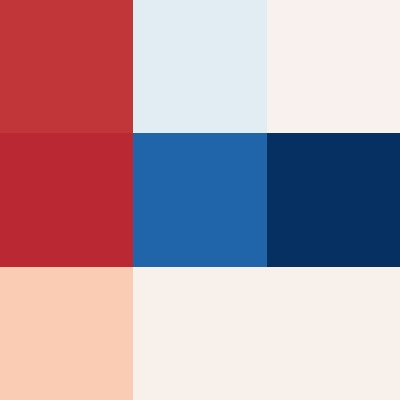
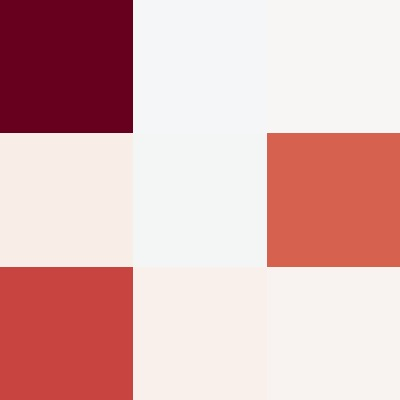
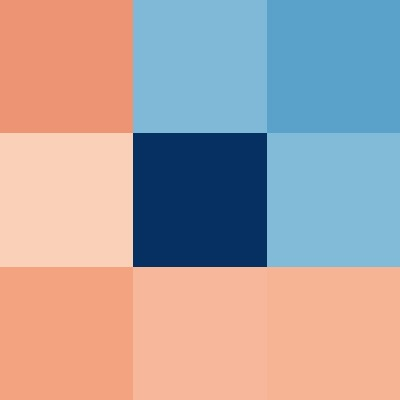
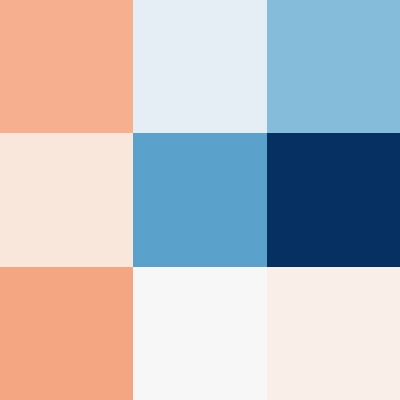
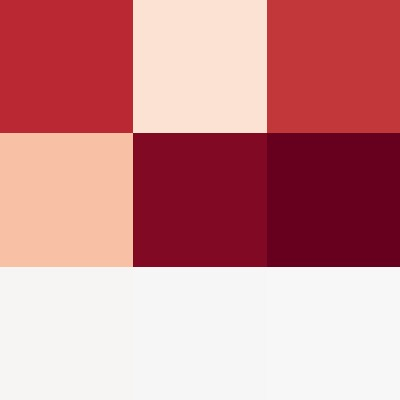
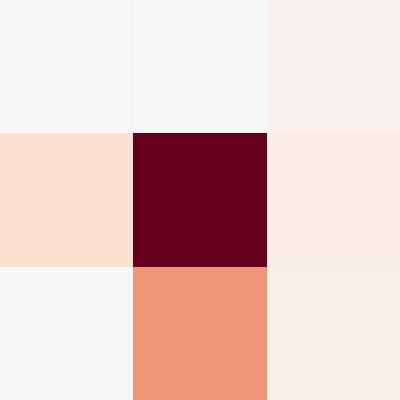
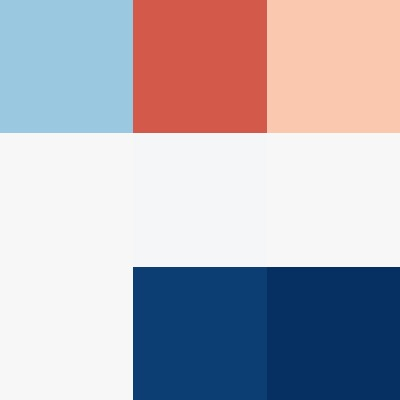
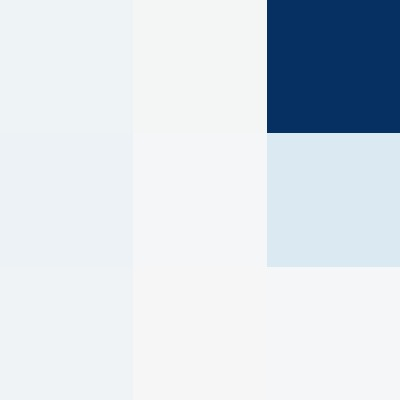
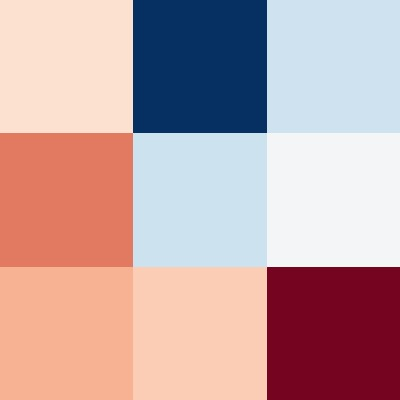
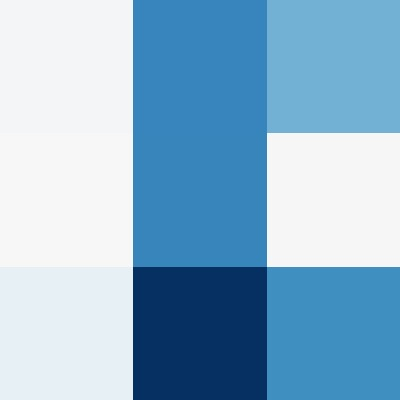
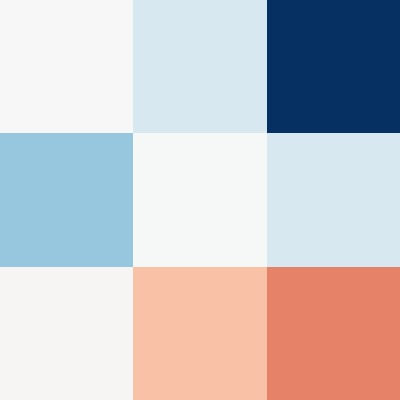
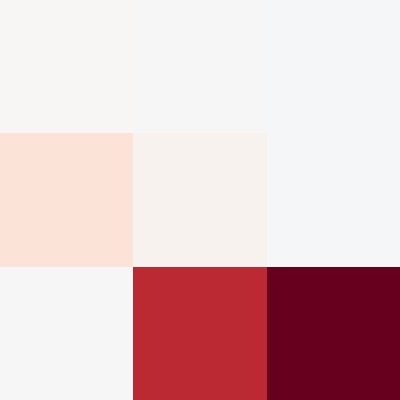
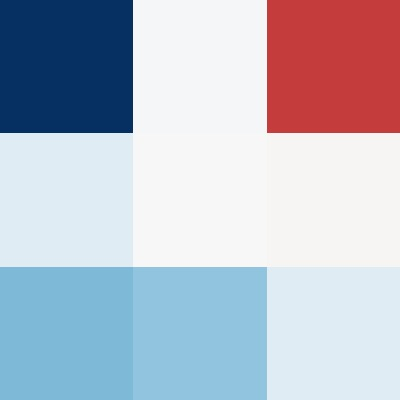
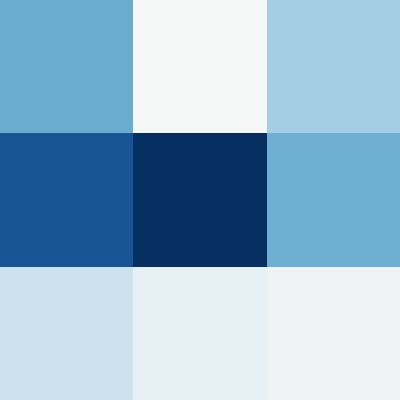

In [29]:
circuit_diagram[0].update_layout(height = 2000, width=2000, showlegend=False)

circuit_diagram[0]

In [28]:
circuit_diagram[0].write_html("../../plots/features6:56_old_toobig.html")

circuit_diagram[0].write_image("../../plots/features6:56_old_toobig.png")

In [50]:
kernel_pruned_circuit

Sequential(
  (features_0): Conv2d(3, 7, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (features_1): ReLU(inplace=True)
  (features_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_3): Conv2d(7, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (features_4): ReLU(inplace=True)
  (features_5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_6): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [61]:
dfs[0]

edge_num  layer_name layer out_channel in_channel  act_rank  grad_rank  \
1            1  features_0     0           0          1  1.933793   0.000008   
0            0  features_0     0           0          0  1.312708   0.000008   
6            6  features_0     0           2          0  2.480993   0.000017   
7            7  features_0     0           2          1  1.523213   0.000017   
8            8  features_0     0           2          2  1.016833   0.000017   
...        ...         ...   ...         ...        ...       ...        ...   
23325    23325  features_6     2          56         93  0.229052   0.000947   
23344    23344  features_6     2          56        112  0.207033   0.000947   
23404    23404  features_6     2          56        172  0.137072   0.000947   
23412    23412  features_6     2          56        180  0.179541   0.000947   
23422    23422  features_6     2          56        190  0.203327   0.000947   

       norm_rank  
1       0.000035  
0       0.000020  
6       0.000063  
7       0.000037  
8       0.000027  
...          ...  
23325   0.000206  
23344   0.000188  
23404   0.000137  
23412   0.000160  
23422   0.000188  

[210 rows x 8 columns]